In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : True,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'normalized','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'diffusion_fa',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_MSE_7_0_0_0_0_1_t1t2_normalized_e_n_e_0_1_e_1_0_diffusion_fa_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_1_42_n_normalized_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(734160, 828)
(734160, 1)
validation
(101248, 828)
(101248, 1)
test
(100432, 828)
(100432, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 1538049 (5.87 MB)


Trainable params: 1538049 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/74 [..............................] - ETA: 1:55 - loss: 0.0603 - STD: 1.2314e-04 - MAE: 0.2290

 4/74 [>.............................] - ETA: 2s - loss: 0.0262 - STD: 3.7905e-04 - MAE: 0.1268  

 5/74 [=>............................] - ETA: 2s - loss: 0.0259 - STD: 3.5217e-04 - MAE: 0.1264

 6/74 [=>............................] - ETA: 3s - loss: 0.0259 - STD: 3.2685e-04 - MAE: 0.1270

 7/74 [=>............................] - ETA: 3s - loss: 0.0258 - STD: 3.0498e-04 - MAE: 0.1273

 8/74 [==>...........................] - ETA: 3s - loss: 0.0256 - STD: 2.8745e-04 - MAE: 0.1269

 9/74 [==>...........................] - ETA: 3s - loss: 0.0252 - STD: 2.7317e-04 - MAE: 0.1258

10/74 [===>..........................] - ETA: 3s - loss: 0.0247 - STD: 2.6163e-04 - MAE: 0.1241

11/74 [===>..........................] - ETA: 3s - loss: 0.0240 - STD: 2.5270e-04 - MAE: 0.1217

12/74 [===>..........................] - ETA: 3s - loss: 0.0232 - STD: 2.4599e-04 - MAE: 0.1188

13/74 [====>.........................] - ETA: 3s - loss: 0.0223 - STD: 2.4111e-04 - MAE: 0.1156

14/74 [====>.........................] - ETA: 3s - loss: 0.0214 - STD: 2.3740e-04 - MAE: 0.1127

15/74 [=====>........................] - ETA: 3s - loss: 0.0206 - STD: 2.3477e-04 - MAE: 0.1102

16/74 [=====>........................] - ETA: 3s - loss: 0.0199 - STD: 2.3258e-04 - MAE: 0.1085

17/74 [=====>........................] - ETA: 3s - loss: 0.0194 - STD: 2.3105e-04 - MAE: 0.1075

18/74 [======>.......................] - ETA: 5s - loss: 0.0192 - STD: 2.3003e-04 - MAE: 0.1069

21/74 [=======>......................] - ETA: 4s - loss: 0.0182 - STD: 2.3006e-04 - MAE: 0.1051

23/74 [========>.....................] - ETA: 4s - loss: 0.0174 - STD: 2.3126e-04 - MAE: 0.1028

24/74 [========>.....................] - ETA: 4s - loss: 0.0171 - STD: 2.3199e-04 - MAE: 0.1017

25/74 [=========>....................] - ETA: 4s - loss: 0.0168 - STD: 2.3252e-04 - MAE: 0.1006

26/74 [=========>....................] - ETA: 3s - loss: 0.0165 - STD: 2.3295e-04 - MAE: 0.0996

27/74 [=========>....................] - ETA: 3s - loss: 0.0163 - STD: 2.3346e-04 - MAE: 0.0987

28/74 [==========>...................] - ETA: 3s - loss: 0.0161 - STD: 2.3392e-04 - MAE: 0.0978

29/74 [==========>...................] - ETA: 3s - loss: 0.0159 - STD: 2.3459e-04 - MAE: 0.0971

30/74 [===========>..................] - ETA: 3s - loss: 0.0157 - STD: 2.3549e-04 - MAE: 0.0963

31/74 [===========>..................] - ETA: 3s - loss: 0.0155 - STD: 2.3657e-04 - MAE: 0.0956

32/74 [===========>..................] - ETA: 3s - loss: 0.0153 - STD: 2.3805e-04 - MAE: 0.0949

33/74 [============>.................] - ETA: 3s - loss: 0.0151 - STD: 2.3984e-04 - MAE: 0.0943

34/74 [============>.................] - ETA: 3s - loss: 0.0150 - STD: 2.4184e-04 - MAE: 0.0937

35/74 [=============>................] - ETA: 3s - loss: 0.0148 - STD: 2.4428e-04 - MAE: 0.0931

36/74 [=============>................] - ETA: 2s - loss: 0.0146 - STD: 2.4699e-04 - MAE: 0.0926

37/74 [==============>...............] - ETA: 2s - loss: 0.0145 - STD: 2.4985e-04 - MAE: 0.0922

38/74 [==============>...............] - ETA: 2s - loss: 0.0144 - STD: 2.5312e-04 - MAE: 0.0919

39/74 [==============>...............] - ETA: 2s - loss: 0.0142 - STD: 2.5639e-04 - MAE: 0.0916

40/74 [===============>..............] - ETA: 2s - loss: 0.0141 - STD: 2.5985e-04 - MAE: 0.0913

41/74 [===============>..............] - ETA: 2s - loss: 0.0140 - STD: 2.6347e-04 - MAE: 0.0910

42/74 [================>.............] - ETA: 2s - loss: 0.0139 - STD: 2.6701e-04 - MAE: 0.0907

43/74 [================>.............] - ETA: 2s - loss: 0.0138 - STD: 2.7054e-04 - MAE: 0.0904

44/74 [================>.............] - ETA: 2s - loss: 0.0137 - STD: 2.7401e-04 - MAE: 0.0901

45/74 [=================>............] - ETA: 2s - loss: 0.0136 - STD: 2.7740e-04 - MAE: 0.0898

46/74 [=================>............] - ETA: 2s - loss: 0.0135 - STD: 2.8089e-04 - MAE: 0.0895

47/74 [==================>...........] - ETA: 2s - loss: 0.0134 - STD: 2.8441e-04 - MAE: 0.0892

48/74 [==================>...........] - ETA: 1s - loss: 0.0133 - STD: 2.8781e-04 - MAE: 0.0888

49/74 [==================>...........] - ETA: 1s - loss: 0.0132 - STD: 2.9133e-04 - MAE: 0.0885

50/74 [===================>..........] - ETA: 1s - loss: 0.0131 - STD: 2.9506e-04 - MAE: 0.0883

51/74 [===================>..........] - ETA: 1s - loss: 0.0131 - STD: 2.9892e-04 - MAE: 0.0880

52/74 [====================>.........] - ETA: 1s - loss: 0.0130 - STD: 3.0293e-04 - MAE: 0.0877

53/74 [====================>.........] - ETA: 1s - loss: 0.0129 - STD: 3.0705e-04 - MAE: 0.0875

54/74 [====================>.........] - ETA: 1s - loss: 0.0129 - STD: 3.1157e-04 - MAE: 0.0872

55/74 [=====================>........] - ETA: 1s - loss: 0.0128 - STD: 3.1630e-04 - MAE: 0.0870

56/74 [=====================>........] - ETA: 1s - loss: 0.0127 - STD: 3.2112e-04 - MAE: 0.0868

57/74 [======================>.......] - ETA: 1s - loss: 0.0127 - STD: 3.2631e-04 - MAE: 0.0866

58/74 [======================>.......] - ETA: 1s - loss: 0.0126 - STD: 3.3168e-04 - MAE: 0.0865

59/74 [======================>.......] - ETA: 1s - loss: 0.0126 - STD: 3.3717e-04 - MAE: 0.0863

60/74 [=======================>......] - ETA: 1s - loss: 0.0125 - STD: 3.4277e-04 - MAE: 0.0861

61/74 [=======================>......] - ETA: 0s - loss: 0.0124 - STD: 3.4876e-04 - MAE: 0.0860

62/74 [========================>.....] - ETA: 0s - loss: 0.0124 - STD: 3.5476e-04 - MAE: 0.0858

63/74 [========================>.....] - ETA: 0s - loss: 0.0123 - STD: 3.6071e-04 - MAE: 0.0857

64/74 [========================>.....] - ETA: 0s - loss: 0.0123 - STD: 3.6686e-04 - MAE: 0.0855

65/74 [=========================>....] - ETA: 0s - loss: 0.0122 - STD: 3.7303e-04 - MAE: 0.0853

66/74 [=========================>....] - ETA: 0s - loss: 0.0122 - STD: 3.7941e-04 - MAE: 0.0852

67/74 [==========================>...] - ETA: 0s - loss: 0.0121 - STD: 3.8607e-04 - MAE: 0.0850

68/74 [==========================>...] - ETA: 0s - loss: 0.0121 - STD: 3.9284e-04 - MAE: 0.0849

69/74 [==========================>...] - ETA: 0s - loss: 0.0121 - STD: 3.9978e-04 - MAE: 0.0847

70/74 [===========================>..] - ETA: 0s - loss: 0.0120 - STD: 4.0697e-04 - MAE: 0.0846

71/74 [===========================>..] - ETA: 0s - loss: 0.0120 - STD: 4.1440e-04 - MAE: 0.0844

72/74 [============================>.] - ETA: 0s - loss: 0.0119 - STD: 4.2227e-04 - MAE: 0.0843

73/74 [============================>.] - ETA: 0s - loss: 0.0119 - STD: 4.3041e-04 - MAE: 0.0842

74/74 [==============================] - ETA: 0s - loss: 0.0119 - STD: 4.3895e-04 - MAE: 0.0841

74/74 [==============================] - 8s 83ms/step - loss: 0.0119 - STD: 4.3895e-04 - MAE: 0.0841 - val_loss: 0.0085 - val_STD: 7.4605e-04 - val_MAE: 0.0715


Epoch 2/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0093 - STD: 0.0011 - MAE: 0.0757

 2/74 [..............................] - ETA: 5s - loss: 0.0093 - STD: 0.0011 - MAE: 0.0758

 3/74 [>.............................] - ETA: 5s - loss: 0.0093 - STD: 0.0011 - MAE: 0.0760

 4/74 [>.............................] - ETA: 4s - loss: 0.0093 - STD: 0.0012 - MAE: 0.0760

 5/74 [=>............................] - ETA: 4s - loss: 0.0093 - STD: 0.0012 - MAE: 0.0759

 6/74 [=>............................] - ETA: 4s - loss: 0.0093 - STD: 0.0012 - MAE: 0.0759

 7/74 [=>............................] - ETA: 4s - loss: 0.0093 - STD: 0.0012 - MAE: 0.0759

 8/74 [==>...........................] - ETA: 4s - loss: 0.0092 - STD: 0.0013 - MAE: 0.0757

 9/74 [==>...........................] - ETA: 4s - loss: 0.0093 - STD: 0.0013 - MAE: 0.0758

10/74 [===>..........................] - ETA: 4s - loss: 0.0093 - STD: 0.0013 - MAE: 0.0757

11/74 [===>..........................] - ETA: 4s - loss: 0.0092 - STD: 0.0013 - MAE: 0.0757

12/74 [===>..........................] - ETA: 4s - loss: 0.0092 - STD: 0.0014 - MAE: 0.0756

13/74 [====>.........................] - ETA: 4s - loss: 0.0092 - STD: 0.0014 - MAE: 0.0755

14/74 [====>.........................] - ETA: 4s - loss: 0.0092 - STD: 0.0014 - MAE: 0.0754

15/74 [=====>........................] - ETA: 3s - loss: 0.0092 - STD: 0.0015 - MAE: 0.0754

16/74 [=====>........................] - ETA: 3s - loss: 0.0092 - STD: 0.0015 - MAE: 0.0753

17/74 [=====>........................] - ETA: 3s - loss: 0.0092 - STD: 0.0015 - MAE: 0.0753

18/74 [======>.......................] - ETA: 3s - loss: 0.0092 - STD: 0.0016 - MAE: 0.0752

19/74 [======>.......................] - ETA: 3s - loss: 0.0091 - STD: 0.0016 - MAE: 0.0752

20/74 [=======>......................] - ETA: 3s - loss: 0.0091 - STD: 0.0016 - MAE: 0.0752

21/74 [=======>......................] - ETA: 3s - loss: 0.0091 - STD: 0.0017 - MAE: 0.0751

22/74 [=======>......................] - ETA: 3s - loss: 0.0091 - STD: 0.0017 - MAE: 0.0751

24/74 [========>.....................] - ETA: 3s - loss: 0.0091 - STD: 0.0018 - MAE: 0.0750

25/74 [=========>....................] - ETA: 3s - loss: 0.0091 - STD: 0.0019 - MAE: 0.0750

26/74 [=========>....................] - ETA: 3s - loss: 0.0091 - STD: 0.0019 - MAE: 0.0751

27/74 [=========>....................] - ETA: 3s - loss: 0.0091 - STD: 0.0020 - MAE: 0.0750

28/74 [==========>...................] - ETA: 3s - loss: 0.0091 - STD: 0.0020 - MAE: 0.0750

29/74 [==========>...................] - ETA: 2s - loss: 0.0091 - STD: 0.0021 - MAE: 0.0750

30/74 [===========>..................] - ETA: 2s - loss: 0.0091 - STD: 0.0021 - MAE: 0.0749

31/74 [===========>..................] - ETA: 2s - loss: 0.0091 - STD: 0.0022 - MAE: 0.0749

32/74 [===========>..................] - ETA: 2s - loss: 0.0091 - STD: 0.0023 - MAE: 0.0749

33/74 [============>.................] - ETA: 2s - loss: 0.0091 - STD: 0.0023 - MAE: 0.0749

34/74 [============>.................] - ETA: 2s - loss: 0.0090 - STD: 0.0024 - MAE: 0.0749

35/74 [=============>................] - ETA: 2s - loss: 0.0090 - STD: 0.0025 - MAE: 0.0748

36/74 [=============>................] - ETA: 2s - loss: 0.0090 - STD: 0.0025 - MAE: 0.0748

37/74 [==============>...............] - ETA: 2s - loss: 0.0090 - STD: 0.0026 - MAE: 0.0748

38/74 [==============>...............] - ETA: 2s - loss: 0.0090 - STD: 0.0027 - MAE: 0.0748

39/74 [==============>...............] - ETA: 2s - loss: 0.0090 - STD: 0.0028 - MAE: 0.0747

40/74 [===============>..............] - ETA: 2s - loss: 0.0090 - STD: 0.0029 - MAE: 0.0747

41/74 [===============>..............] - ETA: 2s - loss: 0.0090 - STD: 0.0030 - MAE: 0.0746

42/74 [================>.............] - ETA: 2s - loss: 0.0090 - STD: 0.0031 - MAE: 0.0746

43/74 [================>.............] - ETA: 2s - loss: 0.0090 - STD: 0.0032 - MAE: 0.0746

44/74 [================>.............] - ETA: 1s - loss: 0.0090 - STD: 0.0033 - MAE: 0.0746

45/74 [=================>............] - ETA: 1s - loss: 0.0090 - STD: 0.0035 - MAE: 0.0745

46/74 [=================>............] - ETA: 1s - loss: 0.0089 - STD: 0.0036 - MAE: 0.0745

47/74 [==================>...........] - ETA: 1s - loss: 0.0089 - STD: 0.0037 - MAE: 0.0745

48/74 [==================>...........] - ETA: 1s - loss: 0.0089 - STD: 0.0039 - MAE: 0.0744

49/74 [==================>...........] - ETA: 1s - loss: 0.0089 - STD: 0.0040 - MAE: 0.0744

50/74 [===================>..........] - ETA: 1s - loss: 0.0089 - STD: 0.0042 - MAE: 0.0744

51/74 [===================>..........] - ETA: 1s - loss: 0.0089 - STD: 0.0043 - MAE: 0.0743

52/74 [====================>.........] - ETA: 1s - loss: 0.0089 - STD: 0.0045 - MAE: 0.0743

53/74 [====================>.........] - ETA: 1s - loss: 0.0089 - STD: 0.0047 - MAE: 0.0742

54/74 [====================>.........] - ETA: 1s - loss: 0.0088 - STD: 0.0049 - MAE: 0.0742

55/74 [=====================>........] - ETA: 1s - loss: 0.0088 - STD: 0.0051 - MAE: 0.0741

56/74 [=====================>........] - ETA: 1s - loss: 0.0088 - STD: 0.0053 - MAE: 0.0741

57/74 [======================>.......] - ETA: 1s - loss: 0.0088 - STD: 0.0055 - MAE: 0.0740

58/74 [======================>.......] - ETA: 1s - loss: 0.0088 - STD: 0.0057 - MAE: 0.0740

59/74 [======================>.......] - ETA: 1s - loss: 0.0088 - STD: 0.0059 - MAE: 0.0739

60/74 [=======================>......] - ETA: 0s - loss: 0.0088 - STD: 0.0062 - MAE: 0.0738

61/74 [=======================>......] - ETA: 0s - loss: 0.0087 - STD: 0.0064 - MAE: 0.0738

62/74 [========================>.....] - ETA: 0s - loss: 0.0087 - STD: 0.0067 - MAE: 0.0737

63/74 [========================>.....] - ETA: 0s - loss: 0.0087 - STD: 0.0070 - MAE: 0.0737

64/74 [========================>.....] - ETA: 0s - loss: 0.0087 - STD: 0.0073 - MAE: 0.0736

65/74 [=========================>....] - ETA: 0s - loss: 0.0087 - STD: 0.0075 - MAE: 0.0735

66/74 [=========================>....] - ETA: 0s - loss: 0.0087 - STD: 0.0078 - MAE: 0.0734

67/74 [==========================>...] - ETA: 0s - loss: 0.0086 - STD: 0.0082 - MAE: 0.0734

68/74 [==========================>...] - ETA: 0s - loss: 0.0086 - STD: 0.0085 - MAE: 0.0733

69/74 [==========================>...] - ETA: 0s - loss: 0.0086 - STD: 0.0088 - MAE: 0.0732

70/74 [===========================>..] - ETA: 0s - loss: 0.0086 - STD: 0.0091 - MAE: 0.0732

71/74 [===========================>..] - ETA: 0s - loss: 0.0086 - STD: 0.0094 - MAE: 0.0731

72/74 [============================>.] - ETA: 0s - loss: 0.0086 - STD: 0.0098 - MAE: 0.0730

73/74 [============================>.] - ETA: 0s - loss: 0.0085 - STD: 0.0101 - MAE: 0.0730

74/74 [==============================] - ETA: 0s - loss: 0.0085 - STD: 0.0105 - MAE: 0.0729

74/74 [==============================] - 5s 70ms/step - loss: 0.0085 - STD: 0.0105 - MAE: 0.0729 - val_loss: 0.0068 - val_STD: 0.0236 - val_MAE: 0.0633


Epoch 3/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0072 - STD: 0.0363 - MAE: 0.0672

 2/74 [..............................] - ETA: 5s - loss: 0.0073 - STD: 0.0364 - MAE: 0.0676

 3/74 [>.............................] - ETA: 4s - loss: 0.0073 - STD: 0.0366 - MAE: 0.0676

 4/74 [>.............................] - ETA: 4s - loss: 0.0074 - STD: 0.0369 - MAE: 0.0676

 5/74 [=>............................] - ETA: 4s - loss: 0.0073 - STD: 0.0371 - MAE: 0.0674

 6/74 [=>............................] - ETA: 4s - loss: 0.0073 - STD: 0.0374 - MAE: 0.0673

 7/74 [=>............................] - ETA: 4s - loss: 0.0073 - STD: 0.0377 - MAE: 0.0673

 8/74 [==>...........................] - ETA: 4s - loss: 0.0073 - STD: 0.0380 - MAE: 0.0673

 9/74 [==>...........................] - ETA: 4s - loss: 0.0073 - STD: 0.0382 - MAE: 0.0672

10/74 [===>..........................] - ETA: 4s - loss: 0.0073 - STD: 0.0384 - MAE: 0.0671

11/74 [===>..........................] - ETA: 4s - loss: 0.0072 - STD: 0.0386 - MAE: 0.0670

12/74 [===>..........................] - ETA: 4s - loss: 0.0073 - STD: 0.0388 - MAE: 0.0670

13/74 [====>.........................] - ETA: 4s - loss: 0.0072 - STD: 0.0389 - MAE: 0.0669

14/74 [====>.........................] - ETA: 4s - loss: 0.0072 - STD: 0.0391 - MAE: 0.0669

15/74 [=====>........................] - ETA: 3s - loss: 0.0072 - STD: 0.0393 - MAE: 0.0668

16/74 [=====>........................] - ETA: 3s - loss: 0.0072 - STD: 0.0394 - MAE: 0.0667

17/74 [=====>........................] - ETA: 3s - loss: 0.0072 - STD: 0.0395 - MAE: 0.0668

18/74 [======>.......................] - ETA: 3s - loss: 0.0072 - STD: 0.0395 - MAE: 0.0667

19/74 [======>.......................] - ETA: 3s - loss: 0.0072 - STD: 0.0396 - MAE: 0.0667

20/74 [=======>......................] - ETA: 3s - loss: 0.0072 - STD: 0.0397 - MAE: 0.0666

21/74 [=======>......................] - ETA: 3s - loss: 0.0072 - STD: 0.0397 - MAE: 0.0665

22/74 [=======>......................] - ETA: 3s - loss: 0.0072 - STD: 0.0398 - MAE: 0.0665

23/74 [========>.....................] - ETA: 3s - loss: 0.0072 - STD: 0.0399 - MAE: 0.0665

24/74 [========>.....................] - ETA: 3s - loss: 0.0071 - STD: 0.0399 - MAE: 0.0664

25/74 [=========>....................] - ETA: 3s - loss: 0.0071 - STD: 0.0400 - MAE: 0.0664

26/74 [=========>....................] - ETA: 3s - loss: 0.0071 - STD: 0.0401 - MAE: 0.0663

27/74 [=========>....................] - ETA: 3s - loss: 0.0071 - STD: 0.0402 - MAE: 0.0663

28/74 [==========>...................] - ETA: 3s - loss: 0.0071 - STD: 0.0403 - MAE: 0.0662

29/74 [==========>...................] - ETA: 3s - loss: 0.0071 - STD: 0.0403 - MAE: 0.0662

30/74 [===========>..................] - ETA: 2s - loss: 0.0071 - STD: 0.0404 - MAE: 0.0662

31/74 [===========>..................] - ETA: 2s - loss: 0.0071 - STD: 0.0405 - MAE: 0.0662

32/74 [===========>..................] - ETA: 2s - loss: 0.0071 - STD: 0.0406 - MAE: 0.0661

33/74 [============>.................] - ETA: 2s - loss: 0.0071 - STD: 0.0407 - MAE: 0.0661

34/74 [============>.................] - ETA: 2s - loss: 0.0071 - STD: 0.0408 - MAE: 0.0660

35/74 [=============>................] - ETA: 2s - loss: 0.0071 - STD: 0.0409 - MAE: 0.0660

36/74 [=============>................] - ETA: 2s - loss: 0.0071 - STD: 0.0410 - MAE: 0.0660

37/74 [==============>...............] - ETA: 2s - loss: 0.0071 - STD: 0.0410 - MAE: 0.0659

38/74 [==============>...............] - ETA: 2s - loss: 0.0071 - STD: 0.0411 - MAE: 0.0659

40/74 [===============>..............] - ETA: 2s - loss: 0.0071 - STD: 0.0413 - MAE: 0.0659

41/74 [===============>..............] - ETA: 2s - loss: 0.0071 - STD: 0.0414 - MAE: 0.0658

42/74 [================>.............] - ETA: 2s - loss: 0.0071 - STD: 0.0414 - MAE: 0.0658

43/74 [================>.............] - ETA: 2s - loss: 0.0071 - STD: 0.0415 - MAE: 0.0658

44/74 [================>.............] - ETA: 1s - loss: 0.0070 - STD: 0.0415 - MAE: 0.0657

45/74 [=================>............] - ETA: 1s - loss: 0.0070 - STD: 0.0416 - MAE: 0.0657

46/74 [=================>............] - ETA: 1s - loss: 0.0070 - STD: 0.0417 - MAE: 0.0657

47/74 [==================>...........] - ETA: 1s - loss: 0.0070 - STD: 0.0417 - MAE: 0.0656

48/74 [==================>...........] - ETA: 1s - loss: 0.0070 - STD: 0.0418 - MAE: 0.0656

49/74 [==================>...........] - ETA: 1s - loss: 0.0070 - STD: 0.0419 - MAE: 0.0655

50/74 [===================>..........] - ETA: 1s - loss: 0.0070 - STD: 0.0419 - MAE: 0.0655

51/74 [===================>..........] - ETA: 1s - loss: 0.0070 - STD: 0.0420 - MAE: 0.0654

52/74 [====================>.........] - ETA: 1s - loss: 0.0070 - STD: 0.0420 - MAE: 0.0654

53/74 [====================>.........] - ETA: 1s - loss: 0.0070 - STD: 0.0421 - MAE: 0.0654

54/74 [====================>.........] - ETA: 1s - loss: 0.0070 - STD: 0.0422 - MAE: 0.0653

55/74 [=====================>........] - ETA: 1s - loss: 0.0070 - STD: 0.0422 - MAE: 0.0653

56/74 [=====================>........] - ETA: 1s - loss: 0.0070 - STD: 0.0423 - MAE: 0.0652

57/74 [======================>.......] - ETA: 1s - loss: 0.0070 - STD: 0.0423 - MAE: 0.0652

58/74 [======================>.......] - ETA: 1s - loss: 0.0069 - STD: 0.0424 - MAE: 0.0651

59/74 [======================>.......] - ETA: 0s - loss: 0.0069 - STD: 0.0424 - MAE: 0.0651

60/74 [=======================>......] - ETA: 0s - loss: 0.0069 - STD: 0.0425 - MAE: 0.0651

61/74 [=======================>......] - ETA: 0s - loss: 0.0069 - STD: 0.0426 - MAE: 0.0650

62/74 [========================>.....] - ETA: 0s - loss: 0.0069 - STD: 0.0426 - MAE: 0.0650

63/74 [========================>.....] - ETA: 0s - loss: 0.0069 - STD: 0.0427 - MAE: 0.0649

64/74 [========================>.....] - ETA: 0s - loss: 0.0069 - STD: 0.0427 - MAE: 0.0649

65/74 [=========================>....] - ETA: 0s - loss: 0.0069 - STD: 0.0428 - MAE: 0.0648

66/74 [=========================>....] - ETA: 0s - loss: 0.0069 - STD: 0.0429 - MAE: 0.0647

67/74 [==========================>...] - ETA: 0s - loss: 0.0069 - STD: 0.0429 - MAE: 0.0647

68/74 [==========================>...] - ETA: 0s - loss: 0.0069 - STD: 0.0430 - MAE: 0.0646

69/74 [==========================>...] - ETA: 0s - loss: 0.0068 - STD: 0.0431 - MAE: 0.0646

70/74 [===========================>..] - ETA: 0s - loss: 0.0068 - STD: 0.0431 - MAE: 0.0645

71/74 [===========================>..] - ETA: 0s - loss: 0.0068 - STD: 0.0432 - MAE: 0.0644

72/74 [============================>.] - ETA: 0s - loss: 0.0068 - STD: 0.0433 - MAE: 0.0644

73/74 [============================>.] - ETA: 0s - loss: 0.0068 - STD: 0.0433 - MAE: 0.0643

74/74 [==============================] - ETA: 0s - loss: 0.0068 - STD: 0.0434 - MAE: 0.0643

74/74 [==============================] - 5s 69ms/step - loss: 0.0068 - STD: 0.0434 - MAE: 0.0643 - val_loss: 0.0053 - val_STD: 0.0352 - val_MAE: 0.0558


Epoch 4/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0060 - STD: 0.0527 - MAE: 0.0614

 2/74 [..............................] - ETA: 5s - loss: 0.0059 - STD: 0.0520 - MAE: 0.0602

 3/74 [>.............................] - ETA: 4s - loss: 0.0060 - STD: 0.0510 - MAE: 0.0597

 4/74 [>.............................] - ETA: 4s - loss: 0.0059 - STD: 0.0512 - MAE: 0.0594

 5/74 [=>............................] - ETA: 4s - loss: 0.0059 - STD: 0.0518 - MAE: 0.0594

 6/74 [=>............................] - ETA: 4s - loss: 0.0058 - STD: 0.0517 - MAE: 0.0591

 7/74 [=>............................] - ETA: 4s - loss: 0.0058 - STD: 0.0518 - MAE: 0.0589

 8/74 [==>...........................] - ETA: 4s - loss: 0.0058 - STD: 0.0523 - MAE: 0.0589

 9/74 [==>...........................] - ETA: 4s - loss: 0.0058 - STD: 0.0524 - MAE: 0.0588

10/74 [===>..........................] - ETA: 4s - loss: 0.0058 - STD: 0.0525 - MAE: 0.0587

11/74 [===>..........................] - ETA: 4s - loss: 0.0058 - STD: 0.0528 - MAE: 0.0586

12/74 [===>..........................] - ETA: 4s - loss: 0.0058 - STD: 0.0530 - MAE: 0.0584

13/74 [====>.........................] - ETA: 4s - loss: 0.0057 - STD: 0.0531 - MAE: 0.0583

14/74 [====>.........................] - ETA: 4s - loss: 0.0057 - STD: 0.0533 - MAE: 0.0583

15/74 [=====>........................] - ETA: 3s - loss: 0.0057 - STD: 0.0535 - MAE: 0.0582

16/74 [=====>........................] - ETA: 3s - loss: 0.0057 - STD: 0.0535 - MAE: 0.0581

17/74 [=====>........................] - ETA: 3s - loss: 0.0057 - STD: 0.0539 - MAE: 0.0581

18/74 [======>.......................] - ETA: 3s - loss: 0.0057 - STD: 0.0540 - MAE: 0.0580

19/74 [======>.......................] - ETA: 3s - loss: 0.0057 - STD: 0.0541 - MAE: 0.0579

20/74 [=======>......................] - ETA: 3s - loss: 0.0057 - STD: 0.0545 - MAE: 0.0580

21/74 [=======>......................] - ETA: 3s - loss: 0.0057 - STD: 0.0546 - MAE: 0.0578

22/74 [=======>......................] - ETA: 3s - loss: 0.0057 - STD: 0.0548 - MAE: 0.0577

23/74 [========>.....................] - ETA: 3s - loss: 0.0057 - STD: 0.0552 - MAE: 0.0577

24/74 [========>.....................] - ETA: 3s - loss: 0.0056 - STD: 0.0553 - MAE: 0.0576

25/74 [=========>....................] - ETA: 3s - loss: 0.0056 - STD: 0.0554 - MAE: 0.0575

26/74 [=========>....................] - ETA: 3s - loss: 0.0056 - STD: 0.0557 - MAE: 0.0575

27/74 [=========>....................] - ETA: 3s - loss: 0.0056 - STD: 0.0558 - MAE: 0.0574

28/74 [==========>...................] - ETA: 3s - loss: 0.0056 - STD: 0.0559 - MAE: 0.0573

29/74 [==========>...................] - ETA: 3s - loss: 0.0056 - STD: 0.0561 - MAE: 0.0573

30/74 [===========>..................] - ETA: 2s - loss: 0.0056 - STD: 0.0561 - MAE: 0.0572

31/74 [===========>..................] - ETA: 2s - loss: 0.0056 - STD: 0.0562 - MAE: 0.0572

32/74 [===========>..................] - ETA: 2s - loss: 0.0056 - STD: 0.0564 - MAE: 0.0572

33/74 [============>.................] - ETA: 2s - loss: 0.0056 - STD: 0.0564 - MAE: 0.0571

35/74 [=============>................] - ETA: 2s - loss: 0.0056 - STD: 0.0566 - MAE: 0.0571

36/74 [=============>................] - ETA: 2s - loss: 0.0055 - STD: 0.0566 - MAE: 0.0570

37/74 [==============>...............] - ETA: 2s - loss: 0.0055 - STD: 0.0566 - MAE: 0.0569

38/74 [==============>...............] - ETA: 2s - loss: 0.0055 - STD: 0.0568 - MAE: 0.0570

39/74 [==============>...............] - ETA: 2s - loss: 0.0055 - STD: 0.0569 - MAE: 0.0569

40/74 [===============>..............] - ETA: 2s - loss: 0.0055 - STD: 0.0568 - MAE: 0.0569

41/74 [===============>..............] - ETA: 2s - loss: 0.0055 - STD: 0.0570 - MAE: 0.0569

42/74 [================>.............] - ETA: 2s - loss: 0.0055 - STD: 0.0571 - MAE: 0.0568

43/74 [================>.............] - ETA: 2s - loss: 0.0055 - STD: 0.0571 - MAE: 0.0568

44/74 [================>.............] - ETA: 2s - loss: 0.0055 - STD: 0.0572 - MAE: 0.0567

45/74 [=================>............] - ETA: 1s - loss: 0.0055 - STD: 0.0573 - MAE: 0.0567

46/74 [=================>............] - ETA: 1s - loss: 0.0055 - STD: 0.0573 - MAE: 0.0566

47/74 [==================>...........] - ETA: 1s - loss: 0.0055 - STD: 0.0573 - MAE: 0.0566

48/74 [==================>...........] - ETA: 1s - loss: 0.0055 - STD: 0.0575 - MAE: 0.0566

49/74 [==================>...........] - ETA: 1s - loss: 0.0055 - STD: 0.0575 - MAE: 0.0565

50/74 [===================>..........] - ETA: 1s - loss: 0.0055 - STD: 0.0576 - MAE: 0.0565

51/74 [===================>..........] - ETA: 1s - loss: 0.0054 - STD: 0.0577 - MAE: 0.0564

52/74 [====================>.........] - ETA: 1s - loss: 0.0054 - STD: 0.0577 - MAE: 0.0564

53/74 [====================>.........] - ETA: 1s - loss: 0.0054 - STD: 0.0578 - MAE: 0.0563

54/74 [====================>.........] - ETA: 1s - loss: 0.0054 - STD: 0.0578 - MAE: 0.0563

55/74 [=====================>........] - ETA: 1s - loss: 0.0054 - STD: 0.0580 - MAE: 0.0562

56/74 [=====================>........] - ETA: 1s - loss: 0.0054 - STD: 0.0580 - MAE: 0.0562

57/74 [======================>.......] - ETA: 1s - loss: 0.0054 - STD: 0.0581 - MAE: 0.0561

58/74 [======================>.......] - ETA: 1s - loss: 0.0054 - STD: 0.0582 - MAE: 0.0561

59/74 [======================>.......] - ETA: 1s - loss: 0.0054 - STD: 0.0582 - MAE: 0.0560

60/74 [=======================>......] - ETA: 0s - loss: 0.0054 - STD: 0.0583 - MAE: 0.0560

61/74 [=======================>......] - ETA: 0s - loss: 0.0054 - STD: 0.0584 - MAE: 0.0559

62/74 [========================>.....] - ETA: 0s - loss: 0.0054 - STD: 0.0584 - MAE: 0.0559

63/74 [========================>.....] - ETA: 0s - loss: 0.0053 - STD: 0.0585 - MAE: 0.0558

64/74 [========================>.....] - ETA: 0s - loss: 0.0053 - STD: 0.0586 - MAE: 0.0558

65/74 [=========================>....] - ETA: 0s - loss: 0.0053 - STD: 0.0587 - MAE: 0.0558

66/74 [=========================>....] - ETA: 0s - loss: 0.0053 - STD: 0.0587 - MAE: 0.0557

67/74 [==========================>...] - ETA: 0s - loss: 0.0053 - STD: 0.0588 - MAE: 0.0557

68/74 [==========================>...] - ETA: 0s - loss: 0.0053 - STD: 0.0588 - MAE: 0.0556

69/74 [==========================>...] - ETA: 0s - loss: 0.0053 - STD: 0.0589 - MAE: 0.0556

70/74 [===========================>..] - ETA: 0s - loss: 0.0053 - STD: 0.0590 - MAE: 0.0555

71/74 [===========================>..] - ETA: 0s - loss: 0.0053 - STD: 0.0590 - MAE: 0.0555

72/74 [============================>.] - ETA: 0s - loss: 0.0053 - STD: 0.0591 - MAE: 0.0555

73/74 [============================>.] - ETA: 0s - loss: 0.0053 - STD: 0.0592 - MAE: 0.0554

74/74 [==============================] - ETA: 0s - loss: 0.0053 - STD: 0.0591 - MAE: 0.0554

74/74 [==============================] - 5s 71ms/step - loss: 0.0053 - STD: 0.0591 - MAE: 0.0554 - val_loss: 0.0043 - val_STD: 0.0519 - val_MAE: 0.0499


Epoch 5/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0049 - STD: 0.0673 - MAE: 0.0545

 2/74 [..............................] - ETA: 4s - loss: 0.0048 - STD: 0.0649 - MAE: 0.0529

 3/74 [>.............................] - ETA: 4s - loss: 0.0048 - STD: 0.0632 - MAE: 0.0525

 4/74 [>.............................] - ETA: 4s - loss: 0.0048 - STD: 0.0642 - MAE: 0.0531

 5/74 [=>............................] - ETA: 4s - loss: 0.0048 - STD: 0.0633 - MAE: 0.0526

 7/74 [=>............................] - ETA: 4s - loss: 0.0048 - STD: 0.0638 - MAE: 0.0527

 8/74 [==>...........................] - ETA: 4s - loss: 0.0048 - STD: 0.0632 - MAE: 0.0525

 9/74 [==>...........................] - ETA: 4s - loss: 0.0048 - STD: 0.0634 - MAE: 0.0525

10/74 [===>..........................] - ETA: 4s - loss: 0.0048 - STD: 0.0636 - MAE: 0.0525

11/74 [===>..........................] - ETA: 4s - loss: 0.0048 - STD: 0.0632 - MAE: 0.0524

12/74 [===>..........................] - ETA: 4s - loss: 0.0048 - STD: 0.0635 - MAE: 0.0526

13/74 [====>.........................] - ETA: 3s - loss: 0.0048 - STD: 0.0635 - MAE: 0.0525

14/74 [====>.........................] - ETA: 3s - loss: 0.0048 - STD: 0.0633 - MAE: 0.0523

15/74 [=====>........................] - ETA: 3s - loss: 0.0048 - STD: 0.0637 - MAE: 0.0524

16/74 [=====>........................] - ETA: 3s - loss: 0.0048 - STD: 0.0635 - MAE: 0.0523

17/74 [=====>........................] - ETA: 3s - loss: 0.0048 - STD: 0.0636 - MAE: 0.0523

18/74 [======>.......................] - ETA: 3s - loss: 0.0048 - STD: 0.0638 - MAE: 0.0523

19/74 [======>.......................] - ETA: 3s - loss: 0.0048 - STD: 0.0636 - MAE: 0.0522

20/74 [=======>......................] - ETA: 3s - loss: 0.0048 - STD: 0.0639 - MAE: 0.0523

21/74 [=======>......................] - ETA: 3s - loss: 0.0048 - STD: 0.0638 - MAE: 0.0523

22/74 [=======>......................] - ETA: 3s - loss: 0.0048 - STD: 0.0639 - MAE: 0.0522

23/74 [========>.....................] - ETA: 3s - loss: 0.0048 - STD: 0.0640 - MAE: 0.0522

24/74 [========>.....................] - ETA: 3s - loss: 0.0047 - STD: 0.0640 - MAE: 0.0521

25/74 [=========>....................] - ETA: 3s - loss: 0.0047 - STD: 0.0640 - MAE: 0.0520

26/74 [=========>....................] - ETA: 3s - loss: 0.0047 - STD: 0.0641 - MAE: 0.0520

27/74 [=========>....................] - ETA: 3s - loss: 0.0047 - STD: 0.0642 - MAE: 0.0519

28/74 [==========>...................] - ETA: 3s - loss: 0.0047 - STD: 0.0643 - MAE: 0.0519

29/74 [==========>...................] - ETA: 2s - loss: 0.0047 - STD: 0.0642 - MAE: 0.0519

30/74 [===========>..................] - ETA: 2s - loss: 0.0047 - STD: 0.0644 - MAE: 0.0518

31/74 [===========>..................] - ETA: 2s - loss: 0.0047 - STD: 0.0644 - MAE: 0.0518

32/74 [===========>..................] - ETA: 2s - loss: 0.0047 - STD: 0.0645 - MAE: 0.0518

33/74 [============>.................] - ETA: 2s - loss: 0.0047 - STD: 0.0645 - MAE: 0.0517

34/74 [============>.................] - ETA: 2s - loss: 0.0047 - STD: 0.0645 - MAE: 0.0517

35/74 [=============>................] - ETA: 2s - loss: 0.0047 - STD: 0.0646 - MAE: 0.0517

36/74 [=============>................] - ETA: 2s - loss: 0.0047 - STD: 0.0645 - MAE: 0.0516

37/74 [==============>...............] - ETA: 2s - loss: 0.0047 - STD: 0.0647 - MAE: 0.0517

38/74 [==============>...............] - ETA: 2s - loss: 0.0047 - STD: 0.0646 - MAE: 0.0517

39/74 [==============>...............] - ETA: 2s - loss: 0.0047 - STD: 0.0647 - MAE: 0.0518

40/74 [===============>..............] - ETA: 2s - loss: 0.0047 - STD: 0.0646 - MAE: 0.0517

41/74 [===============>..............] - ETA: 2s - loss: 0.0047 - STD: 0.0647 - MAE: 0.0517

42/74 [================>.............] - ETA: 2s - loss: 0.0047 - STD: 0.0648 - MAE: 0.0516

43/74 [================>.............] - ETA: 2s - loss: 0.0047 - STD: 0.0647 - MAE: 0.0516

44/74 [================>.............] - ETA: 2s - loss: 0.0047 - STD: 0.0648 - MAE: 0.0516

45/74 [=================>............] - ETA: 1s - loss: 0.0047 - STD: 0.0648 - MAE: 0.0516

46/74 [=================>............] - ETA: 1s - loss: 0.0047 - STD: 0.0648 - MAE: 0.0515

47/74 [==================>...........] - ETA: 1s - loss: 0.0047 - STD: 0.0649 - MAE: 0.0516

48/74 [==================>...........] - ETA: 1s - loss: 0.0047 - STD: 0.0648 - MAE: 0.0515

49/74 [==================>...........] - ETA: 1s - loss: 0.0047 - STD: 0.0649 - MAE: 0.0515

50/74 [===================>..........] - ETA: 1s - loss: 0.0046 - STD: 0.0650 - MAE: 0.0515

51/74 [===================>..........] - ETA: 1s - loss: 0.0046 - STD: 0.0649 - MAE: 0.0515

52/74 [====================>.........] - ETA: 1s - loss: 0.0047 - STD: 0.0650 - MAE: 0.0515

53/74 [====================>.........] - ETA: 1s - loss: 0.0047 - STD: 0.0649 - MAE: 0.0515

54/74 [====================>.........] - ETA: 1s - loss: 0.0047 - STD: 0.0650 - MAE: 0.0515

55/74 [=====================>........] - ETA: 1s - loss: 0.0047 - STD: 0.0651 - MAE: 0.0515

56/74 [=====================>........] - ETA: 1s - loss: 0.0047 - STD: 0.0650 - MAE: 0.0515

57/74 [======================>.......] - ETA: 1s - loss: 0.0047 - STD: 0.0651 - MAE: 0.0515

58/74 [======================>.......] - ETA: 1s - loss: 0.0046 - STD: 0.0651 - MAE: 0.0515

59/74 [======================>.......] - ETA: 1s - loss: 0.0046 - STD: 0.0650 - MAE: 0.0514

60/74 [=======================>......] - ETA: 0s - loss: 0.0046 - STD: 0.0652 - MAE: 0.0515

61/74 [=======================>......] - ETA: 0s - loss: 0.0046 - STD: 0.0651 - MAE: 0.0514

62/74 [========================>.....] - ETA: 0s - loss: 0.0046 - STD: 0.0651 - MAE: 0.0514

63/74 [========================>.....] - ETA: 0s - loss: 0.0046 - STD: 0.0652 - MAE: 0.0514

64/74 [========================>.....] - ETA: 0s - loss: 0.0046 - STD: 0.0651 - MAE: 0.0514

65/74 [=========================>....] - ETA: 0s - loss: 0.0046 - STD: 0.0652 - MAE: 0.0514

66/74 [=========================>....] - ETA: 0s - loss: 0.0046 - STD: 0.0652 - MAE: 0.0514

67/74 [==========================>...] - ETA: 0s - loss: 0.0046 - STD: 0.0651 - MAE: 0.0514

68/74 [==========================>...] - ETA: 0s - loss: 0.0046 - STD: 0.0652 - MAE: 0.0514

69/74 [==========================>...] - ETA: 0s - loss: 0.0046 - STD: 0.0653 - MAE: 0.0514

70/74 [===========================>..] - ETA: 0s - loss: 0.0046 - STD: 0.0652 - MAE: 0.0513

71/74 [===========================>..] - ETA: 0s - loss: 0.0046 - STD: 0.0653 - MAE: 0.0513

72/74 [============================>.] - ETA: 0s - loss: 0.0046 - STD: 0.0653 - MAE: 0.0513

73/74 [============================>.] - ETA: 0s - loss: 0.0046 - STD: 0.0653 - MAE: 0.0513

74/74 [==============================] - ETA: 0s - loss: 0.0046 - STD: 0.0653 - MAE: 0.0513

74/74 [==============================] - 5s 70ms/step - loss: 0.0046 - STD: 0.0653 - MAE: 0.0513 - val_loss: 0.0040 - val_STD: 0.0535 - val_MAE: 0.0462


Epoch 6/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0043 - STD: 0.0667 - MAE: 0.0492

 2/74 [..............................] - ETA: 5s - loss: 0.0043 - STD: 0.0652 - MAE: 0.0490

 3/74 [>.............................] - ETA: 4s - loss: 0.0044 - STD: 0.0672 - MAE: 0.0498

 4/74 [>.............................] - ETA: 4s - loss: 0.0044 - STD: 0.0664 - MAE: 0.0495

 5/74 [=>............................] - ETA: 4s - loss: 0.0043 - STD: 0.0665 - MAE: 0.0495

 6/74 [=>............................] - ETA: 4s - loss: 0.0043 - STD: 0.0670 - MAE: 0.0496

 7/74 [=>............................] - ETA: 4s - loss: 0.0043 - STD: 0.0666 - MAE: 0.0495

 8/74 [==>...........................] - ETA: 4s - loss: 0.0043 - STD: 0.0670 - MAE: 0.0495

 9/74 [==>...........................] - ETA: 4s - loss: 0.0043 - STD: 0.0671 - MAE: 0.0494

10/74 [===>..........................] - ETA: 4s - loss: 0.0043 - STD: 0.0670 - MAE: 0.0493

11/74 [===>..........................] - ETA: 4s - loss: 0.0043 - STD: 0.0672 - MAE: 0.0493

12/74 [===>..........................] - ETA: 4s - loss: 0.0043 - STD: 0.0672 - MAE: 0.0493

13/74 [====>.........................] - ETA: 4s - loss: 0.0043 - STD: 0.0673 - MAE: 0.0492

14/74 [====>.........................] - ETA: 3s - loss: 0.0043 - STD: 0.0674 - MAE: 0.0492

15/74 [=====>........................] - ETA: 3s - loss: 0.0043 - STD: 0.0674 - MAE: 0.0492

16/74 [=====>........................] - ETA: 3s - loss: 0.0043 - STD: 0.0676 - MAE: 0.0492

17/74 [=====>........................] - ETA: 3s - loss: 0.0043 - STD: 0.0676 - MAE: 0.0491

18/74 [======>.......................] - ETA: 3s - loss: 0.0043 - STD: 0.0676 - MAE: 0.0491

19/74 [======>.......................] - ETA: 3s - loss: 0.0043 - STD: 0.0678 - MAE: 0.0491

20/74 [=======>......................] - ETA: 3s - loss: 0.0043 - STD: 0.0677 - MAE: 0.0491

21/74 [=======>......................] - ETA: 3s - loss: 0.0043 - STD: 0.0679 - MAE: 0.0491

22/74 [=======>......................] - ETA: 3s - loss: 0.0043 - STD: 0.0678 - MAE: 0.0491

23/74 [========>.....................] - ETA: 3s - loss: 0.0043 - STD: 0.0679 - MAE: 0.0491

24/74 [========>.....................] - ETA: 3s - loss: 0.0043 - STD: 0.0681 - MAE: 0.0492

26/74 [=========>....................] - ETA: 3s - loss: 0.0043 - STD: 0.0680 - MAE: 0.0491

27/74 [=========>....................] - ETA: 3s - loss: 0.0043 - STD: 0.0680 - MAE: 0.0491

28/74 [==========>...................] - ETA: 3s - loss: 0.0043 - STD: 0.0680 - MAE: 0.0491

29/74 [==========>...................] - ETA: 2s - loss: 0.0043 - STD: 0.0681 - MAE: 0.0491

30/74 [===========>..................] - ETA: 2s - loss: 0.0043 - STD: 0.0679 - MAE: 0.0491

31/74 [===========>..................] - ETA: 2s - loss: 0.0043 - STD: 0.0681 - MAE: 0.0492

32/74 [===========>..................] - ETA: 2s - loss: 0.0043 - STD: 0.0680 - MAE: 0.0491

33/74 [============>.................] - ETA: 2s - loss: 0.0043 - STD: 0.0681 - MAE: 0.0492

34/74 [============>.................] - ETA: 2s - loss: 0.0043 - STD: 0.0681 - MAE: 0.0491

35/74 [=============>................] - ETA: 2s - loss: 0.0043 - STD: 0.0681 - MAE: 0.0491

36/74 [=============>................] - ETA: 2s - loss: 0.0043 - STD: 0.0682 - MAE: 0.0491

37/74 [==============>...............] - ETA: 2s - loss: 0.0043 - STD: 0.0680 - MAE: 0.0491

38/74 [==============>...............] - ETA: 2s - loss: 0.0043 - STD: 0.0682 - MAE: 0.0491

39/74 [==============>...............] - ETA: 2s - loss: 0.0043 - STD: 0.0682 - MAE: 0.0491

40/74 [===============>..............] - ETA: 2s - loss: 0.0043 - STD: 0.0682 - MAE: 0.0490

41/74 [===============>..............] - ETA: 2s - loss: 0.0043 - STD: 0.0683 - MAE: 0.0491

42/74 [================>.............] - ETA: 2s - loss: 0.0043 - STD: 0.0682 - MAE: 0.0490

43/74 [================>.............] - ETA: 2s - loss: 0.0043 - STD: 0.0683 - MAE: 0.0491

44/74 [================>.............] - ETA: 1s - loss: 0.0043 - STD: 0.0683 - MAE: 0.0490

45/74 [=================>............] - ETA: 1s - loss: 0.0043 - STD: 0.0682 - MAE: 0.0490

46/74 [=================>............] - ETA: 1s - loss: 0.0043 - STD: 0.0684 - MAE: 0.0491

47/74 [==================>...........] - ETA: 1s - loss: 0.0043 - STD: 0.0682 - MAE: 0.0491

48/74 [==================>...........] - ETA: 1s - loss: 0.0043 - STD: 0.0683 - MAE: 0.0491

49/74 [==================>...........] - ETA: 1s - loss: 0.0043 - STD: 0.0683 - MAE: 0.0491

50/74 [===================>..........] - ETA: 1s - loss: 0.0043 - STD: 0.0683 - MAE: 0.0491

51/74 [===================>..........] - ETA: 1s - loss: 0.0043 - STD: 0.0684 - MAE: 0.0491

52/74 [====================>.........] - ETA: 1s - loss: 0.0043 - STD: 0.0683 - MAE: 0.0491

53/74 [====================>.........] - ETA: 1s - loss: 0.0043 - STD: 0.0684 - MAE: 0.0491

54/74 [====================>.........] - ETA: 1s - loss: 0.0043 - STD: 0.0684 - MAE: 0.0491

55/74 [=====================>........] - ETA: 1s - loss: 0.0043 - STD: 0.0684 - MAE: 0.0491

56/74 [=====================>........] - ETA: 1s - loss: 0.0043 - STD: 0.0684 - MAE: 0.0491

57/74 [======================>.......] - ETA: 1s - loss: 0.0043 - STD: 0.0684 - MAE: 0.0490

58/74 [======================>.......] - ETA: 1s - loss: 0.0043 - STD: 0.0684 - MAE: 0.0490

59/74 [======================>.......] - ETA: 1s - loss: 0.0043 - STD: 0.0685 - MAE: 0.0490

60/74 [=======================>......] - ETA: 0s - loss: 0.0043 - STD: 0.0684 - MAE: 0.0490

61/74 [=======================>......] - ETA: 0s - loss: 0.0043 - STD: 0.0685 - MAE: 0.0490

62/74 [========================>.....] - ETA: 0s - loss: 0.0043 - STD: 0.0685 - MAE: 0.0490

63/74 [========================>.....] - ETA: 0s - loss: 0.0043 - STD: 0.0685 - MAE: 0.0490

64/74 [========================>.....] - ETA: 0s - loss: 0.0043 - STD: 0.0686 - MAE: 0.0490

65/74 [=========================>....] - ETA: 0s - loss: 0.0043 - STD: 0.0685 - MAE: 0.0490

66/74 [=========================>....] - ETA: 0s - loss: 0.0042 - STD: 0.0686 - MAE: 0.0489

67/74 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0686 - MAE: 0.0489

68/74 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0686 - MAE: 0.0489

69/74 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0687 - MAE: 0.0490

70/74 [===========================>..] - ETA: 0s - loss: 0.0043 - STD: 0.0686 - MAE: 0.0489

71/74 [===========================>..] - ETA: 0s - loss: 0.0043 - STD: 0.0687 - MAE: 0.0490

72/74 [============================>.] - ETA: 0s - loss: 0.0043 - STD: 0.0686 - MAE: 0.0490

73/74 [============================>.] - ETA: 0s - loss: 0.0043 - STD: 0.0687 - MAE: 0.0490

74/74 [==============================] - ETA: 0s - loss: 0.0043 - STD: 0.0687 - MAE: 0.0490

74/74 [==============================] - 5s 70ms/step - loss: 0.0043 - STD: 0.0687 - MAE: 0.0490 - val_loss: 0.0045 - val_STD: 0.0503 - val_MAE: 0.0476


Epoch 7/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0045 - STD: 0.0609 - MAE: 0.0486

 2/74 [..............................] - ETA: 5s - loss: 0.0044 - STD: 0.0675 - MAE: 0.0495

 3/74 [>.............................] - ETA: 4s - loss: 0.0043 - STD: 0.0670 - MAE: 0.0489

 4/74 [>.............................] - ETA: 4s - loss: 0.0042 - STD: 0.0678 - MAE: 0.0486

 5/74 [=>............................] - ETA: 4s - loss: 0.0042 - STD: 0.0682 - MAE: 0.0486

 6/74 [=>............................] - ETA: 4s - loss: 0.0042 - STD: 0.0684 - MAE: 0.0483

 7/74 [=>............................] - ETA: 4s - loss: 0.0041 - STD: 0.0685 - MAE: 0.0482

 8/74 [==>...........................] - ETA: 4s - loss: 0.0041 - STD: 0.0687 - MAE: 0.0482

 9/74 [==>...........................] - ETA: 4s - loss: 0.0041 - STD: 0.0686 - MAE: 0.0481

10/74 [===>..........................] - ETA: 4s - loss: 0.0041 - STD: 0.0689 - MAE: 0.0482

11/74 [===>..........................] - ETA: 4s - loss: 0.0041 - STD: 0.0688 - MAE: 0.0481

12/74 [===>..........................] - ETA: 4s - loss: 0.0041 - STD: 0.0690 - MAE: 0.0480

13/74 [====>.........................] - ETA: 4s - loss: 0.0041 - STD: 0.0691 - MAE: 0.0480

14/74 [====>.........................] - ETA: 4s - loss: 0.0041 - STD: 0.0692 - MAE: 0.0479

15/74 [=====>........................] - ETA: 3s - loss: 0.0041 - STD: 0.0694 - MAE: 0.0479

17/74 [=====>........................] - ETA: 3s - loss: 0.0041 - STD: 0.0694 - MAE: 0.0478

18/74 [======>.......................] - ETA: 3s - loss: 0.0041 - STD: 0.0697 - MAE: 0.0479

19/74 [======>.......................] - ETA: 3s - loss: 0.0041 - STD: 0.0695 - MAE: 0.0479

20/74 [=======>......................] - ETA: 3s - loss: 0.0041 - STD: 0.0699 - MAE: 0.0481

21/74 [=======>......................] - ETA: 3s - loss: 0.0041 - STD: 0.0695 - MAE: 0.0481

22/74 [=======>......................] - ETA: 3s - loss: 0.0041 - STD: 0.0698 - MAE: 0.0482

23/74 [========>.....................] - ETA: 3s - loss: 0.0041 - STD: 0.0698 - MAE: 0.0481

24/74 [========>.....................] - ETA: 3s - loss: 0.0041 - STD: 0.0697 - MAE: 0.0481

25/74 [=========>....................] - ETA: 3s - loss: 0.0041 - STD: 0.0698 - MAE: 0.0481

26/74 [=========>....................] - ETA: 3s - loss: 0.0041 - STD: 0.0696 - MAE: 0.0481

27/74 [=========>....................] - ETA: 3s - loss: 0.0041 - STD: 0.0698 - MAE: 0.0481

28/74 [==========>...................] - ETA: 3s - loss: 0.0041 - STD: 0.0697 - MAE: 0.0481

29/74 [==========>...................] - ETA: 2s - loss: 0.0041 - STD: 0.0697 - MAE: 0.0480

30/74 [===========>..................] - ETA: 2s - loss: 0.0041 - STD: 0.0698 - MAE: 0.0481

31/74 [===========>..................] - ETA: 2s - loss: 0.0041 - STD: 0.0697 - MAE: 0.0480

32/74 [===========>..................] - ETA: 2s - loss: 0.0041 - STD: 0.0699 - MAE: 0.0481

33/74 [============>.................] - ETA: 2s - loss: 0.0041 - STD: 0.0697 - MAE: 0.0481

34/74 [============>.................] - ETA: 2s - loss: 0.0041 - STD: 0.0699 - MAE: 0.0481

35/74 [=============>................] - ETA: 2s - loss: 0.0041 - STD: 0.0698 - MAE: 0.0481

36/74 [=============>................] - ETA: 2s - loss: 0.0041 - STD: 0.0699 - MAE: 0.0481

37/74 [==============>...............] - ETA: 2s - loss: 0.0041 - STD: 0.0700 - MAE: 0.0481

38/74 [==============>...............] - ETA: 2s - loss: 0.0041 - STD: 0.0699 - MAE: 0.0480

39/74 [==============>...............] - ETA: 2s - loss: 0.0041 - STD: 0.0700 - MAE: 0.0481

40/74 [===============>..............] - ETA: 2s - loss: 0.0041 - STD: 0.0700 - MAE: 0.0480

41/74 [===============>..............] - ETA: 2s - loss: 0.0041 - STD: 0.0700 - MAE: 0.0480

42/74 [================>.............] - ETA: 2s - loss: 0.0041 - STD: 0.0700 - MAE: 0.0480

43/74 [================>.............] - ETA: 2s - loss: 0.0041 - STD: 0.0700 - MAE: 0.0480

44/74 [================>.............] - ETA: 1s - loss: 0.0041 - STD: 0.0701 - MAE: 0.0480

45/74 [=================>............] - ETA: 1s - loss: 0.0041 - STD: 0.0700 - MAE: 0.0480

46/74 [=================>............] - ETA: 1s - loss: 0.0041 - STD: 0.0701 - MAE: 0.0481

47/74 [==================>...........] - ETA: 1s - loss: 0.0041 - STD: 0.0701 - MAE: 0.0480

48/74 [==================>...........] - ETA: 1s - loss: 0.0041 - STD: 0.0701 - MAE: 0.0480

49/74 [==================>...........] - ETA: 1s - loss: 0.0041 - STD: 0.0702 - MAE: 0.0480

50/74 [===================>..........] - ETA: 1s - loss: 0.0041 - STD: 0.0701 - MAE: 0.0480

51/74 [===================>..........] - ETA: 1s - loss: 0.0041 - STD: 0.0702 - MAE: 0.0480

52/74 [====================>.........] - ETA: 1s - loss: 0.0041 - STD: 0.0701 - MAE: 0.0480

53/74 [====================>.........] - ETA: 1s - loss: 0.0041 - STD: 0.0702 - MAE: 0.0479

54/74 [====================>.........] - ETA: 1s - loss: 0.0041 - STD: 0.0702 - MAE: 0.0479

55/74 [=====================>........] - ETA: 1s - loss: 0.0041 - STD: 0.0702 - MAE: 0.0479

56/74 [=====================>........] - ETA: 1s - loss: 0.0041 - STD: 0.0702 - MAE: 0.0480

57/74 [======================>.......] - ETA: 1s - loss: 0.0041 - STD: 0.0702 - MAE: 0.0479

58/74 [======================>.......] - ETA: 1s - loss: 0.0041 - STD: 0.0702 - MAE: 0.0479

59/74 [======================>.......] - ETA: 0s - loss: 0.0041 - STD: 0.0702 - MAE: 0.0479

60/74 [=======================>......] - ETA: 0s - loss: 0.0041 - STD: 0.0701 - MAE: 0.0479

61/74 [=======================>......] - ETA: 0s - loss: 0.0041 - STD: 0.0702 - MAE: 0.0480

62/74 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0701 - MAE: 0.0480

63/74 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0702 - MAE: 0.0480

64/74 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0702 - MAE: 0.0480

65/74 [=========================>....] - ETA: 0s - loss: 0.0041 - STD: 0.0701 - MAE: 0.0479

66/74 [=========================>....] - ETA: 0s - loss: 0.0041 - STD: 0.0702 - MAE: 0.0479

67/74 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0702 - MAE: 0.0479

68/74 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0702 - MAE: 0.0479

69/74 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0702 - MAE: 0.0479

70/74 [===========================>..] - ETA: 0s - loss: 0.0041 - STD: 0.0702 - MAE: 0.0479

71/74 [===========================>..] - ETA: 0s - loss: 0.0041 - STD: 0.0702 - MAE: 0.0479

72/74 [============================>.] - ETA: 0s - loss: 0.0041 - STD: 0.0702 - MAE: 0.0479

73/74 [============================>.] - ETA: 0s - loss: 0.0041 - STD: 0.0702 - MAE: 0.0479

74/74 [==============================] - ETA: 0s - loss: 0.0041 - STD: 0.0702 - MAE: 0.0478

74/74 [==============================] - 5s 69ms/step - loss: 0.0041 - STD: 0.0702 - MAE: 0.0478 - val_loss: 0.0037 - val_STD: 0.0569 - val_MAE: 0.0441


Epoch 8/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0040 - STD: 0.0689 - MAE: 0.0468

 3/74 [>.............................] - ETA: 3s - loss: 0.0040 - STD: 0.0694 - MAE: 0.0473

 4/74 [>.............................] - ETA: 3s - loss: 0.0040 - STD: 0.0710 - MAE: 0.0476

 5/74 [=>............................] - ETA: 4s - loss: 0.0040 - STD: 0.0702 - MAE: 0.0475

 6/74 [=>............................] - ETA: 4s - loss: 0.0040 - STD: 0.0708 - MAE: 0.0476

 7/74 [=>............................] - ETA: 4s - loss: 0.0040 - STD: 0.0710 - MAE: 0.0475

 8/74 [==>...........................] - ETA: 4s - loss: 0.0040 - STD: 0.0706 - MAE: 0.0474

 9/74 [==>...........................] - ETA: 4s - loss: 0.0040 - STD: 0.0713 - MAE: 0.0477

10/74 [===>..........................] - ETA: 4s - loss: 0.0041 - STD: 0.0703 - MAE: 0.0478

11/74 [===>..........................] - ETA: 4s - loss: 0.0041 - STD: 0.0711 - MAE: 0.0481

12/74 [===>..........................] - ETA: 3s - loss: 0.0041 - STD: 0.0705 - MAE: 0.0481

13/74 [====>.........................] - ETA: 3s - loss: 0.0041 - STD: 0.0708 - MAE: 0.0481

14/74 [====>.........................] - ETA: 3s - loss: 0.0041 - STD: 0.0709 - MAE: 0.0482

15/74 [=====>........................] - ETA: 3s - loss: 0.0041 - STD: 0.0705 - MAE: 0.0481

16/74 [=====>........................] - ETA: 3s - loss: 0.0042 - STD: 0.0708 - MAE: 0.0483

17/74 [=====>........................] - ETA: 3s - loss: 0.0041 - STD: 0.0704 - MAE: 0.0482

18/74 [======>.......................] - ETA: 3s - loss: 0.0041 - STD: 0.0705 - MAE: 0.0481

19/74 [======>.......................] - ETA: 3s - loss: 0.0041 - STD: 0.0707 - MAE: 0.0482

20/74 [=======>......................] - ETA: 3s - loss: 0.0041 - STD: 0.0703 - MAE: 0.0481

21/74 [=======>......................] - ETA: 3s - loss: 0.0041 - STD: 0.0705 - MAE: 0.0482

22/74 [=======>......................] - ETA: 3s - loss: 0.0041 - STD: 0.0705 - MAE: 0.0481

23/74 [========>.....................] - ETA: 3s - loss: 0.0041 - STD: 0.0702 - MAE: 0.0481

24/74 [========>.....................] - ETA: 3s - loss: 0.0041 - STD: 0.0705 - MAE: 0.0481

25/74 [=========>....................] - ETA: 3s - loss: 0.0041 - STD: 0.0703 - MAE: 0.0481

26/74 [=========>....................] - ETA: 3s - loss: 0.0041 - STD: 0.0703 - MAE: 0.0480

27/74 [=========>....................] - ETA: 3s - loss: 0.0041 - STD: 0.0706 - MAE: 0.0481

28/74 [==========>...................] - ETA: 3s - loss: 0.0041 - STD: 0.0702 - MAE: 0.0481

29/74 [==========>...................] - ETA: 2s - loss: 0.0041 - STD: 0.0703 - MAE: 0.0481

30/74 [===========>..................] - ETA: 2s - loss: 0.0041 - STD: 0.0705 - MAE: 0.0482

31/74 [===========>..................] - ETA: 2s - loss: 0.0042 - STD: 0.0702 - MAE: 0.0482

32/74 [===========>..................] - ETA: 2s - loss: 0.0042 - STD: 0.0703 - MAE: 0.0482

33/74 [============>.................] - ETA: 2s - loss: 0.0042 - STD: 0.0704 - MAE: 0.0483

34/74 [============>.................] - ETA: 2s - loss: 0.0042 - STD: 0.0702 - MAE: 0.0483

35/74 [=============>................] - ETA: 2s - loss: 0.0042 - STD: 0.0702 - MAE: 0.0482

36/74 [=============>................] - ETA: 2s - loss: 0.0042 - STD: 0.0704 - MAE: 0.0483

37/74 [==============>...............] - ETA: 2s - loss: 0.0042 - STD: 0.0701 - MAE: 0.0484

38/74 [==============>...............] - ETA: 2s - loss: 0.0042 - STD: 0.0700 - MAE: 0.0483

39/74 [==============>...............] - ETA: 2s - loss: 0.0042 - STD: 0.0702 - MAE: 0.0484

40/74 [===============>..............] - ETA: 2s - loss: 0.0042 - STD: 0.0699 - MAE: 0.0485

41/74 [===============>..............] - ETA: 2s - loss: 0.0042 - STD: 0.0698 - MAE: 0.0484

42/74 [================>.............] - ETA: 2s - loss: 0.0042 - STD: 0.0701 - MAE: 0.0486

43/74 [================>.............] - ETA: 2s - loss: 0.0042 - STD: 0.0698 - MAE: 0.0487

44/74 [================>.............] - ETA: 1s - loss: 0.0042 - STD: 0.0696 - MAE: 0.0487

45/74 [=================>............] - ETA: 1s - loss: 0.0043 - STD: 0.0698 - MAE: 0.0490

46/74 [=================>............] - ETA: 1s - loss: 0.0043 - STD: 0.0696 - MAE: 0.0490

47/74 [==================>...........] - ETA: 1s - loss: 0.0043 - STD: 0.0693 - MAE: 0.0490

48/74 [==================>...........] - ETA: 1s - loss: 0.0043 - STD: 0.0694 - MAE: 0.0491

49/74 [==================>...........] - ETA: 1s - loss: 0.0043 - STD: 0.0694 - MAE: 0.0491

50/74 [===================>..........] - ETA: 1s - loss: 0.0043 - STD: 0.0692 - MAE: 0.0491

51/74 [===================>..........] - ETA: 1s - loss: 0.0043 - STD: 0.0691 - MAE: 0.0491

52/74 [====================>.........] - ETA: 1s - loss: 0.0043 - STD: 0.0692 - MAE: 0.0492

53/74 [====================>.........] - ETA: 1s - loss: 0.0043 - STD: 0.0691 - MAE: 0.0491

54/74 [====================>.........] - ETA: 1s - loss: 0.0043 - STD: 0.0689 - MAE: 0.0491

55/74 [=====================>........] - ETA: 1s - loss: 0.0043 - STD: 0.0689 - MAE: 0.0491

56/74 [=====================>........] - ETA: 1s - loss: 0.0043 - STD: 0.0690 - MAE: 0.0492

57/74 [======================>.......] - ETA: 1s - loss: 0.0043 - STD: 0.0689 - MAE: 0.0491

58/74 [======================>.......] - ETA: 1s - loss: 0.0043 - STD: 0.0688 - MAE: 0.0491

59/74 [======================>.......] - ETA: 0s - loss: 0.0043 - STD: 0.0688 - MAE: 0.0491

60/74 [=======================>......] - ETA: 0s - loss: 0.0043 - STD: 0.0688 - MAE: 0.0491

61/74 [=======================>......] - ETA: 0s - loss: 0.0043 - STD: 0.0687 - MAE: 0.0491

62/74 [========================>.....] - ETA: 0s - loss: 0.0043 - STD: 0.0687 - MAE: 0.0490

63/74 [========================>.....] - ETA: 0s - loss: 0.0043 - STD: 0.0688 - MAE: 0.0490

64/74 [========================>.....] - ETA: 0s - loss: 0.0043 - STD: 0.0688 - MAE: 0.0490

65/74 [=========================>....] - ETA: 0s - loss: 0.0043 - STD: 0.0687 - MAE: 0.0490

66/74 [=========================>....] - ETA: 0s - loss: 0.0043 - STD: 0.0688 - MAE: 0.0489

67/74 [==========================>...] - ETA: 0s - loss: 0.0043 - STD: 0.0688 - MAE: 0.0489

68/74 [==========================>...] - ETA: 0s - loss: 0.0043 - STD: 0.0688 - MAE: 0.0489

69/74 [==========================>...] - ETA: 0s - loss: 0.0043 - STD: 0.0688 - MAE: 0.0489

70/74 [===========================>..] - ETA: 0s - loss: 0.0042 - STD: 0.0689 - MAE: 0.0488

71/74 [===========================>..] - ETA: 0s - loss: 0.0042 - STD: 0.0689 - MAE: 0.0488

72/74 [============================>.] - ETA: 0s - loss: 0.0042 - STD: 0.0689 - MAE: 0.0488

73/74 [============================>.] - ETA: 0s - loss: 0.0042 - STD: 0.0690 - MAE: 0.0488

74/74 [==============================] - ETA: 0s - loss: 0.0042 - STD: 0.0690 - MAE: 0.0488

74/74 [==============================] - 5s 70ms/step - loss: 0.0042 - STD: 0.0690 - MAE: 0.0488 - val_loss: 0.0036 - val_STD: 0.0584 - val_MAE: 0.0440


Epoch 9/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0040 - STD: 0.0707 - MAE: 0.0472

 2/74 [..............................] - ETA: 4s - loss: 0.0040 - STD: 0.0705 - MAE: 0.0470

 3/74 [>.............................] - ETA: 4s - loss: 0.0039 - STD: 0.0714 - MAE: 0.0470

 4/74 [>.............................] - ETA: 4s - loss: 0.0039 - STD: 0.0715 - MAE: 0.0467

 5/74 [=>............................] - ETA: 4s - loss: 0.0039 - STD: 0.0712 - MAE: 0.0467

 6/74 [=>............................] - ETA: 4s - loss: 0.0039 - STD: 0.0714 - MAE: 0.0468

 7/74 [=>............................] - ETA: 4s - loss: 0.0039 - STD: 0.0717 - MAE: 0.0470

 8/74 [==>...........................] - ETA: 4s - loss: 0.0039 - STD: 0.0716 - MAE: 0.0468

 9/74 [==>...........................] - ETA: 4s - loss: 0.0039 - STD: 0.0713 - MAE: 0.0467

10/74 [===>..........................] - ETA: 4s - loss: 0.0039 - STD: 0.0716 - MAE: 0.0467

11/74 [===>..........................] - ETA: 4s - loss: 0.0039 - STD: 0.0716 - MAE: 0.0467

12/74 [===>..........................] - ETA: 4s - loss: 0.0039 - STD: 0.0715 - MAE: 0.0467

13/74 [====>.........................] - ETA: 4s - loss: 0.0039 - STD: 0.0714 - MAE: 0.0467

14/74 [====>.........................] - ETA: 4s - loss: 0.0039 - STD: 0.0716 - MAE: 0.0467

15/74 [=====>........................] - ETA: 3s - loss: 0.0039 - STD: 0.0716 - MAE: 0.0467

16/74 [=====>........................] - ETA: 3s - loss: 0.0039 - STD: 0.0716 - MAE: 0.0467

17/74 [=====>........................] - ETA: 3s - loss: 0.0039 - STD: 0.0718 - MAE: 0.0467

18/74 [======>.......................] - ETA: 3s - loss: 0.0039 - STD: 0.0718 - MAE: 0.0466

19/74 [======>.......................] - ETA: 3s - loss: 0.0039 - STD: 0.0718 - MAE: 0.0466

20/74 [=======>......................] - ETA: 3s - loss: 0.0039 - STD: 0.0718 - MAE: 0.0465

21/74 [=======>......................] - ETA: 3s - loss: 0.0039 - STD: 0.0719 - MAE: 0.0465

22/74 [=======>......................] - ETA: 3s - loss: 0.0039 - STD: 0.0717 - MAE: 0.0465

23/74 [========>.....................] - ETA: 3s - loss: 0.0039 - STD: 0.0718 - MAE: 0.0466

24/74 [========>.....................] - ETA: 3s - loss: 0.0039 - STD: 0.0719 - MAE: 0.0466

25/74 [=========>....................] - ETA: 3s - loss: 0.0039 - STD: 0.0718 - MAE: 0.0465

26/74 [=========>....................] - ETA: 3s - loss: 0.0039 - STD: 0.0718 - MAE: 0.0465

27/74 [=========>....................] - ETA: 3s - loss: 0.0039 - STD: 0.0718 - MAE: 0.0465

29/74 [==========>...................] - ETA: 2s - loss: 0.0039 - STD: 0.0718 - MAE: 0.0465

30/74 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0718 - MAE: 0.0465

31/74 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0717 - MAE: 0.0465

32/74 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0718 - MAE: 0.0464

33/74 [============>.................] - ETA: 2s - loss: 0.0039 - STD: 0.0718 - MAE: 0.0464

34/74 [============>.................] - ETA: 2s - loss: 0.0039 - STD: 0.0719 - MAE: 0.0464

35/74 [=============>................] - ETA: 2s - loss: 0.0039 - STD: 0.0719 - MAE: 0.0464

36/74 [=============>................] - ETA: 2s - loss: 0.0039 - STD: 0.0719 - MAE: 0.0464

37/74 [==============>...............] - ETA: 2s - loss: 0.0039 - STD: 0.0719 - MAE: 0.0464

38/74 [==============>...............] - ETA: 2s - loss: 0.0038 - STD: 0.0720 - MAE: 0.0464

39/74 [==============>...............] - ETA: 2s - loss: 0.0038 - STD: 0.0720 - MAE: 0.0464

40/74 [===============>..............] - ETA: 2s - loss: 0.0038 - STD: 0.0720 - MAE: 0.0464

41/74 [===============>..............] - ETA: 2s - loss: 0.0038 - STD: 0.0721 - MAE: 0.0464

42/74 [================>.............] - ETA: 2s - loss: 0.0038 - STD: 0.0721 - MAE: 0.0464

43/74 [================>.............] - ETA: 2s - loss: 0.0038 - STD: 0.0721 - MAE: 0.0464

44/74 [================>.............] - ETA: 2s - loss: 0.0038 - STD: 0.0721 - MAE: 0.0464

45/74 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0721 - MAE: 0.0464

46/74 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0722 - MAE: 0.0464

47/74 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0721 - MAE: 0.0464

48/74 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0722 - MAE: 0.0464

49/74 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0722 - MAE: 0.0464

50/74 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0722 - MAE: 0.0463

51/74 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0722 - MAE: 0.0463

52/74 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0722 - MAE: 0.0463

53/74 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0722 - MAE: 0.0463

54/74 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0723 - MAE: 0.0463

55/74 [=====================>........] - ETA: 1s - loss: 0.0038 - STD: 0.0723 - MAE: 0.0463

56/74 [=====================>........] - ETA: 1s - loss: 0.0038 - STD: 0.0723 - MAE: 0.0463

57/74 [======================>.......] - ETA: 1s - loss: 0.0038 - STD: 0.0723 - MAE: 0.0463

58/74 [======================>.......] - ETA: 1s - loss: 0.0038 - STD: 0.0723 - MAE: 0.0463

59/74 [======================>.......] - ETA: 1s - loss: 0.0038 - STD: 0.0723 - MAE: 0.0463

60/74 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0723 - MAE: 0.0463

61/74 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0723 - MAE: 0.0462

62/74 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0724 - MAE: 0.0463

63/74 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0723 - MAE: 0.0463

64/74 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0723 - MAE: 0.0462

65/74 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0724 - MAE: 0.0463

66/74 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0723 - MAE: 0.0463

67/74 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0723 - MAE: 0.0463

68/74 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0723 - MAE: 0.0463

69/74 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0723 - MAE: 0.0463

70/74 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0723 - MAE: 0.0463

71/74 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0723 - MAE: 0.0463

72/74 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0723 - MAE: 0.0463

73/74 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0723 - MAE: 0.0463

74/74 [==============================] - ETA: 0s - loss: 0.0038 - STD: 0.0723 - MAE: 0.0463

74/74 [==============================] - 5s 71ms/step - loss: 0.0038 - STD: 0.0723 - MAE: 0.0463 - val_loss: 0.0035 - val_STD: 0.0588 - val_MAE: 0.0431


Epoch 10/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0038 - STD: 0.0712 - MAE: 0.0457

 2/74 [..............................] - ETA: 4s - loss: 0.0038 - STD: 0.0731 - MAE: 0.0464

 3/74 [>.............................] - ETA: 4s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0460

 4/74 [>.............................] - ETA: 4s - loss: 0.0038 - STD: 0.0723 - MAE: 0.0461

 5/74 [=>............................] - ETA: 4s - loss: 0.0038 - STD: 0.0730 - MAE: 0.0462

 6/74 [=>............................] - ETA: 4s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0461

 7/74 [=>............................] - ETA: 4s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0461

 8/74 [==>...........................] - ETA: 4s - loss: 0.0038 - STD: 0.0730 - MAE: 0.0461

 9/74 [==>...........................] - ETA: 4s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0460

10/74 [===>..........................] - ETA: 4s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0461

11/74 [===>..........................] - ETA: 4s - loss: 0.0038 - STD: 0.0730 - MAE: 0.0460

12/74 [===>..........................] - ETA: 4s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0459

13/74 [====>.........................] - ETA: 4s - loss: 0.0038 - STD: 0.0731 - MAE: 0.0460

14/74 [====>.........................] - ETA: 4s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0460

16/74 [=====>........................] - ETA: 3s - loss: 0.0038 - STD: 0.0731 - MAE: 0.0460

17/74 [=====>........................] - ETA: 3s - loss: 0.0038 - STD: 0.0730 - MAE: 0.0459

18/74 [======>.......................] - ETA: 3s - loss: 0.0038 - STD: 0.0731 - MAE: 0.0459

19/74 [======>.......................] - ETA: 3s - loss: 0.0038 - STD: 0.0731 - MAE: 0.0459

20/74 [=======>......................] - ETA: 3s - loss: 0.0038 - STD: 0.0730 - MAE: 0.0459

21/74 [=======>......................] - ETA: 3s - loss: 0.0038 - STD: 0.0731 - MAE: 0.0458

22/74 [=======>......................] - ETA: 3s - loss: 0.0038 - STD: 0.0730 - MAE: 0.0458

23/74 [========>.....................] - ETA: 3s - loss: 0.0038 - STD: 0.0731 - MAE: 0.0458

24/74 [========>.....................] - ETA: 3s - loss: 0.0038 - STD: 0.0731 - MAE: 0.0458

25/74 [=========>....................] - ETA: 3s - loss: 0.0038 - STD: 0.0730 - MAE: 0.0458

26/74 [=========>....................] - ETA: 3s - loss: 0.0038 - STD: 0.0732 - MAE: 0.0459

27/74 [=========>....................] - ETA: 3s - loss: 0.0038 - STD: 0.0730 - MAE: 0.0459

28/74 [==========>...................] - ETA: 3s - loss: 0.0038 - STD: 0.0731 - MAE: 0.0460

29/74 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0732 - MAE: 0.0460

30/74 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0731 - MAE: 0.0459

31/74 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0733 - MAE: 0.0460

32/74 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0732 - MAE: 0.0459

33/74 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0732 - MAE: 0.0459

34/74 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0733 - MAE: 0.0459

35/74 [=============>................] - ETA: 2s - loss: 0.0038 - STD: 0.0733 - MAE: 0.0459

36/74 [=============>................] - ETA: 2s - loss: 0.0038 - STD: 0.0733 - MAE: 0.0459

37/74 [==============>...............] - ETA: 2s - loss: 0.0038 - STD: 0.0733 - MAE: 0.0459

38/74 [==============>...............] - ETA: 2s - loss: 0.0038 - STD: 0.0733 - MAE: 0.0458

39/74 [==============>...............] - ETA: 2s - loss: 0.0038 - STD: 0.0733 - MAE: 0.0459

40/74 [===============>..............] - ETA: 2s - loss: 0.0038 - STD: 0.0732 - MAE: 0.0458

41/74 [===============>..............] - ETA: 2s - loss: 0.0038 - STD: 0.0732 - MAE: 0.0458

42/74 [================>.............] - ETA: 2s - loss: 0.0038 - STD: 0.0733 - MAE: 0.0458

43/74 [================>.............] - ETA: 2s - loss: 0.0038 - STD: 0.0732 - MAE: 0.0458

44/74 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0733 - MAE: 0.0459

45/74 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0733 - MAE: 0.0458

46/74 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0732 - MAE: 0.0458

47/74 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0732 - MAE: 0.0458

48/74 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0732 - MAE: 0.0458

49/74 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0732 - MAE: 0.0458

50/74 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0732 - MAE: 0.0458

51/74 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0732 - MAE: 0.0458

52/74 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0732 - MAE: 0.0458

53/74 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0732 - MAE: 0.0458

54/74 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0732 - MAE: 0.0458

55/74 [=====================>........] - ETA: 1s - loss: 0.0038 - STD: 0.0732 - MAE: 0.0457

56/74 [=====================>........] - ETA: 1s - loss: 0.0038 - STD: 0.0732 - MAE: 0.0458

57/74 [======================>.......] - ETA: 1s - loss: 0.0038 - STD: 0.0732 - MAE: 0.0457

58/74 [======================>.......] - ETA: 1s - loss: 0.0038 - STD: 0.0732 - MAE: 0.0457

59/74 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0733 - MAE: 0.0457

60/74 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0732 - MAE: 0.0457

61/74 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0733 - MAE: 0.0457

62/74 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0733 - MAE: 0.0457

63/74 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0732 - MAE: 0.0457

64/74 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0732 - MAE: 0.0457

65/74 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0732 - MAE: 0.0457

66/74 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0732 - MAE: 0.0457

67/74 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0732 - MAE: 0.0457

68/74 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0732 - MAE: 0.0457

69/74 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0732 - MAE: 0.0457

70/74 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0732 - MAE: 0.0457

71/74 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0732 - MAE: 0.0457

72/74 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0731 - MAE: 0.0457

73/74 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0732 - MAE: 0.0458

74/74 [==============================] - ETA: 0s - loss: 0.0038 - STD: 0.0731 - MAE: 0.0458

74/74 [==============================] - 5s 70ms/step - loss: 0.0038 - STD: 0.0731 - MAE: 0.0458 - val_loss: 0.0033 - val_STD: 0.0627 - val_MAE: 0.0431


Epoch 11/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0037 - STD: 0.0760 - MAE: 0.0462

 2/74 [..............................] - ETA: 4s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0456

 3/74 [>.............................] - ETA: 4s - loss: 0.0037 - STD: 0.0726 - MAE: 0.0454

 4/74 [>.............................] - ETA: 4s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0459

 5/74 [=>............................] - ETA: 4s - loss: 0.0038 - STD: 0.0723 - MAE: 0.0460

 6/74 [=>............................] - ETA: 4s - loss: 0.0039 - STD: 0.0733 - MAE: 0.0466

 7/74 [=>............................] - ETA: 4s - loss: 0.0039 - STD: 0.0724 - MAE: 0.0464

 8/74 [==>...........................] - ETA: 4s - loss: 0.0039 - STD: 0.0728 - MAE: 0.0464

 9/74 [==>...........................] - ETA: 4s - loss: 0.0038 - STD: 0.0732 - MAE: 0.0464

10/74 [===>..........................] - ETA: 4s - loss: 0.0039 - STD: 0.0724 - MAE: 0.0464

11/74 [===>..........................] - ETA: 4s - loss: 0.0039 - STD: 0.0729 - MAE: 0.0466

12/74 [===>..........................] - ETA: 4s - loss: 0.0039 - STD: 0.0724 - MAE: 0.0465

13/74 [====>.........................] - ETA: 4s - loss: 0.0039 - STD: 0.0724 - MAE: 0.0464

14/74 [====>.........................] - ETA: 3s - loss: 0.0039 - STD: 0.0726 - MAE: 0.0465

15/74 [=====>........................] - ETA: 3s - loss: 0.0039 - STD: 0.0722 - MAE: 0.0465

16/74 [=====>........................] - ETA: 3s - loss: 0.0039 - STD: 0.0725 - MAE: 0.0466

17/74 [=====>........................] - ETA: 3s - loss: 0.0039 - STD: 0.0722 - MAE: 0.0465

18/74 [======>.......................] - ETA: 3s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0465

19/74 [======>.......................] - ETA: 3s - loss: 0.0039 - STD: 0.0725 - MAE: 0.0465

20/74 [=======>......................] - ETA: 3s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0465

21/74 [=======>......................] - ETA: 3s - loss: 0.0039 - STD: 0.0724 - MAE: 0.0465

22/74 [=======>......................] - ETA: 3s - loss: 0.0039 - STD: 0.0725 - MAE: 0.0464

23/74 [========>.....................] - ETA: 3s - loss: 0.0039 - STD: 0.0724 - MAE: 0.0464

24/74 [========>.....................] - ETA: 3s - loss: 0.0039 - STD: 0.0726 - MAE: 0.0464

25/74 [=========>....................] - ETA: 3s - loss: 0.0039 - STD: 0.0724 - MAE: 0.0464

26/74 [=========>....................] - ETA: 3s - loss: 0.0039 - STD: 0.0725 - MAE: 0.0464

27/74 [=========>....................] - ETA: 3s - loss: 0.0039 - STD: 0.0726 - MAE: 0.0464

28/74 [==========>...................] - ETA: 3s - loss: 0.0039 - STD: 0.0724 - MAE: 0.0464

29/74 [==========>...................] - ETA: 3s - loss: 0.0039 - STD: 0.0726 - MAE: 0.0464

30/74 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0726 - MAE: 0.0464

31/74 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0724 - MAE: 0.0463

32/74 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0726 - MAE: 0.0464

33/74 [============>.................] - ETA: 2s - loss: 0.0039 - STD: 0.0726 - MAE: 0.0464

34/74 [============>.................] - ETA: 2s - loss: 0.0039 - STD: 0.0725 - MAE: 0.0463

35/74 [=============>................] - ETA: 2s - loss: 0.0039 - STD: 0.0726 - MAE: 0.0464

36/74 [=============>................] - ETA: 2s - loss: 0.0039 - STD: 0.0725 - MAE: 0.0464

37/74 [==============>...............] - ETA: 2s - loss: 0.0039 - STD: 0.0726 - MAE: 0.0464

38/74 [==============>...............] - ETA: 2s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0463

39/74 [==============>...............] - ETA: 2s - loss: 0.0039 - STD: 0.0725 - MAE: 0.0463

40/74 [===============>..............] - ETA: 2s - loss: 0.0039 - STD: 0.0725 - MAE: 0.0464

41/74 [===============>..............] - ETA: 2s - loss: 0.0038 - STD: 0.0725 - MAE: 0.0463

42/74 [================>.............] - ETA: 2s - loss: 0.0038 - STD: 0.0725 - MAE: 0.0463

43/74 [================>.............] - ETA: 2s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0463

44/74 [================>.............] - ETA: 2s - loss: 0.0038 - STD: 0.0725 - MAE: 0.0463

45/74 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0462

46/74 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0462

47/74 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0462

48/74 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0461

49/74 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0461

50/74 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0461

51/74 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0461

52/74 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0461

53/74 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0460

54/74 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0460

55/74 [=====================>........] - ETA: 1s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0460

57/74 [======================>.......] - ETA: 1s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0460

58/74 [======================>.......] - ETA: 1s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0460

59/74 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0460

60/74 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0460

61/74 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0460

62/74 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0460

63/74 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0459

64/74 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0460

65/74 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0459

66/74 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0460

67/74 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0459

68/74 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0459

69/74 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0459

70/74 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0459

71/74 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0459

72/74 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0459

73/74 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0459

74/74 [==============================] - ETA: 0s - loss: 0.0038 - STD: 0.0730 - MAE: 0.0459

74/74 [==============================] - 5s 70ms/step - loss: 0.0038 - STD: 0.0730 - MAE: 0.0459 - val_loss: 0.0035 - val_STD: 0.0579 - val_MAE: 0.0428


Epoch 12/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0038 - STD: 0.0698 - MAE: 0.0452

 2/74 [..............................] - ETA: 4s - loss: 0.0037 - STD: 0.0726 - MAE: 0.0450

 3/74 [>.............................] - ETA: 4s - loss: 0.0037 - STD: 0.0726 - MAE: 0.0449

 4/74 [>.............................] - ETA: 4s - loss: 0.0036 - STD: 0.0729 - MAE: 0.0450

 5/74 [=>............................] - ETA: 4s - loss: 0.0037 - STD: 0.0731 - MAE: 0.0451

 6/74 [=>............................] - ETA: 4s - loss: 0.0036 - STD: 0.0730 - MAE: 0.0450

 7/74 [=>............................] - ETA: 4s - loss: 0.0036 - STD: 0.0732 - MAE: 0.0450

 8/74 [==>...........................] - ETA: 4s - loss: 0.0036 - STD: 0.0731 - MAE: 0.0450

 9/74 [==>...........................] - ETA: 4s - loss: 0.0036 - STD: 0.0731 - MAE: 0.0450

10/74 [===>..........................] - ETA: 4s - loss: 0.0036 - STD: 0.0732 - MAE: 0.0450

11/74 [===>..........................] - ETA: 4s - loss: 0.0036 - STD: 0.0732 - MAE: 0.0449

12/74 [===>..........................] - ETA: 4s - loss: 0.0036 - STD: 0.0734 - MAE: 0.0449

13/74 [====>.........................] - ETA: 4s - loss: 0.0036 - STD: 0.0732 - MAE: 0.0449

14/74 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0735 - MAE: 0.0450

15/74 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0733 - MAE: 0.0451

16/74 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0736 - MAE: 0.0451

17/74 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0451

18/74 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0452

19/74 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0452

20/74 [=======>......................] - ETA: 3s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0452

21/74 [=======>......................] - ETA: 3s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0452

22/74 [=======>......................] - ETA: 3s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0452

23/74 [========>.....................] - ETA: 3s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0451

24/74 [========>.....................] - ETA: 3s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0451

25/74 [=========>....................] - ETA: 3s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0452

26/74 [=========>....................] - ETA: 3s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0452

27/74 [=========>....................] - ETA: 3s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0453

28/74 [==========>...................] - ETA: 3s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0453

29/74 [==========>...................] - ETA: 3s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0453

30/74 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0453

31/74 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0453

32/74 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0454

33/74 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0454

34/74 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0454

35/74 [=============>................] - ETA: 2s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0454

36/74 [=============>................] - ETA: 2s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0454

37/74 [==============>...............] - ETA: 2s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0454

38/74 [==============>...............] - ETA: 2s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0454

39/74 [==============>...............] - ETA: 2s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0454

40/74 [===============>..............] - ETA: 2s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0454

41/74 [===============>..............] - ETA: 2s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0454

43/74 [================>.............] - ETA: 2s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0453

44/74 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0453

45/74 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0453

46/74 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0453

47/74 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0453

48/74 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0453

49/74 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0453

50/74 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0453

51/74 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0453

52/74 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0453

53/74 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0453

54/74 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0453

55/74 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0453

56/74 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0452

57/74 [======================>.......] - ETA: 1s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0453

58/74 [======================>.......] - ETA: 1s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0452

59/74 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0452

60/74 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0452

61/74 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0452

62/74 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0452

63/74 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0452

64/74 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0452

65/74 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0452

66/74 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0452

67/74 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0452

68/74 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0452

69/74 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0452

70/74 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0452

71/74 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0452

72/74 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0452

73/74 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0452

74/74 [==============================] - ETA: 0s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0453

74/74 [==============================] - 5s 69ms/step - loss: 0.0037 - STD: 0.0737 - MAE: 0.0453 - val_loss: 0.0033 - val_STD: 0.0597 - val_MAE: 0.0420


Epoch 13/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0036 - STD: 0.0719 - MAE: 0.0443

 2/74 [..............................] - ETA: 4s - loss: 0.0036 - STD: 0.0719 - MAE: 0.0444

 3/74 [>.............................] - ETA: 4s - loss: 0.0037 - STD: 0.0743 - MAE: 0.0453

 4/74 [>.............................] - ETA: 4s - loss: 0.0037 - STD: 0.0725 - MAE: 0.0453

 5/74 [=>............................] - ETA: 4s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0455

 6/74 [=>............................] - ETA: 4s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0453

 7/74 [=>............................] - ETA: 4s - loss: 0.0037 - STD: 0.0731 - MAE: 0.0451

 8/74 [==>...........................] - ETA: 4s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0453

 9/74 [==>...........................] - ETA: 4s - loss: 0.0037 - STD: 0.0731 - MAE: 0.0452

10/74 [===>..........................] - ETA: 4s - loss: 0.0037 - STD: 0.0731 - MAE: 0.0452

11/74 [===>..........................] - ETA: 4s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0451

12/74 [===>..........................] - ETA: 4s - loss: 0.0037 - STD: 0.0729 - MAE: 0.0452

13/74 [====>.........................] - ETA: 4s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0454

14/74 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0453

15/74 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0452

16/74 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0452

17/74 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0451

18/74 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0452

20/74 [=======>......................] - ETA: 3s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0451

21/74 [=======>......................] - ETA: 3s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0452

22/74 [=======>......................] - ETA: 3s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0451

23/74 [========>.....................] - ETA: 3s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0452

24/74 [========>.....................] - ETA: 3s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0451

25/74 [=========>....................] - ETA: 3s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0451

26/74 [=========>....................] - ETA: 3s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0451

27/74 [=========>....................] - ETA: 3s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0450

28/74 [==========>...................] - ETA: 3s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0450

29/74 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0450

30/74 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0450

31/74 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0450

32/74 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0450

33/74 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0450

34/74 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0450

35/74 [=============>................] - ETA: 2s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0450

36/74 [=============>................] - ETA: 2s - loss: 0.0036 - STD: 0.0736 - MAE: 0.0449

37/74 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0736 - MAE: 0.0449

38/74 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0736 - MAE: 0.0449

39/74 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0737 - MAE: 0.0449

40/74 [===============>..............] - ETA: 2s - loss: 0.0036 - STD: 0.0737 - MAE: 0.0449

41/74 [===============>..............] - ETA: 2s - loss: 0.0036 - STD: 0.0738 - MAE: 0.0449

42/74 [================>.............] - ETA: 2s - loss: 0.0036 - STD: 0.0737 - MAE: 0.0449

43/74 [================>.............] - ETA: 2s - loss: 0.0036 - STD: 0.0738 - MAE: 0.0449

44/74 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0738 - MAE: 0.0449

45/74 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0739 - MAE: 0.0449

46/74 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0739 - MAE: 0.0449

47/74 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0739 - MAE: 0.0449

48/74 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0739 - MAE: 0.0449

49/74 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0739 - MAE: 0.0448

50/74 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0739 - MAE: 0.0448

51/74 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0739 - MAE: 0.0448

52/74 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0739 - MAE: 0.0448

53/74 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0448

54/74 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0448

55/74 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0448

56/74 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0448

57/74 [======================>.......] - ETA: 1s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0448

58/74 [======================>.......] - ETA: 1s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0448

59/74 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0448

60/74 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0448

61/74 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0448

62/74 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0448

63/74 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0448

64/74 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0448

65/74 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0448

66/74 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0448

67/74 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0448

68/74 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0448

69/74 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0449

70/74 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0449

71/74 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0449

72/74 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0449

73/74 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0449

74/74 [==============================] - ETA: 0s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0449

74/74 [==============================] - 5s 70ms/step - loss: 0.0036 - STD: 0.0740 - MAE: 0.0449 - val_loss: 0.0033 - val_STD: 0.0642 - val_MAE: 0.0435


Epoch 14/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0037 - STD: 0.0777 - MAE: 0.0468

 2/74 [..............................] - ETA: 5s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0455

 3/74 [>.............................] - ETA: 5s - loss: 0.0036 - STD: 0.0737 - MAE: 0.0451

 5/74 [=>............................] - ETA: 4s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0452

 6/74 [=>............................] - ETA: 4s - loss: 0.0037 - STD: 0.0743 - MAE: 0.0455

 7/74 [=>............................] - ETA: 4s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0451

 8/74 [==>...........................] - ETA: 4s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0450

 9/74 [==>...........................] - ETA: 4s - loss: 0.0037 - STD: 0.0743 - MAE: 0.0452

10/74 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0452

11/74 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0453

12/74 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0453

13/74 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0452

14/74 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0453

15/74 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0453

16/74 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0453

17/74 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0452

18/74 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0451

19/74 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0741 - MAE: 0.0452

20/74 [=======>......................] - ETA: 3s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0452

21/74 [=======>......................] - ETA: 3s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0452

22/74 [=======>......................] - ETA: 3s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0452

23/74 [========>.....................] - ETA: 3s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0452

24/74 [========>.....................] - ETA: 3s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0453

25/74 [=========>....................] - ETA: 3s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0453

26/74 [=========>....................] - ETA: 3s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0452

27/74 [=========>....................] - ETA: 3s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0453

28/74 [==========>...................] - ETA: 3s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0453

29/74 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0453

30/74 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0453

31/74 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0453

32/74 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0454

33/74 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0454

34/74 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0454

35/74 [=============>................] - ETA: 2s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0454

36/74 [=============>................] - ETA: 2s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0454

37/74 [==============>...............] - ETA: 2s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0455

38/74 [==============>...............] - ETA: 2s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0454

39/74 [==============>...............] - ETA: 2s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0454

40/74 [===============>..............] - ETA: 2s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0454

41/74 [===============>..............] - ETA: 2s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0454

42/74 [================>.............] - ETA: 2s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0454

43/74 [================>.............] - ETA: 2s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0453

44/74 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0453

45/74 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0453

46/74 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0453

47/74 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0452

48/74 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0452

49/74 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0452

50/74 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0452

51/74 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0452

52/74 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0452

53/74 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0452

54/74 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0451

55/74 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0451

56/74 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0451

57/74 [======================>.......] - ETA: 1s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0451

58/74 [======================>.......] - ETA: 1s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0451

59/74 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0451

60/74 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0451

61/74 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0451

62/74 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0451

63/74 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0451

64/74 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0451

65/74 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0451

66/74 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0450

67/74 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0450

68/74 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0450

69/74 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0450

70/74 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0450

71/74 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0450

72/74 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0739 - MAE: 0.0450

73/74 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0739 - MAE: 0.0450

74/74 [==============================] - ETA: 0s - loss: 0.0036 - STD: 0.0739 - MAE: 0.0449

74/74 [==============================] - 5s 70ms/step - loss: 0.0036 - STD: 0.0739 - MAE: 0.0449 - val_loss: 0.0031 - val_STD: 0.0634 - val_MAE: 0.0416


Epoch 15/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0034 - STD: 0.0768 - MAE: 0.0440

 2/74 [..............................] - ETA: 4s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0441

 3/74 [>.............................] - ETA: 5s - loss: 0.0035 - STD: 0.0756 - MAE: 0.0441

 4/74 [>.............................] - ETA: 4s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0441

 5/74 [=>............................] - ETA: 4s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0442

 6/74 [=>............................] - ETA: 4s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0441

 7/74 [=>............................] - ETA: 4s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0442

 8/74 [==>...........................] - ETA: 4s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0442

 9/74 [==>...........................] - ETA: 4s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0441

10/74 [===>..........................] - ETA: 4s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0443

11/74 [===>..........................] - ETA: 4s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0442

12/74 [===>..........................] - ETA: 4s - loss: 0.0036 - STD: 0.0749 - MAE: 0.0444

13/74 [====>.........................] - ETA: 4s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0443

14/74 [====>.........................] - ETA: 4s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0443

15/74 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0443

16/74 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0745 - MAE: 0.0443

17/74 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0443

18/74 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0745 - MAE: 0.0443

19/74 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0442

20/74 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0442

21/74 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0442

22/74 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0442

23/74 [========>.....................] - ETA: 3s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0442

24/74 [========>.....................] - ETA: 3s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0442

25/74 [=========>....................] - ETA: 3s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0442

26/74 [=========>....................] - ETA: 3s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0442

27/74 [=========>....................] - ETA: 3s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0442

28/74 [==========>...................] - ETA: 3s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0441

29/74 [==========>...................] - ETA: 3s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0442

30/74 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0442

31/74 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0442

32/74 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0442

33/74 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0442

34/74 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0442

35/74 [=============>................] - ETA: 2s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0442

36/74 [=============>................] - ETA: 2s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0442

38/74 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0442

39/74 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0749 - MAE: 0.0443

40/74 [===============>..............] - ETA: 2s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0443

41/74 [===============>..............] - ETA: 2s - loss: 0.0036 - STD: 0.0748 - MAE: 0.0443

42/74 [================>.............] - ETA: 2s - loss: 0.0036 - STD: 0.0749 - MAE: 0.0444

43/74 [================>.............] - ETA: 2s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0444

44/74 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0445

45/74 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0445

46/74 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0445

47/74 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0445

48/74 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0445

49/74 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0446

50/74 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0446

51/74 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0445

52/74 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0445

53/74 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0445

54/74 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0445

55/74 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0446

56/74 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0446

57/74 [======================>.......] - ETA: 1s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0445

58/74 [======================>.......] - ETA: 1s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0446

59/74 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0446

60/74 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0446

61/74 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0446

62/74 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0446

63/74 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0446

64/74 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0446

65/74 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0446

66/74 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0446

67/74 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0446

68/74 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0446

69/74 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0446

70/74 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0446

71/74 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0446

72/74 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0446

73/74 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0445

74/74 [==============================] - ETA: 0s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0445

74/74 [==============================] - 5s 69ms/step - loss: 0.0036 - STD: 0.0746 - MAE: 0.0445 - val_loss: 0.0032 - val_STD: 0.0605 - val_MAE: 0.0412


Epoch 16/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0034 - STD: 0.0729 - MAE: 0.0432

 2/74 [..............................] - ETA: 5s - loss: 0.0034 - STD: 0.0743 - MAE: 0.0435

 3/74 [>.............................] - ETA: 5s - loss: 0.0035 - STD: 0.0740 - MAE: 0.0436

 4/74 [>.............................] - ETA: 4s - loss: 0.0035 - STD: 0.0743 - MAE: 0.0437

 5/74 [=>............................] - ETA: 4s - loss: 0.0035 - STD: 0.0744 - MAE: 0.0437

 6/74 [=>............................] - ETA: 4s - loss: 0.0035 - STD: 0.0741 - MAE: 0.0436

 7/74 [=>............................] - ETA: 4s - loss: 0.0035 - STD: 0.0745 - MAE: 0.0436

 8/74 [==>...........................] - ETA: 4s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0437

 9/74 [==>...........................] - ETA: 4s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0437

10/74 [===>..........................] - ETA: 4s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0437

11/74 [===>..........................] - ETA: 4s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0437

13/74 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0437

14/74 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0437

15/74 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0438

16/74 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0437

17/74 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0438

18/74 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0438

19/74 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0438

20/74 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0438

21/74 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0437

22/74 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0437

23/74 [========>.....................] - ETA: 3s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0437

24/74 [========>.....................] - ETA: 3s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0437

25/74 [=========>....................] - ETA: 3s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0437

26/74 [=========>....................] - ETA: 3s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0437

27/74 [=========>....................] - ETA: 3s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0437

28/74 [==========>...................] - ETA: 3s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0438

29/74 [==========>...................] - ETA: 2s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0439

30/74 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0439

31/74 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0439

32/74 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0439

33/74 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0439

34/74 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0439

35/74 [=============>................] - ETA: 2s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0439

36/74 [=============>................] - ETA: 2s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0439

37/74 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0439

38/74 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0439

39/74 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0439

40/74 [===============>..............] - ETA: 2s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0439

41/74 [===============>..............] - ETA: 2s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0439

42/74 [================>.............] - ETA: 2s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0439

43/74 [================>.............] - ETA: 2s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0439

44/74 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0438

45/74 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0439

46/74 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0439

47/74 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0439

48/74 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0439

49/74 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0439

50/74 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0439

51/74 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0438

52/74 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0438

53/74 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0438

54/74 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0439

55/74 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0438

56/74 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0438

57/74 [======================>.......] - ETA: 1s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0438

58/74 [======================>.......] - ETA: 1s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0438

59/74 [======================>.......] - ETA: 1s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0439

60/74 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0439

61/74 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0439

62/74 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0439

63/74 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0439

64/74 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0439

65/74 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0439

66/74 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0440

67/74 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0439

68/74 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0439

69/74 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0440

70/74 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0439

71/74 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0440

72/74 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0439

73/74 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0439

74/74 [==============================] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0439

74/74 [==============================] - 5s 70ms/step - loss: 0.0035 - STD: 0.0752 - MAE: 0.0439 - val_loss: 0.0032 - val_STD: 0.0609 - val_MAE: 0.0410


Epoch 17/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0033 - STD: 0.0737 - MAE: 0.0422

 2/74 [..............................] - ETA: 5s - loss: 0.0034 - STD: 0.0750 - MAE: 0.0428

 3/74 [>.............................] - ETA: 4s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0430

 4/74 [>.............................] - ETA: 4s - loss: 0.0034 - STD: 0.0753 - MAE: 0.0431

 5/74 [=>............................] - ETA: 4s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0431

 6/74 [=>............................] - ETA: 4s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0431

 7/74 [=>............................] - ETA: 4s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0433

 8/74 [==>...........................] - ETA: 4s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0433

10/74 [===>..........................] - ETA: 4s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0432

11/74 [===>..........................] - ETA: 4s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0432

12/74 [===>..........................] - ETA: 3s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0433

13/74 [====>.........................] - ETA: 3s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0432

14/74 [====>.........................] - ETA: 3s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0433

15/74 [=====>........................] - ETA: 3s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0434

16/74 [=====>........................] - ETA: 3s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0434

17/74 [=====>........................] - ETA: 3s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0435

18/74 [======>.......................] - ETA: 3s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0434

19/74 [======>.......................] - ETA: 3s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0434

20/74 [=======>......................] - ETA: 3s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0435

21/74 [=======>......................] - ETA: 3s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0434

22/74 [=======>......................] - ETA: 3s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0435

23/74 [========>.....................] - ETA: 3s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0435

24/74 [========>.....................] - ETA: 3s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0435

25/74 [=========>....................] - ETA: 3s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0435

26/74 [=========>....................] - ETA: 3s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0434

27/74 [=========>....................] - ETA: 3s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0435

28/74 [==========>...................] - ETA: 3s - loss: 0.0035 - STD: 0.0756 - MAE: 0.0435

29/74 [==========>...................] - ETA: 2s - loss: 0.0035 - STD: 0.0757 - MAE: 0.0436

30/74 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0756 - MAE: 0.0436

31/74 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0756 - MAE: 0.0436

32/74 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0756 - MAE: 0.0436

33/74 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0756 - MAE: 0.0436

34/74 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0757 - MAE: 0.0436

35/74 [=============>................] - ETA: 2s - loss: 0.0035 - STD: 0.0756 - MAE: 0.0437

36/74 [=============>................] - ETA: 2s - loss: 0.0035 - STD: 0.0757 - MAE: 0.0437

37/74 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0756 - MAE: 0.0437

38/74 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0756 - MAE: 0.0437

39/74 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0756 - MAE: 0.0437

40/74 [===============>..............] - ETA: 2s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0437

41/74 [===============>..............] - ETA: 2s - loss: 0.0035 - STD: 0.0756 - MAE: 0.0436

42/74 [================>.............] - ETA: 2s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0436

43/74 [================>.............] - ETA: 2s - loss: 0.0035 - STD: 0.0756 - MAE: 0.0436

44/74 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0756 - MAE: 0.0436

45/74 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0757 - MAE: 0.0436

46/74 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0757 - MAE: 0.0436

47/74 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0756 - MAE: 0.0436

48/74 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0757 - MAE: 0.0436

49/74 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0756 - MAE: 0.0436

50/74 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0756 - MAE: 0.0436

51/74 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0756 - MAE: 0.0436

52/74 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0757 - MAE: 0.0437

53/74 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0756 - MAE: 0.0437

54/74 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0757 - MAE: 0.0437

55/74 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0437

56/74 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0756 - MAE: 0.0438

57/74 [======================>.......] - ETA: 1s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0438

58/74 [======================>.......] - ETA: 1s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0438

59/74 [======================>.......] - ETA: 1s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0438

60/74 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0438

61/74 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0438

62/74 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0438

63/74 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0438

64/74 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0438

65/74 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0438

66/74 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0438

67/74 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0438

68/74 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0438

69/74 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0438

70/74 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0438

71/74 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0438

72/74 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0438

73/74 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0438

74/74 [==============================] - ETA: 0s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0438

74/74 [==============================] - 5s 70ms/step - loss: 0.0035 - STD: 0.0754 - MAE: 0.0438 - val_loss: 0.0033 - val_STD: 0.0596 - val_MAE: 0.0412


Epoch 18/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0035 - STD: 0.0722 - MAE: 0.0435

 2/74 [..............................] - ETA: 4s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0438

 3/74 [>.............................] - ETA: 4s - loss: 0.0035 - STD: 0.0745 - MAE: 0.0437

 4/74 [>.............................] - ETA: 4s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0436

 5/74 [=>............................] - ETA: 4s - loss: 0.0034 - STD: 0.0753 - MAE: 0.0434

 6/74 [=>............................] - ETA: 4s - loss: 0.0034 - STD: 0.0753 - MAE: 0.0433

 7/74 [=>............................] - ETA: 4s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0434

 8/74 [==>...........................] - ETA: 4s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0433

 9/74 [==>...........................] - ETA: 4s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0433

10/74 [===>..........................] - ETA: 4s - loss: 0.0034 - STD: 0.0753 - MAE: 0.0434

11/74 [===>..........................] - ETA: 4s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0436

12/74 [===>..........................] - ETA: 4s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0438

13/74 [====>.........................] - ETA: 4s - loss: 0.0035 - STD: 0.0757 - MAE: 0.0441

14/74 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0440

15/74 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0440

16/74 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0440

17/74 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0440

18/74 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0443

19/74 [======>.......................] - ETA: 3s - loss: 0.0036 - STD: 0.0749 - MAE: 0.0444

20/74 [=======>......................] - ETA: 3s - loss: 0.0036 - STD: 0.0751 - MAE: 0.0444

21/74 [=======>......................] - ETA: 3s - loss: 0.0036 - STD: 0.0752 - MAE: 0.0444

22/74 [=======>......................] - ETA: 3s - loss: 0.0036 - STD: 0.0749 - MAE: 0.0444

23/74 [========>.....................] - ETA: 3s - loss: 0.0036 - STD: 0.0751 - MAE: 0.0445

24/74 [========>.....................] - ETA: 3s - loss: 0.0036 - STD: 0.0748 - MAE: 0.0445

25/74 [=========>....................] - ETA: 3s - loss: 0.0036 - STD: 0.0749 - MAE: 0.0445

26/74 [=========>....................] - ETA: 3s - loss: 0.0036 - STD: 0.0748 - MAE: 0.0444

27/74 [=========>....................] - ETA: 3s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0444

28/74 [==========>...................] - ETA: 3s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0444

29/74 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0443

30/74 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0443

31/74 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0443

32/74 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0442

34/74 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0441

35/74 [=============>................] - ETA: 2s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0441

36/74 [=============>................] - ETA: 2s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0441

37/74 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0441

38/74 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0441

39/74 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0441

40/74 [===============>..............] - ETA: 2s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0441

41/74 [===============>..............] - ETA: 2s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0441

42/74 [================>.............] - ETA: 2s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0440

43/74 [================>.............] - ETA: 2s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0440

44/74 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0440

45/74 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0440

46/74 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0440

47/74 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0439

48/74 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0439

49/74 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0439

50/74 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0439

51/74 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0439

52/74 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0439

53/74 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0439

54/74 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0439

55/74 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0439

56/74 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0439

57/74 [======================>.......] - ETA: 1s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0439

58/74 [======================>.......] - ETA: 1s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0439

59/74 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0439

60/74 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0439

61/74 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0439

62/74 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0440

63/74 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0440

64/74 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0440

65/74 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0440

66/74 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0440

67/74 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0440

68/74 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0440

69/74 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0440

70/74 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0440

71/74 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0440

72/74 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0440

73/74 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0440

74/74 [==============================] - ETA: 0s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0440

74/74 [==============================] - 5s 69ms/step - loss: 0.0035 - STD: 0.0751 - MAE: 0.0440 - val_loss: 0.0030 - val_STD: 0.0636 - val_MAE: 0.0407


Epoch 19/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0033 - STD: 0.0774 - MAE: 0.0433

 2/74 [..............................] - ETA: 5s - loss: 0.0034 - STD: 0.0764 - MAE: 0.0433

 3/74 [>.............................] - ETA: 5s - loss: 0.0034 - STD: 0.0767 - MAE: 0.0431

 4/74 [>.............................] - ETA: 5s - loss: 0.0034 - STD: 0.0767 - MAE: 0.0431

 5/74 [=>............................] - ETA: 4s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0431

 6/74 [=>............................] - ETA: 4s - loss: 0.0034 - STD: 0.0767 - MAE: 0.0434

 7/74 [=>............................] - ETA: 4s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0435

 8/74 [==>...........................] - ETA: 4s - loss: 0.0035 - STD: 0.0764 - MAE: 0.0438

 9/74 [==>...........................] - ETA: 4s - loss: 0.0035 - STD: 0.0759 - MAE: 0.0437

10/74 [===>..........................] - ETA: 4s - loss: 0.0035 - STD: 0.0760 - MAE: 0.0437

11/74 [===>..........................] - ETA: 4s - loss: 0.0035 - STD: 0.0759 - MAE: 0.0436

12/74 [===>..........................] - ETA: 4s - loss: 0.0035 - STD: 0.0757 - MAE: 0.0435

13/74 [====>.........................] - ETA: 4s - loss: 0.0035 - STD: 0.0761 - MAE: 0.0437

14/74 [====>.........................] - ETA: 4s - loss: 0.0035 - STD: 0.0757 - MAE: 0.0438

15/74 [=====>........................] - ETA: 4s - loss: 0.0035 - STD: 0.0760 - MAE: 0.0438

16/74 [=====>........................] - ETA: 4s - loss: 0.0035 - STD: 0.0758 - MAE: 0.0438

17/74 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0757 - MAE: 0.0437

18/74 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0758 - MAE: 0.0438

19/74 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0756 - MAE: 0.0437

20/74 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0757 - MAE: 0.0437

22/74 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0437

23/74 [========>.....................] - ETA: 3s - loss: 0.0035 - STD: 0.0758 - MAE: 0.0439

24/74 [========>.....................] - ETA: 3s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0439

25/74 [=========>....................] - ETA: 3s - loss: 0.0035 - STD: 0.0756 - MAE: 0.0438

26/74 [=========>....................] - ETA: 3s - loss: 0.0035 - STD: 0.0757 - MAE: 0.0439

27/74 [=========>....................] - ETA: 3s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0439

28/74 [==========>...................] - ETA: 3s - loss: 0.0035 - STD: 0.0756 - MAE: 0.0439

29/74 [==========>...................] - ETA: 3s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0439

30/74 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0439

31/74 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0756 - MAE: 0.0439

32/74 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0440

33/74 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0441

34/74 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0440

35/74 [=============>................] - ETA: 2s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0440

36/74 [=============>................] - ETA: 2s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0441

37/74 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0441

38/74 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0441

39/74 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0441

40/74 [===============>..............] - ETA: 2s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0441

41/74 [===============>..............] - ETA: 2s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0441

42/74 [================>.............] - ETA: 2s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0441

43/74 [================>.............] - ETA: 2s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0441

44/74 [================>.............] - ETA: 2s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0441

45/74 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0441

46/74 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0441

47/74 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0441

48/74 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0441

49/74 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0440

50/74 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0440

51/74 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0440

52/74 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0440

53/74 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0440

54/74 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0440

55/74 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0440

56/74 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0440

57/74 [======================>.......] - ETA: 1s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0440

58/74 [======================>.......] - ETA: 1s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0440

59/74 [======================>.......] - ETA: 1s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0440

60/74 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0440

61/74 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0440

62/74 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0440

63/74 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0440

64/74 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0440

65/74 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0440

66/74 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0440

67/74 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0440

68/74 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0439

69/74 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0439

70/74 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0439

71/74 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0439

72/74 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0439

73/74 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0439

74/74 [==============================] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0439

74/74 [==============================] - 5s 71ms/step - loss: 0.0035 - STD: 0.0752 - MAE: 0.0439 - val_loss: 0.0034 - val_STD: 0.0586 - val_MAE: 0.0418


Epoch 20/10000


 1/74 [..............................] - ETA: 8s - loss: 0.0035 - STD: 0.0714 - MAE: 0.0432

 2/74 [..............................] - ETA: 4s - loss: 0.0035 - STD: 0.0757 - MAE: 0.0441

 3/74 [>.............................] - ETA: 4s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0434

 4/74 [>.............................] - ETA: 4s - loss: 0.0034 - STD: 0.0751 - MAE: 0.0432

 5/74 [=>............................] - ETA: 4s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0432

 6/74 [=>............................] - ETA: 4s - loss: 0.0034 - STD: 0.0752 - MAE: 0.0432

 7/74 [=>............................] - ETA: 4s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0434

 8/74 [==>...........................] - ETA: 4s - loss: 0.0034 - STD: 0.0753 - MAE: 0.0433

 9/74 [==>...........................] - ETA: 4s - loss: 0.0034 - STD: 0.0753 - MAE: 0.0432

10/74 [===>..........................] - ETA: 4s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0432

11/74 [===>..........................] - ETA: 4s - loss: 0.0034 - STD: 0.0752 - MAE: 0.0431

12/74 [===>..........................] - ETA: 4s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0431

13/74 [====>.........................] - ETA: 4s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0432

14/74 [====>.........................] - ETA: 4s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0432

15/74 [=====>........................] - ETA: 3s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0432

16/74 [=====>........................] - ETA: 3s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0432

17/74 [=====>........................] - ETA: 3s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0432

18/74 [======>.......................] - ETA: 3s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0432

19/74 [======>.......................] - ETA: 3s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0432

20/74 [=======>......................] - ETA: 3s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0432

21/74 [=======>......................] - ETA: 3s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0432

22/74 [=======>......................] - ETA: 3s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0432

23/74 [========>.....................] - ETA: 3s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0433

24/74 [========>.....................] - ETA: 3s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0433

25/74 [=========>....................] - ETA: 3s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0433

26/74 [=========>....................] - ETA: 3s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0433

27/74 [=========>....................] - ETA: 3s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0433

29/74 [==========>...................] - ETA: 2s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0433

30/74 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0432

31/74 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0433

32/74 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0432

33/74 [============>.................] - ETA: 2s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0432

34/74 [============>.................] - ETA: 2s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0432

35/74 [=============>................] - ETA: 2s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0432

36/74 [=============>................] - ETA: 2s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0432

37/74 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0432

38/74 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0432

39/74 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0431

40/74 [===============>..............] - ETA: 2s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0432

41/74 [===============>..............] - ETA: 2s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0431

42/74 [================>.............] - ETA: 2s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0431

43/74 [================>.............] - ETA: 2s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0432

44/74 [================>.............] - ETA: 1s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0432

45/74 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0431

46/74 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0432

47/74 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0432

48/74 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0432

49/74 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0432

50/74 [===================>..........] - ETA: 1s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0432

51/74 [===================>..........] - ETA: 1s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0432

52/74 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0432

53/74 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0432

54/74 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0432

55/74 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0432

56/74 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0432

57/74 [======================>.......] - ETA: 1s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0432

58/74 [======================>.......] - ETA: 1s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0432

59/74 [======================>.......] - ETA: 0s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0432

60/74 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0432

61/74 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0432

62/74 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0432

63/74 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0432

64/74 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0432

65/74 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0432

66/74 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0432

67/74 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0432

68/74 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0432

69/74 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0432

70/74 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0432

71/74 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0432

72/74 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0432

73/74 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0432

74/74 [==============================] - ETA: 0s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0432

74/74 [==============================] - 5s 69ms/step - loss: 0.0034 - STD: 0.0759 - MAE: 0.0432 - val_loss: 0.0031 - val_STD: 0.0664 - val_MAE: 0.0426


Epoch 21/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0036 - STD: 0.0807 - MAE: 0.0459

 2/74 [..............................] - ETA: 4s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0444

 3/74 [>.............................] - ETA: 4s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0439

 4/74 [>.............................] - ETA: 4s - loss: 0.0035 - STD: 0.0762 - MAE: 0.0443

 5/74 [=>............................] - ETA: 4s - loss: 0.0037 - STD: 0.0740 - MAE: 0.0448

 6/74 [=>............................] - ETA: 4s - loss: 0.0036 - STD: 0.0753 - MAE: 0.0449

 7/74 [=>............................] - ETA: 4s - loss: 0.0036 - STD: 0.0752 - MAE: 0.0447

 8/74 [==>...........................] - ETA: 4s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0443

 9/74 [==>...........................] - ETA: 4s - loss: 0.0036 - STD: 0.0751 - MAE: 0.0444

10/74 [===>..........................] - ETA: 4s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0442

11/74 [===>..........................] - ETA: 4s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0440

12/74 [===>..........................] - ETA: 4s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0441

13/74 [====>.........................] - ETA: 4s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0441

14/74 [====>.........................] - ETA: 4s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0442

15/74 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0441

16/74 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0440

17/74 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0439

18/74 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0439

19/74 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0439

20/74 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0438

21/74 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0437

22/74 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0438

23/74 [========>.....................] - ETA: 3s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0438

24/74 [========>.....................] - ETA: 3s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0438

25/74 [=========>....................] - ETA: 3s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0437

26/74 [=========>....................] - ETA: 3s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0437

27/74 [=========>....................] - ETA: 3s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0438

28/74 [==========>...................] - ETA: 3s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0437

29/74 [==========>...................] - ETA: 2s - loss: 0.0035 - STD: 0.0756 - MAE: 0.0437

30/74 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0757 - MAE: 0.0437

31/74 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0756 - MAE: 0.0437

32/74 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0757 - MAE: 0.0437

33/74 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0756 - MAE: 0.0437

34/74 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0756 - MAE: 0.0437

35/74 [=============>................] - ETA: 2s - loss: 0.0035 - STD: 0.0756 - MAE: 0.0437

37/74 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0756 - MAE: 0.0437

38/74 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0756 - MAE: 0.0436

39/74 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0756 - MAE: 0.0436

40/74 [===============>..............] - ETA: 2s - loss: 0.0035 - STD: 0.0757 - MAE: 0.0436

41/74 [===============>..............] - ETA: 2s - loss: 0.0035 - STD: 0.0756 - MAE: 0.0436

42/74 [================>.............] - ETA: 2s - loss: 0.0035 - STD: 0.0756 - MAE: 0.0436

43/74 [================>.............] - ETA: 2s - loss: 0.0035 - STD: 0.0756 - MAE: 0.0436

44/74 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0756 - MAE: 0.0436

45/74 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0756 - MAE: 0.0436

46/74 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0435

47/74 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0435

48/74 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0435

49/74 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0435

50/74 [===================>..........] - ETA: 1s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0435

51/74 [===================>..........] - ETA: 1s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0435

52/74 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0435

53/74 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0435

54/74 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0434

55/74 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0434

56/74 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0434

57/74 [======================>.......] - ETA: 1s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0434

58/74 [======================>.......] - ETA: 1s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0434

59/74 [======================>.......] - ETA: 0s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0434

60/74 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0434

61/74 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0434

62/74 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0434

63/74 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0434

64/74 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0434

65/74 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0434

66/74 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0433

67/74 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0433

68/74 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0433

69/74 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0433

70/74 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0433

71/74 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0433

72/74 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0433

73/74 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0433

74/74 [==============================] - ETA: 0s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0433

74/74 [==============================] - 5s 69ms/step - loss: 0.0034 - STD: 0.0757 - MAE: 0.0433 - val_loss: 0.0031 - val_STD: 0.0668 - val_MAE: 0.0423


Epoch 22/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0035 - STD: 0.0803 - MAE: 0.0447

 2/74 [..............................] - ETA: 4s - loss: 0.0034 - STD: 0.0772 - MAE: 0.0436

 3/74 [>.............................] - ETA: 4s - loss: 0.0034 - STD: 0.0765 - MAE: 0.0433

 4/74 [>.............................] - ETA: 4s - loss: 0.0034 - STD: 0.0772 - MAE: 0.0433

 5/74 [=>............................] - ETA: 4s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0433

 6/74 [=>............................] - ETA: 4s - loss: 0.0034 - STD: 0.0770 - MAE: 0.0436

 7/74 [=>............................] - ETA: 4s - loss: 0.0034 - STD: 0.0765 - MAE: 0.0435

 8/74 [==>...........................] - ETA: 4s - loss: 0.0034 - STD: 0.0764 - MAE: 0.0433

 9/74 [==>...........................] - ETA: 4s - loss: 0.0034 - STD: 0.0769 - MAE: 0.0435

10/74 [===>..........................] - ETA: 4s - loss: 0.0035 - STD: 0.0762 - MAE: 0.0436

11/74 [===>..........................] - ETA: 4s - loss: 0.0035 - STD: 0.0768 - MAE: 0.0438

12/74 [===>..........................] - ETA: 4s - loss: 0.0035 - STD: 0.0763 - MAE: 0.0437

13/74 [====>.........................] - ETA: 4s - loss: 0.0035 - STD: 0.0764 - MAE: 0.0437

14/74 [====>.........................] - ETA: 3s - loss: 0.0034 - STD: 0.0766 - MAE: 0.0436

15/74 [=====>........................] - ETA: 3s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0436

16/74 [=====>........................] - ETA: 3s - loss: 0.0034 - STD: 0.0765 - MAE: 0.0436

17/74 [=====>........................] - ETA: 3s - loss: 0.0034 - STD: 0.0764 - MAE: 0.0436

18/74 [======>.......................] - ETA: 3s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0435

19/74 [======>.......................] - ETA: 3s - loss: 0.0034 - STD: 0.0764 - MAE: 0.0436

20/74 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0760 - MAE: 0.0436

21/74 [=======>......................] - ETA: 3s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0436

22/74 [=======>......................] - ETA: 3s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0436

23/74 [========>.....................] - ETA: 3s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0436

24/74 [========>.....................] - ETA: 3s - loss: 0.0035 - STD: 0.0761 - MAE: 0.0436

25/74 [=========>....................] - ETA: 3s - loss: 0.0035 - STD: 0.0759 - MAE: 0.0436

26/74 [=========>....................] - ETA: 3s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0436

27/74 [=========>....................] - ETA: 3s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0436

28/74 [==========>...................] - ETA: 3s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0435

29/74 [==========>...................] - ETA: 2s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0435

30/74 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0435

31/74 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0435

32/74 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0435

33/74 [============>.................] - ETA: 2s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0435

34/74 [============>.................] - ETA: 2s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0434

35/74 [=============>................] - ETA: 2s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0434

36/74 [=============>................] - ETA: 2s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0434

37/74 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0434

38/74 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0434

39/74 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0434

40/74 [===============>..............] - ETA: 2s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0434

41/74 [===============>..............] - ETA: 2s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0434

42/74 [================>.............] - ETA: 2s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0433

43/74 [================>.............] - ETA: 2s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0433

44/74 [================>.............] - ETA: 1s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0433

45/74 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0433

46/74 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0433

47/74 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0433

48/74 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0433

49/74 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0433

50/74 [===================>..........] - ETA: 1s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0433

51/74 [===================>..........] - ETA: 1s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0432

52/74 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0432

53/74 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0432

54/74 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0432

55/74 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0432

56/74 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0432

57/74 [======================>.......] - ETA: 1s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0432

58/74 [======================>.......] - ETA: 1s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0432

59/74 [======================>.......] - ETA: 0s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0432

60/74 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0432

61/74 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0432

62/74 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0432

63/74 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0432

64/74 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0432

65/74 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0433

66/74 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0433

67/74 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0433

68/74 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0433

69/74 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0433

70/74 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0432

71/74 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0433

72/74 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0432

74/74 [==============================] - ETA: 0s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0432

74/74 [==============================] - 5s 69ms/step - loss: 0.0034 - STD: 0.0760 - MAE: 0.0432 - val_loss: 0.0031 - val_STD: 0.0613 - val_MAE: 0.0401


Epoch 23/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0033 - STD: 0.0751 - MAE: 0.0421

 2/74 [..............................] - ETA: 5s - loss: 0.0034 - STD: 0.0772 - MAE: 0.0431

 3/74 [>.............................] - ETA: 5s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0429

 4/74 [>.............................] - ETA: 4s - loss: 0.0035 - STD: 0.0764 - MAE: 0.0434

 5/74 [=>............................] - ETA: 4s - loss: 0.0035 - STD: 0.0757 - MAE: 0.0433

 6/74 [=>............................] - ETA: 4s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0431

 7/74 [=>............................] - ETA: 4s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0432

 8/74 [==>...........................] - ETA: 4s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0431

 9/74 [==>...........................] - ETA: 4s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0432

10/74 [===>..........................] - ETA: 4s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0431

11/74 [===>..........................] - ETA: 4s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0431

12/74 [===>..........................] - ETA: 4s - loss: 0.0034 - STD: 0.0764 - MAE: 0.0432

13/74 [====>.........................] - ETA: 4s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0432

14/74 [====>.........................] - ETA: 4s - loss: 0.0034 - STD: 0.0764 - MAE: 0.0433

15/74 [=====>........................] - ETA: 3s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0432

16/74 [=====>........................] - ETA: 3s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0431

17/74 [=====>........................] - ETA: 3s - loss: 0.0034 - STD: 0.0764 - MAE: 0.0432

18/74 [======>.......................] - ETA: 3s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0432

19/74 [======>.......................] - ETA: 3s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0432

20/74 [=======>......................] - ETA: 3s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0432

21/74 [=======>......................] - ETA: 3s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0431

22/74 [=======>......................] - ETA: 3s - loss: 0.0034 - STD: 0.0765 - MAE: 0.0432

23/74 [========>.....................] - ETA: 3s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0433

24/74 [========>.....................] - ETA: 3s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0433

25/74 [=========>....................] - ETA: 3s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0433

26/74 [=========>....................] - ETA: 3s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0433

27/74 [=========>....................] - ETA: 3s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0433

28/74 [==========>...................] - ETA: 3s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0433

29/74 [==========>...................] - ETA: 3s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0432

30/74 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0432

31/74 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0432

32/74 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0764 - MAE: 0.0431

33/74 [============>.................] - ETA: 2s - loss: 0.0034 - STD: 0.0764 - MAE: 0.0431

34/74 [============>.................] - ETA: 2s - loss: 0.0034 - STD: 0.0765 - MAE: 0.0431

35/74 [=============>................] - ETA: 2s - loss: 0.0034 - STD: 0.0764 - MAE: 0.0431

36/74 [=============>................] - ETA: 2s - loss: 0.0034 - STD: 0.0764 - MAE: 0.0431

37/74 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0431

38/74 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0430

39/74 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0430

40/74 [===============>..............] - ETA: 2s - loss: 0.0034 - STD: 0.0764 - MAE: 0.0430

41/74 [===============>..............] - ETA: 2s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0430

42/74 [================>.............] - ETA: 2s - loss: 0.0034 - STD: 0.0764 - MAE: 0.0430

43/74 [================>.............] - ETA: 2s - loss: 0.0034 - STD: 0.0764 - MAE: 0.0430

44/74 [================>.............] - ETA: 1s - loss: 0.0034 - STD: 0.0764 - MAE: 0.0430

45/74 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.0764 - MAE: 0.0430

46/74 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0430

47/74 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0764 - MAE: 0.0430

48/74 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0430

49/74 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0764 - MAE: 0.0430

50/74 [===================>..........] - ETA: 1s - loss: 0.0034 - STD: 0.0764 - MAE: 0.0430

51/74 [===================>..........] - ETA: 1s - loss: 0.0034 - STD: 0.0764 - MAE: 0.0430

52/74 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0764 - MAE: 0.0430

53/74 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0765 - MAE: 0.0430

54/74 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0764 - MAE: 0.0429

55/74 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.0764 - MAE: 0.0429

56/74 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.0764 - MAE: 0.0429

57/74 [======================>.......] - ETA: 1s - loss: 0.0034 - STD: 0.0764 - MAE: 0.0429

58/74 [======================>.......] - ETA: 1s - loss: 0.0034 - STD: 0.0764 - MAE: 0.0429

59/74 [======================>.......] - ETA: 0s - loss: 0.0034 - STD: 0.0764 - MAE: 0.0429

60/74 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0764 - MAE: 0.0429

61/74 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0764 - MAE: 0.0429

62/74 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0429

63/74 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0764 - MAE: 0.0429

64/74 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0429

65/74 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0429

66/74 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0429

67/74 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0429

68/74 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0764 - MAE: 0.0429

69/74 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0429

70/74 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0764 - MAE: 0.0429

71/74 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0429

72/74 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0429

73/74 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0429

74/74 [==============================] - ETA: 0s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0429

74/74 [==============================] - 5s 70ms/step - loss: 0.0034 - STD: 0.0762 - MAE: 0.0429 - val_loss: 0.0030 - val_STD: 0.0645 - val_MAE: 0.0410


Epoch 24/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0034 - STD: 0.0777 - MAE: 0.0440

 2/74 [..............................] - ETA: 4s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0431

 3/74 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0427

 4/74 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0776 - MAE: 0.0431

 5/74 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0429

 6/74 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0772 - MAE: 0.0429

 7/74 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0772 - MAE: 0.0428

 8/74 [==>...........................] - ETA: 4s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0428

10/74 [===>..........................] - ETA: 4s - loss: 0.0034 - STD: 0.0765 - MAE: 0.0432

11/74 [===>..........................] - ETA: 4s - loss: 0.0034 - STD: 0.0768 - MAE: 0.0432

12/74 [===>..........................] - ETA: 3s - loss: 0.0034 - STD: 0.0768 - MAE: 0.0432

13/74 [====>.........................] - ETA: 3s - loss: 0.0034 - STD: 0.0765 - MAE: 0.0431

14/74 [====>.........................] - ETA: 3s - loss: 0.0034 - STD: 0.0768 - MAE: 0.0433

15/74 [=====>........................] - ETA: 3s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0433

16/74 [=====>........................] - ETA: 3s - loss: 0.0034 - STD: 0.0765 - MAE: 0.0434

17/74 [=====>........................] - ETA: 3s - loss: 0.0034 - STD: 0.0764 - MAE: 0.0434

18/74 [======>.......................] - ETA: 3s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0433

19/74 [======>.......................] - ETA: 3s - loss: 0.0034 - STD: 0.0764 - MAE: 0.0433

20/74 [=======>......................] - ETA: 3s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0433

21/74 [=======>......................] - ETA: 3s - loss: 0.0034 - STD: 0.0764 - MAE: 0.0432

22/74 [=======>......................] - ETA: 3s - loss: 0.0034 - STD: 0.0764 - MAE: 0.0432

23/74 [========>.....................] - ETA: 3s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0432

24/74 [========>.....................] - ETA: 3s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0432

25/74 [=========>....................] - ETA: 3s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0431

26/74 [=========>....................] - ETA: 3s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0431

27/74 [=========>....................] - ETA: 3s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0431

28/74 [==========>...................] - ETA: 2s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0430

29/74 [==========>...................] - ETA: 2s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0430

30/74 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0430

31/74 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0430

32/74 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0429

33/74 [============>.................] - ETA: 2s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0429

34/74 [============>.................] - ETA: 2s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0429

35/74 [=============>................] - ETA: 2s - loss: 0.0034 - STD: 0.0764 - MAE: 0.0429

36/74 [=============>................] - ETA: 2s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0429

37/74 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0764 - MAE: 0.0429

38/74 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0429

39/74 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0428

40/74 [===============>..............] - ETA: 2s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0428

41/74 [===============>..............] - ETA: 2s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0428

42/74 [================>.............] - ETA: 2s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0428

43/74 [================>.............] - ETA: 2s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0428

44/74 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0428

45/74 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0428

46/74 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0428

47/74 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0428

48/74 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0427

49/74 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0427

50/74 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0427

51/74 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0427

52/74 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0427

53/74 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0427

54/74 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

55/74 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0427

56/74 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0427

57/74 [======================>.......] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0427

58/74 [======================>.......] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0427

59/74 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0427

60/74 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0427

61/74 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0427

62/74 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0428

63/74 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0428

64/74 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0428

65/74 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0428

66/74 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0428

67/74 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0764 - MAE: 0.0428

68/74 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0428

69/74 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0428

70/74 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0428

71/74 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0428

72/74 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0428

73/74 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0428

74/74 [==============================] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0428

74/74 [==============================] - 5s 69ms/step - loss: 0.0033 - STD: 0.0763 - MAE: 0.0428 - val_loss: 0.0030 - val_STD: 0.0641 - val_MAE: 0.0404


Epoch 25/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0033 - STD: 0.0775 - MAE: 0.0434

 2/74 [..............................] - ETA: 4s - loss: 0.0033 - STD: 0.0754 - MAE: 0.0425

 3/74 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0762 - MAE: 0.0424

 4/74 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0765 - MAE: 0.0422

 5/74 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0421

 6/74 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0422

 7/74 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0422

 8/74 [==>...........................] - ETA: 4s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0422

 9/74 [==>...........................] - ETA: 4s - loss: 0.0033 - STD: 0.0774 - MAE: 0.0424

10/74 [===>..........................] - ETA: 4s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0423

11/74 [===>..........................] - ETA: 4s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0423

12/74 [===>..........................] - ETA: 4s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0424

13/74 [====>.........................] - ETA: 4s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0423

14/74 [====>.........................] - ETA: 3s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0423

15/74 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0423

16/74 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0424

17/74 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0424

18/74 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0424

19/74 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0424

20/74 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

21/74 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0425

22/74 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0425

23/74 [========>.....................] - ETA: 3s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0425

24/74 [========>.....................] - ETA: 3s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0425

25/74 [=========>....................] - ETA: 3s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0425

26/74 [=========>....................] - ETA: 3s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0425

27/74 [=========>....................] - ETA: 3s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0425

28/74 [==========>...................] - ETA: 3s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0425

29/74 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0425

31/74 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0425

32/74 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0424

33/74 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0425

34/74 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

35/74 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0425

36/74 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0424

37/74 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

38/74 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0424

39/74 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0424

40/74 [===============>..............] - ETA: 2s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0424

41/74 [===============>..............] - ETA: 2s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0424

42/74 [================>.............] - ETA: 2s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0424

43/74 [================>.............] - ETA: 2s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0424

44/74 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0424

45/74 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0424

46/74 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0424

47/74 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0424

48/74 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0424

49/74 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0424

50/74 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0424

51/74 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0424

52/74 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0424

53/74 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0424

54/74 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0424

55/74 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0424

56/74 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0424

57/74 [======================>.......] - ETA: 1s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0424

58/74 [======================>.......] - ETA: 1s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0424

59/74 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0424

60/74 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0424

61/74 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0424

62/74 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0424

63/74 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0424

64/74 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0424

65/74 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0424

66/74 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0424

67/74 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0424

68/74 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0424

69/74 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0424

70/74 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0424

71/74 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0425

72/74 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0426

73/74 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0426

74/74 [==============================] - ETA: 0s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0426

74/74 [==============================] - 5s 69ms/step - loss: 0.0033 - STD: 0.0768 - MAE: 0.0426 - val_loss: 0.0032 - val_STD: 0.0665 - val_MAE: 0.0430


Epoch 26/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0035 - STD: 0.0807 - MAE: 0.0456

 2/74 [..............................] - ETA: 5s - loss: 0.0041 - STD: 0.0723 - MAE: 0.0470

 3/74 [>.............................] - ETA: 4s - loss: 0.0039 - STD: 0.0746 - MAE: 0.0466

 4/74 [>.............................] - ETA: 4s - loss: 0.0037 - STD: 0.0750 - MAE: 0.0455

 5/74 [=>............................] - ETA: 4s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0453

 6/74 [=>............................] - ETA: 4s - loss: 0.0037 - STD: 0.0741 - MAE: 0.0452

 7/74 [=>............................] - ETA: 4s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0449

 8/74 [==>...........................] - ETA: 4s - loss: 0.0036 - STD: 0.0737 - MAE: 0.0445

 9/74 [==>...........................] - ETA: 4s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0445

10/74 [===>..........................] - ETA: 4s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0443

11/74 [===>..........................] - ETA: 4s - loss: 0.0035 - STD: 0.0742 - MAE: 0.0440

12/74 [===>..........................] - ETA: 4s - loss: 0.0035 - STD: 0.0745 - MAE: 0.0440

13/74 [====>.........................] - ETA: 4s - loss: 0.0035 - STD: 0.0743 - MAE: 0.0439

14/74 [====>.........................] - ETA: 4s - loss: 0.0035 - STD: 0.0745 - MAE: 0.0438

15/74 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0437

16/74 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0437

17/74 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0436

18/74 [======>.......................] - ETA: 3s - loss: 0.0034 - STD: 0.0752 - MAE: 0.0435

19/74 [======>.......................] - ETA: 3s - loss: 0.0034 - STD: 0.0753 - MAE: 0.0434

20/74 [=======>......................] - ETA: 3s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0434

21/74 [=======>......................] - ETA: 3s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0433

22/74 [=======>......................] - ETA: 3s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0432

23/74 [========>.....................] - ETA: 3s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0432

24/74 [========>.....................] - ETA: 3s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0431

25/74 [=========>....................] - ETA: 3s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0431

26/74 [=========>....................] - ETA: 3s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0430

27/74 [=========>....................] - ETA: 3s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0430

28/74 [==========>...................] - ETA: 3s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0430

29/74 [==========>...................] - ETA: 3s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0430

30/74 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0430

31/74 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0429

32/74 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0429

33/74 [============>.................] - ETA: 2s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0429

34/74 [============>.................] - ETA: 2s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0429

35/74 [=============>................] - ETA: 2s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0429

36/74 [=============>................] - ETA: 2s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0429

37/74 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0429

38/74 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0428

39/74 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0428

40/74 [===============>..............] - ETA: 2s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0428

41/74 [===============>..............] - ETA: 2s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0428

42/74 [================>.............] - ETA: 2s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0428

43/74 [================>.............] - ETA: 2s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0428

44/74 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0427

45/74 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0427

46/74 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0427

47/74 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0427

48/74 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0427

49/74 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0427

50/74 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0427

51/74 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0427

52/74 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0427

53/74 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0427

54/74 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0427

55/74 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0427

56/74 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0427

57/74 [======================>.......] - ETA: 1s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0426

58/74 [======================>.......] - ETA: 1s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0426

59/74 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0426

60/74 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0427

61/74 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0427

62/74 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0427

63/74 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0426

64/74 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0427

65/74 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0426

66/74 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

67/74 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

68/74 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0426

69/74 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0426

70/74 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0426

71/74 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

72/74 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0426

73/74 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

74/74 [==============================] - 5s 69ms/step - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426 - val_loss: 0.0030 - val_STD: 0.0630 - val_MAE: 0.0396


Epoch 27/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0033 - STD: 0.0759 - MAE: 0.0424

 2/74 [..............................] - ETA: 5s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0426

 3/74 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0754 - MAE: 0.0423

 4/74 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0765 - MAE: 0.0422

 5/74 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0421

 6/74 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.0764 - MAE: 0.0421

 7/74 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0772 - MAE: 0.0426

 8/74 [==>...........................] - ETA: 4s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

 9/74 [==>...........................] - ETA: 4s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0426

10/74 [===>..........................] - ETA: 4s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0425

11/74 [===>..........................] - ETA: 4s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0425

12/74 [===>..........................] - ETA: 4s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0425

13/74 [====>.........................] - ETA: 4s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

14/74 [====>.........................] - ETA: 4s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0424

15/74 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0424

16/74 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0424

17/74 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0424

18/74 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0424

20/74 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0423

21/74 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0423

22/74 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0423

23/74 [========>.....................] - ETA: 3s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0422

24/74 [========>.....................] - ETA: 3s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0422

25/74 [=========>....................] - ETA: 3s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0422

26/74 [=========>....................] - ETA: 3s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0421

27/74 [=========>....................] - ETA: 3s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0421

28/74 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0421

29/74 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0421

30/74 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0421

31/74 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0421

32/74 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0421

33/74 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0421

34/74 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0421

35/74 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0421

36/74 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0422

37/74 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0422

38/74 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0422

39/74 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0423

40/74 [===============>..............] - ETA: 2s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0423

41/74 [===============>..............] - ETA: 2s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0423

42/74 [================>.............] - ETA: 2s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0423

43/74 [================>.............] - ETA: 2s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0424

44/74 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0424

45/74 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0424

46/74 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0424

47/74 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0424

48/74 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0425

49/74 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0425

50/74 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0425

51/74 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0425

52/74 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

53/74 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0426

54/74 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0426

55/74 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

56/74 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0426

57/74 [======================>.......] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0426

58/74 [======================>.......] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

59/74 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0425

60/74 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

61/74 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0426

62/74 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0426

63/74 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0426

64/74 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0426

65/74 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0426

66/74 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0426

67/74 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0426

68/74 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

69/74 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

70/74 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

71/74 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

72/74 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

73/74 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

74/74 [==============================] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

74/74 [==============================] - 5s 70ms/step - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425 - val_loss: 0.0029 - val_STD: 0.0642 - val_MAE: 0.0395


Epoch 28/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0032 - STD: 0.0793 - MAE: 0.0418

 2/74 [..............................] - ETA: 4s - loss: 0.0032 - STD: 0.0787 - MAE: 0.0419

 3/74 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0786 - MAE: 0.0420

 4/74 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0780 - MAE: 0.0420

 5/74 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.0782 - MAE: 0.0419

 6/74 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.0778 - MAE: 0.0418

 7/74 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.0778 - MAE: 0.0419

 8/74 [==>...........................] - ETA: 4s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0419

 9/74 [==>...........................] - ETA: 4s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0419

10/74 [===>..........................] - ETA: 4s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0419

11/74 [===>..........................] - ETA: 4s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0420

12/74 [===>..........................] - ETA: 4s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0419

13/74 [====>.........................] - ETA: 4s - loss: 0.0032 - STD: 0.0779 - MAE: 0.0420

14/74 [====>.........................] - ETA: 4s - loss: 0.0032 - STD: 0.0778 - MAE: 0.0419

15/74 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0419

16/74 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0419

17/74 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0419

18/74 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0419

19/74 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0418

20/74 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0418

21/74 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0418

22/74 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0418

23/74 [========>.....................] - ETA: 3s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0419

24/74 [========>.....................] - ETA: 3s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0419

25/74 [=========>....................] - ETA: 3s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0419

26/74 [=========>....................] - ETA: 3s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0419

27/74 [=========>....................] - ETA: 3s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0419

28/74 [==========>...................] - ETA: 3s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0419

29/74 [==========>...................] - ETA: 3s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0419

30/74 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0420

31/74 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0420

32/74 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0420

33/74 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0420

34/74 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0420

35/74 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0421

36/74 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0421

37/74 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0422

39/74 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0422

40/74 [===============>..............] - ETA: 2s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0423

41/74 [===============>..............] - ETA: 2s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0423

42/74 [================>.............] - ETA: 2s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0423

43/74 [================>.............] - ETA: 2s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0423

44/74 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0423

45/74 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0423

46/74 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0423

47/74 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0422

48/74 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0423

49/74 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0422

50/74 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0423

51/74 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0423

52/74 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0422

53/74 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0423

54/74 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0423

55/74 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0423

56/74 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0423

57/74 [======================>.......] - ETA: 1s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0423

58/74 [======================>.......] - ETA: 1s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0423

59/74 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0424

60/74 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0424

61/74 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0424

62/74 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0424

63/74 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0425

64/74 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0424

65/74 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0424

66/74 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0425

67/74 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0425

68/74 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0425

69/74 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0425

70/74 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0425

71/74 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0425

72/74 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0425

73/74 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0425

74/74 [==============================] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0425

74/74 [==============================] - 5s 70ms/step - loss: 0.0033 - STD: 0.0767 - MAE: 0.0425 - val_loss: 0.0030 - val_STD: 0.0626 - val_MAE: 0.0394


Epoch 29/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0032 - STD: 0.0758 - MAE: 0.0413

 2/74 [..............................] - ETA: 4s - loss: 0.0032 - STD: 0.0756 - MAE: 0.0414

 3/74 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0421

 4/74 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0420

 5/74 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0418

 6/74 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0418

 7/74 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0418

 8/74 [==>...........................] - ETA: 4s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0417

 9/74 [==>...........................] - ETA: 4s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0417

10/74 [===>..........................] - ETA: 4s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0417

11/74 [===>..........................] - ETA: 4s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0418

12/74 [===>..........................] - ETA: 4s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0417

13/74 [====>.........................] - ETA: 4s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0417

14/74 [====>.........................] - ETA: 3s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

15/74 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0416

16/74 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0416

17/74 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0416

18/74 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0416

19/74 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0416

20/74 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0416

21/74 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0416

22/74 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0417

23/74 [========>.....................] - ETA: 3s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0416

24/74 [========>.....................] - ETA: 3s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0417

25/74 [=========>....................] - ETA: 3s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0417

26/74 [=========>....................] - ETA: 3s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0416

27/74 [=========>....................] - ETA: 3s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0417

28/74 [==========>...................] - ETA: 3s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0417

29/74 [==========>...................] - ETA: 2s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0417

30/74 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0417

31/74 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0417

32/74 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0417

33/74 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0417

34/74 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0417

35/74 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0417

36/74 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0417

37/74 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0417

38/74 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0418

39/74 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0418

40/74 [===============>..............] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0418

41/74 [===============>..............] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0418

42/74 [================>.............] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0418

43/74 [================>.............] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0418

44/74 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0418

45/74 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0418

46/74 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0418

47/74 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0417

48/74 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0417

49/74 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0417

50/74 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0417

51/74 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0417

52/74 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0417

53/74 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0418

54/74 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0418

55/74 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0419

57/74 [======================>.......] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0418

58/74 [======================>.......] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0419

59/74 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0419

60/74 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0420

61/74 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0420

62/74 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0420

63/74 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0420

64/74 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0420

65/74 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0420

66/74 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0420

67/74 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0420

68/74 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0421

69/74 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0421

70/74 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0421

71/74 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0421

72/74 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0421

73/74 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0421

74/74 [==============================] - ETA: 0s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0421

74/74 [==============================] - 5s 69ms/step - loss: 0.0032 - STD: 0.0769 - MAE: 0.0421 - val_loss: 0.0030 - val_STD: 0.0633 - val_MAE: 0.0393


Epoch 30/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0030 - STD: 0.0774 - MAE: 0.0407

 3/74 [>.............................] - ETA: 3s - loss: 0.0031 - STD: 0.0772 - MAE: 0.0414

 4/74 [>.............................] - ETA: 3s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0416

 5/74 [=>............................] - ETA: 3s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0416

 6/74 [=>............................] - ETA: 3s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0416

 7/74 [=>............................] - ETA: 3s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0416

 8/74 [==>...........................] - ETA: 4s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0416

 9/74 [==>...........................] - ETA: 3s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0416

10/74 [===>..........................] - ETA: 3s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0416

11/74 [===>..........................] - ETA: 3s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0416

12/74 [===>..........................] - ETA: 3s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0416

13/74 [====>.........................] - ETA: 3s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0417

14/74 [====>.........................] - ETA: 3s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0417

15/74 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0418

16/74 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0418

17/74 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0418

18/74 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0418

19/74 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0417

20/74 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0417

21/74 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0417

22/74 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0418

23/74 [========>.....................] - ETA: 3s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0417

24/74 [========>.....................] - ETA: 3s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0418

25/74 [=========>....................] - ETA: 3s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0418

26/74 [=========>....................] - ETA: 3s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0418

27/74 [=========>....................] - ETA: 3s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0418

28/74 [==========>...................] - ETA: 3s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0418

29/74 [==========>...................] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0418

30/74 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0418

31/74 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0418

32/74 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0418

33/74 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0418

34/74 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0418

35/74 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0418

36/74 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0418

37/74 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0418

38/74 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0418

39/74 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0418

40/74 [===============>..............] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0418

41/74 [===============>..............] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0418

42/74 [================>.............] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0418

43/74 [================>.............] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0418

44/74 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0418

45/74 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

46/74 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

47/74 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

48/74 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

49/74 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

50/74 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0417

51/74 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

52/74 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0418

53/74 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0418

54/74 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0418

55/74 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0418

56/74 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0418

57/74 [======================>.......] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0418

58/74 [======================>.......] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0419

59/74 [======================>.......] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0420

60/74 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0420

61/74 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0419

62/74 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0420

63/74 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0419

64/74 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0419

65/74 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0419

66/74 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0419

67/74 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0419

68/74 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0419

69/74 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0419

70/74 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0419

71/74 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0419

72/74 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0419

73/74 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0419

74/74 [==============================] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0419

74/74 [==============================] - 5s 70ms/step - loss: 0.0032 - STD: 0.0772 - MAE: 0.0419 - val_loss: 0.0029 - val_STD: 0.0672 - val_MAE: 0.0399


Epoch 31/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0032 - STD: 0.0819 - MAE: 0.0426

 2/74 [..............................] - ETA: 4s - loss: 0.0032 - STD: 0.0785 - MAE: 0.0419

 3/74 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0783 - MAE: 0.0420

 4/74 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0782 - MAE: 0.0422

 5/74 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.0765 - MAE: 0.0420

 6/74 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0422

 7/74 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0420

 8/74 [==>...........................] - ETA: 4s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0419

 9/74 [==>...........................] - ETA: 4s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0419

10/74 [===>..........................] - ETA: 4s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0418

11/74 [===>..........................] - ETA: 4s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0419

12/74 [===>..........................] - ETA: 4s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0419

13/74 [====>.........................] - ETA: 4s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0419

14/74 [====>.........................] - ETA: 4s - loss: 0.0032 - STD: 0.0765 - MAE: 0.0419

15/74 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0419

16/74 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0419

17/74 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0418

18/74 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0418

19/74 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0418

20/74 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0418

21/74 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0418

22/74 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0418

23/74 [========>.....................] - ETA: 3s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0418

24/74 [========>.....................] - ETA: 3s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0418

25/74 [=========>....................] - ETA: 3s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0418

26/74 [=========>....................] - ETA: 3s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0418

27/74 [=========>....................] - ETA: 3s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0418

28/74 [==========>...................] - ETA: 3s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0417

29/74 [==========>...................] - ETA: 3s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0418

30/74 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

31/74 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

32/74 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

33/74 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0417

34/74 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

35/74 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0417

36/74 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0417

37/74 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0417

38/74 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0417

39/74 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0417

40/74 [===============>..............] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0417

41/74 [===============>..............] - ETA: 2s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0418

42/74 [================>.............] - ETA: 2s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0418

43/74 [================>.............] - ETA: 2s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0418

44/74 [================>.............] - ETA: 2s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0418

45/74 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0418

46/74 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0418

47/74 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0418

48/74 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0419

49/74 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0419

50/74 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0419

51/74 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0420

52/74 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0772 - MAE: 0.0421

53/74 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0773 - MAE: 0.0421

54/74 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0773 - MAE: 0.0421

56/74 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0772 - MAE: 0.0421

57/74 [======================>.......] - ETA: 1s - loss: 0.0033 - STD: 0.0772 - MAE: 0.0421

58/74 [======================>.......] - ETA: 1s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0421

59/74 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0772 - MAE: 0.0422

60/74 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0422

61/74 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0422

62/74 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0422

63/74 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0422

64/74 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0422

65/74 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0423

66/74 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0423

67/74 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0423

68/74 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0423

69/74 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0423

70/74 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0423

71/74 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0423

72/74 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0423

73/74 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0423

74/74 [==============================] - ETA: 0s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0422

74/74 [==============================] - 5s 70ms/step - loss: 0.0033 - STD: 0.0768 - MAE: 0.0422 - val_loss: 0.0030 - val_STD: 0.0618 - val_MAE: 0.0393


Epoch 32/10000


 1/74 [..............................] - ETA: 8s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0414

 2/74 [..............................] - ETA: 5s - loss: 0.0033 - STD: 0.0786 - MAE: 0.0422

 3/74 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0417

 4/74 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0418

 5/74 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.0779 - MAE: 0.0417

 6/74 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0417

 7/74 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0421

 8/74 [==>...........................] - ETA: 4s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0420

 9/74 [==>...........................] - ETA: 4s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0418

10/74 [===>..........................] - ETA: 4s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0420

11/74 [===>..........................] - ETA: 4s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0420

12/74 [===>..........................] - ETA: 4s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0420

13/74 [====>.........................] - ETA: 4s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0420

14/74 [====>.........................] - ETA: 3s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0419

15/74 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0419

17/74 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0418

18/74 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0418

19/74 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0417

20/74 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0418

21/74 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0418

22/74 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0418

23/74 [========>.....................] - ETA: 3s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0418

24/74 [========>.....................] - ETA: 3s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0417

25/74 [=========>....................] - ETA: 3s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0418

26/74 [=========>....................] - ETA: 3s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0417

27/74 [=========>....................] - ETA: 3s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0417

28/74 [==========>...................] - ETA: 3s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0418

29/74 [==========>...................] - ETA: 2s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0417

30/74 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0417

31/74 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0417

32/74 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0417

33/74 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0417

34/74 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0417

35/74 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0417

36/74 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0417

37/74 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0417

38/74 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0417

39/74 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0417

40/74 [===============>..............] - ETA: 2s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0417

41/74 [===============>..............] - ETA: 2s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0417

42/74 [================>.............] - ETA: 2s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0417

43/74 [================>.............] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0417

44/74 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0417

45/74 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0417

46/74 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

47/74 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0417

48/74 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

49/74 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

50/74 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0417

51/74 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

52/74 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0417

53/74 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

54/74 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

55/74 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

56/74 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0417

57/74 [======================>.......] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

58/74 [======================>.......] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

59/74 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

60/74 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

61/74 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

62/74 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

63/74 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

64/74 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0416

65/74 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

66/74 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0416

67/74 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0416

68/74 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

69/74 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0416

70/74 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0417

71/74 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

72/74 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

73/74 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

74/74 [==============================] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

74/74 [==============================] - 5s 70ms/step - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417 - val_loss: 0.0030 - val_STD: 0.0667 - val_MAE: 0.0413


Epoch 33/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0032 - STD: 0.0816 - MAE: 0.0429

 2/74 [..............................] - ETA: 4s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0421

 3/74 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0421

 4/74 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0421

 5/74 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0419

 6/74 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0421

 7/74 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0419

 8/74 [==>...........................] - ETA: 4s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0418

 9/74 [==>...........................] - ETA: 4s - loss: 0.0032 - STD: 0.0778 - MAE: 0.0418

10/74 [===>..........................] - ETA: 4s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0417

11/74 [===>..........................] - ETA: 4s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0417

12/74 [===>..........................] - ETA: 4s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0417

13/74 [====>.........................] - ETA: 4s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0416

14/74 [====>.........................] - ETA: 3s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

15/74 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0416

16/74 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0416

17/74 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0415

18/74 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0415

19/74 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0415

20/74 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0415

21/74 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0415

22/74 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0415

23/74 [========>.....................] - ETA: 3s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0415

24/74 [========>.....................] - ETA: 3s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0415

25/74 [=========>....................] - ETA: 3s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0414

26/74 [=========>....................] - ETA: 3s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0414

27/74 [=========>....................] - ETA: 3s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0414

28/74 [==========>...................] - ETA: 3s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0414

29/74 [==========>...................] - ETA: 2s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0414

30/74 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0415

31/74 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0416

32/74 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0778 - MAE: 0.0416

33/74 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0417

34/74 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0417

35/74 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0417

36/74 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0417

37/74 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0417

38/74 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0418

39/74 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0418

40/74 [===============>..............] - ETA: 2s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0418

42/74 [================>.............] - ETA: 2s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0418

43/74 [================>.............] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0418

44/74 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0418

45/74 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0418

46/74 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0418

47/74 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0418

48/74 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0418

49/74 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0418

50/74 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0418

51/74 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0418

52/74 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0418

53/74 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0418

54/74 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0418

55/74 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0418

56/74 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0418

57/74 [======================>.......] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0418

58/74 [======================>.......] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0418

59/74 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0417

60/74 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0418

61/74 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0417

62/74 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0417

63/74 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0417

64/74 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0417

65/74 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0417

66/74 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0417

67/74 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0417

68/74 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0417

69/74 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0417

70/74 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0417

71/74 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0417

72/74 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0417

73/74 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0417

74/74 [==============================] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0416

74/74 [==============================] - 5s 69ms/step - loss: 0.0032 - STD: 0.0775 - MAE: 0.0416 - val_loss: 0.0029 - val_STD: 0.0641 - val_MAE: 0.0394


Epoch 34/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0415

 2/74 [..............................] - ETA: 4s - loss: 0.0031 - STD: 0.0756 - MAE: 0.0412

 3/74 [>.............................] - ETA: 4s - loss: 0.0031 - STD: 0.0771 - MAE: 0.0415

 4/74 [>.............................] - ETA: 4s - loss: 0.0031 - STD: 0.0768 - MAE: 0.0413

 5/74 [=>............................] - ETA: 4s - loss: 0.0031 - STD: 0.0772 - MAE: 0.0414

 6/74 [=>............................] - ETA: 4s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0414

 7/74 [=>............................] - ETA: 4s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0414

 8/74 [==>...........................] - ETA: 4s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0414

 9/74 [==>...........................] - ETA: 4s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0415

10/74 [===>..........................] - ETA: 4s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0415

11/74 [===>..........................] - ETA: 4s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0416

12/74 [===>..........................] - ETA: 4s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0416

13/74 [====>.........................] - ETA: 4s - loss: 0.0032 - STD: 0.0779 - MAE: 0.0417

14/74 [====>.........................] - ETA: 3s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0416

15/74 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0416

16/74 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0416

17/74 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0415

18/74 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0778 - MAE: 0.0416

19/74 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0416

20/74 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0778 - MAE: 0.0417

22/74 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0417

23/74 [========>.....................] - ETA: 3s - loss: 0.0032 - STD: 0.0778 - MAE: 0.0417

24/74 [========>.....................] - ETA: 3s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0417

25/74 [=========>....................] - ETA: 3s - loss: 0.0032 - STD: 0.0778 - MAE: 0.0418

26/74 [=========>....................] - ETA: 3s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0418

27/74 [=========>....................] - ETA: 3s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0418

28/74 [==========>...................] - ETA: 2s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0417

29/74 [==========>...................] - ETA: 2s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0417

30/74 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0417

31/74 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0417

32/74 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0417

33/74 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0417

34/74 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0417

35/74 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0417

36/74 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0417

37/74 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0417

38/74 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0416

39/74 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0416

40/74 [===============>..............] - ETA: 2s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0417

41/74 [===============>..............] - ETA: 2s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0417

42/74 [================>.............] - ETA: 2s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0418

43/74 [================>.............] - ETA: 2s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0417

44/74 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0417

45/74 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0417

46/74 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0417

47/74 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0418

48/74 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0418

49/74 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0418

50/74 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0417

51/74 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0418

52/74 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0418

53/74 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0418

54/74 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0418

55/74 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0418

56/74 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0419

57/74 [======================>.......] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0419

58/74 [======================>.......] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0419

59/74 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0419

60/74 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0419

61/74 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0418

62/74 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0418

63/74 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0418

64/74 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0418

65/74 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0418

66/74 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0418

67/74 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0418

68/74 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0418

69/74 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0418

70/74 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0418

71/74 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0418

72/74 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0418

73/74 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0418

74/74 [==============================] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0419

74/74 [==============================] - 5s 69ms/step - loss: 0.0032 - STD: 0.0772 - MAE: 0.0419 - val_loss: 0.0029 - val_STD: 0.0634 - val_MAE: 0.0397


Epoch 35/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0033 - STD: 0.0780 - MAE: 0.0423

 2/74 [..............................] - ETA: 5s - loss: 0.0032 - STD: 0.0782 - MAE: 0.0425

 3/74 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0759 - MAE: 0.0425

 4/74 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0772 - MAE: 0.0425

 5/74 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0776 - MAE: 0.0423

 6/74 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0422

 7/74 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0776 - MAE: 0.0423

 8/74 [==>...........................] - ETA: 4s - loss: 0.0033 - STD: 0.0772 - MAE: 0.0422

 9/74 [==>...........................] - ETA: 4s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0422

10/74 [===>..........................] - ETA: 4s - loss: 0.0033 - STD: 0.0774 - MAE: 0.0423

11/74 [===>..........................] - ETA: 4s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0423

12/74 [===>..........................] - ETA: 4s - loss: 0.0033 - STD: 0.0772 - MAE: 0.0423

13/74 [====>.........................] - ETA: 4s - loss: 0.0033 - STD: 0.0772 - MAE: 0.0422

14/74 [====>.........................] - ETA: 4s - loss: 0.0033 - STD: 0.0772 - MAE: 0.0421

15/74 [=====>........................] - ETA: 4s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0421

16/74 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0420

17/74 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0420

18/74 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0420

19/74 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0419

20/74 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0419

21/74 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0419

22/74 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0418

23/74 [========>.....................] - ETA: 3s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0418

24/74 [========>.....................] - ETA: 3s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0418

25/74 [=========>....................] - ETA: 3s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0418

26/74 [=========>....................] - ETA: 3s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0418

27/74 [=========>....................] - ETA: 3s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0417

28/74 [==========>...................] - ETA: 3s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0417

29/74 [==========>...................] - ETA: 3s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0417

30/74 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0417

31/74 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0416

32/74 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0416

33/74 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0416

34/74 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0415

35/74 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0416

36/74 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0415

37/74 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0415

38/74 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0415

39/74 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0415

40/74 [===============>..............] - ETA: 2s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0415

41/74 [===============>..............] - ETA: 2s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0415

42/74 [================>.............] - ETA: 2s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0415

43/74 [================>.............] - ETA: 2s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0415

44/74 [================>.............] - ETA: 2s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0414

45/74 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0414

46/74 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0414

47/74 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0414

48/74 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0414

49/74 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0414

51/74 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0413

52/74 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0413

53/74 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0413

54/74 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0413

55/74 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0413

56/74 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0413

57/74 [======================>.......] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0413

58/74 [======================>.......] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0413

59/74 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0413

60/74 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0413

61/74 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0413

62/74 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0413

63/74 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0413

64/74 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0413

65/74 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0413

66/74 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0413

67/74 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0413

68/74 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0412

69/74 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0412

70/74 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0412

71/74 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0412

72/74 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0412

73/74 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0413

74/74 [==============================] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0413

74/74 [==============================] - 5s 70ms/step - loss: 0.0031 - STD: 0.0778 - MAE: 0.0413 - val_loss: 0.0034 - val_STD: 0.0578 - val_MAE: 0.0410


Epoch 36/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0034 - STD: 0.0699 - MAE: 0.0418

 2/74 [..............................] - ETA: 5s - loss: 0.0032 - STD: 0.0735 - MAE: 0.0417

 3/74 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0752 - MAE: 0.0420

 4/74 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0743 - MAE: 0.0421

 5/74 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0426

 6/74 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0756 - MAE: 0.0424

 7/74 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0759 - MAE: 0.0422

 8/74 [==>...........................] - ETA: 4s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0423

 9/74 [==>...........................] - ETA: 4s - loss: 0.0033 - STD: 0.0757 - MAE: 0.0422

10/74 [===>..........................] - ETA: 4s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0422

11/74 [===>..........................] - ETA: 4s - loss: 0.0032 - STD: 0.0761 - MAE: 0.0421

12/74 [===>..........................] - ETA: 4s - loss: 0.0033 - STD: 0.0759 - MAE: 0.0420

13/74 [====>.........................] - ETA: 3s - loss: 0.0032 - STD: 0.0761 - MAE: 0.0421

14/74 [====>.........................] - ETA: 3s - loss: 0.0032 - STD: 0.0760 - MAE: 0.0419

15/74 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0761 - MAE: 0.0419

16/74 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0763 - MAE: 0.0419

17/74 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0763 - MAE: 0.0418

18/74 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0419

19/74 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0418

20/74 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0417

21/74 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0418

22/74 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0765 - MAE: 0.0417

23/74 [========>.....................] - ETA: 3s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0418

24/74 [========>.....................] - ETA: 3s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0417

25/74 [=========>....................] - ETA: 3s - loss: 0.0032 - STD: 0.0765 - MAE: 0.0417

26/74 [=========>....................] - ETA: 3s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0417

27/74 [=========>....................] - ETA: 3s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0417

28/74 [==========>...................] - ETA: 3s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0418

29/74 [==========>...................] - ETA: 2s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0417

30/74 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0417

31/74 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0417

32/74 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0417

33/74 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0417

34/74 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0416

35/74 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0416

36/74 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0416

37/74 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0415

39/74 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0415

40/74 [===============>..............] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0415

41/74 [===============>..............] - ETA: 2s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0415

42/74 [================>.............] - ETA: 2s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0415

43/74 [================>.............] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0415

44/74 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0415

45/74 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0415

46/74 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0415

47/74 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0415

48/74 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0415

49/74 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0414

50/74 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0414

51/74 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0414

52/74 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0414

53/74 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0414

54/74 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0414

55/74 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0415

56/74 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0415

57/74 [======================>.......] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0415

58/74 [======================>.......] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0415

59/74 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0415

60/74 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0415

61/74 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0414

62/74 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0414

63/74 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0414

64/74 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0414

65/74 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0414

66/74 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0414

67/74 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0414

68/74 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0414

69/74 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0414

70/74 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0414

71/74 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0414

72/74 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0414

73/74 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0414

74/74 [==============================] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0414

74/74 [==============================] - 5s 69ms/step - loss: 0.0032 - STD: 0.0775 - MAE: 0.0414 - val_loss: 0.0029 - val_STD: 0.0646 - val_MAE: 0.0394


Epoch 37/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0030 - STD: 0.0778 - MAE: 0.0408

 2/74 [..............................] - ETA: 4s - loss: 0.0031 - STD: 0.0789 - MAE: 0.0414

 3/74 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0761 - MAE: 0.0418

 4/74 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0776 - MAE: 0.0425

 5/74 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0422

 6/74 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0420

 7/74 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0421

 8/74 [==>...........................] - ETA: 4s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0420

 9/74 [==>...........................] - ETA: 4s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0419

10/74 [===>..........................] - ETA: 4s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0418

11/74 [===>..........................] - ETA: 4s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0417

12/74 [===>..........................] - ETA: 4s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0417

13/74 [====>.........................] - ETA: 4s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0416

14/74 [====>.........................] - ETA: 4s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0416

15/74 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0415

16/74 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0415

17/74 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0772 - MAE: 0.0414

18/74 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0772 - MAE: 0.0414

19/74 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0414

20/74 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0413

21/74 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0413

22/74 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0412

23/74 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0412

24/74 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0412

25/74 [=========>....................] - ETA: 3s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0412

26/74 [=========>....................] - ETA: 3s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0412

27/74 [=========>....................] - ETA: 3s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0412

28/74 [==========>...................] - ETA: 3s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0413

29/74 [==========>...................] - ETA: 3s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0412

30/74 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0412

31/74 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0412

32/74 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0412

33/74 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0413

34/74 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0413

35/74 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0413

36/74 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0412

37/74 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0412

38/74 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0412

39/74 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0412

40/74 [===============>..............] - ETA: 2s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0413

41/74 [===============>..............] - ETA: 2s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0412

42/74 [================>.............] - ETA: 2s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0412

43/74 [================>.............] - ETA: 2s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0412

44/74 [================>.............] - ETA: 2s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0412

45/74 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0413

46/74 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0414

47/74 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0414

48/74 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0414

49/74 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0414

50/74 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0415

51/74 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0415

52/74 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0415

53/74 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0415

54/74 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0416

55/74 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0416

56/74 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0416

57/74 [======================>.......] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0416

58/74 [======================>.......] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

59/74 [======================>.......] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

60/74 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

61/74 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0416

62/74 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

63/74 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

64/74 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0416

65/74 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

66/74 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

67/74 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0416

69/74 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

70/74 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

71/74 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0416

72/74 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

73/74 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0416

74/74 [==============================] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0416

74/74 [==============================] - 5s 70ms/step - loss: 0.0032 - STD: 0.0773 - MAE: 0.0416 - val_loss: 0.0029 - val_STD: 0.0646 - val_MAE: 0.0396


Epoch 38/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0031 - STD: 0.0788 - MAE: 0.0417

 2/74 [..............................] - ETA: 5s - loss: 0.0032 - STD: 0.0749 - MAE: 0.0418

 3/74 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0426

 4/74 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0760 - MAE: 0.0422

 5/74 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.0759 - MAE: 0.0418

 6/74 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0419

 7/74 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.0764 - MAE: 0.0418

 8/74 [==>...........................] - ETA: 4s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0416

 9/74 [==>...........................] - ETA: 4s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0416

10/74 [===>..........................] - ETA: 4s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0415

11/74 [===>..........................] - ETA: 4s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0415

12/74 [===>..........................] - ETA: 4s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0414

13/74 [====>.........................] - ETA: 4s - loss: 0.0031 - STD: 0.0769 - MAE: 0.0413

14/74 [====>.........................] - ETA: 4s - loss: 0.0031 - STD: 0.0772 - MAE: 0.0414

15/74 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0771 - MAE: 0.0413

16/74 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0413

17/74 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0413

18/74 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0412

19/74 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0412

20/74 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0412

21/74 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0413

22/74 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0412

23/74 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0412

24/74 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0414

25/74 [=========>....................] - ETA: 3s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0414

26/74 [=========>....................] - ETA: 3s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0414

28/74 [==========>...................] - ETA: 3s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0414

29/74 [==========>...................] - ETA: 2s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0414

30/74 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0414

31/74 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0413

32/74 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0414

33/74 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0414

34/74 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0414

35/74 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0778 - MAE: 0.0414

36/74 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0414

37/74 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0414

38/74 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0414

39/74 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0414

40/74 [===============>..............] - ETA: 2s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0414

41/74 [===============>..............] - ETA: 2s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0414

42/74 [================>.............] - ETA: 2s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0414

43/74 [================>.............] - ETA: 2s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0414

44/74 [================>.............] - ETA: 2s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0414

45/74 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0414

46/74 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0414

47/74 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0414

48/74 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0414

49/74 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0414

50/74 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0414

51/74 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0414

52/74 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0414

53/74 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0414

54/74 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0413

55/74 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0413

56/74 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0413

57/74 [======================>.......] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0413

58/74 [======================>.......] - ETA: 1s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0413

59/74 [======================>.......] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0413

60/74 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0413

61/74 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0413

62/74 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0413

63/74 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0413

64/74 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0413

65/74 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0413

66/74 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0413

67/74 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0412

68/74 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0412

69/74 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0412

70/74 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0412

71/74 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0412

72/74 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0412

73/74 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0412

74/74 [==============================] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0412

74/74 [==============================] - 5s 71ms/step - loss: 0.0031 - STD: 0.0777 - MAE: 0.0412 - val_loss: 0.0030 - val_STD: 0.0627 - val_MAE: 0.0392


Epoch 39/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0030 - STD: 0.0770 - MAE: 0.0401

 2/74 [..............................] - ETA: 4s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0399

 3/74 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0795 - MAE: 0.0403

 4/74 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0403

 6/74 [=>............................] - ETA: 3s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0406

 7/74 [=>............................] - ETA: 3s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0407

 8/74 [==>...........................] - ETA: 4s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0407

 9/74 [==>...........................] - ETA: 4s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0407

10/74 [===>..........................] - ETA: 3s - loss: 0.0031 - STD: 0.0785 - MAE: 0.0407

11/74 [===>..........................] - ETA: 3s - loss: 0.0031 - STD: 0.0786 - MAE: 0.0407

12/74 [===>..........................] - ETA: 3s - loss: 0.0031 - STD: 0.0786 - MAE: 0.0407

13/74 [====>.........................] - ETA: 3s - loss: 0.0031 - STD: 0.0788 - MAE: 0.0408

14/74 [====>.........................] - ETA: 3s - loss: 0.0031 - STD: 0.0786 - MAE: 0.0407

15/74 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0786 - MAE: 0.0408

16/74 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0408

17/74 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0785 - MAE: 0.0408

18/74 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0786 - MAE: 0.0408

19/74 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0785 - MAE: 0.0408

20/74 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0787 - MAE: 0.0408

21/74 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0408

22/74 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0785 - MAE: 0.0409

23/74 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0785 - MAE: 0.0409

24/74 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0409

25/74 [=========>....................] - ETA: 3s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0409

26/74 [=========>....................] - ETA: 3s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0409

27/74 [=========>....................] - ETA: 3s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0410

28/74 [==========>...................] - ETA: 3s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0410

29/74 [==========>...................] - ETA: 2s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0409

30/74 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0410

31/74 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0410

32/74 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0410

33/74 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0410

34/74 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0410

35/74 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0410

36/74 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0410

37/74 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0409

38/74 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0409

39/74 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0409

40/74 [===============>..............] - ETA: 2s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0409

41/74 [===============>..............] - ETA: 2s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0409

42/74 [================>.............] - ETA: 2s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0409

43/74 [================>.............] - ETA: 2s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0409

44/74 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0408

45/74 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0408

46/74 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0408

47/74 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0408

48/74 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0408

49/74 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0408

50/74 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0408

51/74 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0408

52/74 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0408

53/74 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0408

54/74 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0408

55/74 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0408

56/74 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0408

57/74 [======================>.......] - ETA: 1s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0408

58/74 [======================>.......] - ETA: 1s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0408

59/74 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0409

60/74 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0409

61/74 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0409

62/74 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0409

63/74 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0409

64/74 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0409

65/74 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0410

66/74 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0410

67/74 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0410

68/74 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0410

69/74 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0411

70/74 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0411

71/74 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0411

72/74 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0411

73/74 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0412

74/74 [==============================] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0412

74/74 [==============================] - 5s 70ms/step - loss: 0.0031 - STD: 0.0780 - MAE: 0.0412 - val_loss: 0.0029 - val_STD: 0.0630 - val_MAE: 0.0392


Epoch 40/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0413

 2/74 [..............................] - ETA: 4s - loss: 0.0032 - STD: 0.0740 - MAE: 0.0414

 3/74 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0762 - MAE: 0.0420

 4/74 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0756 - MAE: 0.0418

 5/74 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.0758 - MAE: 0.0415

 6/74 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0416

 7/74 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.0765 - MAE: 0.0414

 8/74 [==>...........................] - ETA: 4s - loss: 0.0031 - STD: 0.0767 - MAE: 0.0412

 9/74 [==>...........................] - ETA: 4s - loss: 0.0031 - STD: 0.0772 - MAE: 0.0412

10/74 [===>..........................] - ETA: 4s - loss: 0.0031 - STD: 0.0770 - MAE: 0.0412

11/74 [===>..........................] - ETA: 4s - loss: 0.0031 - STD: 0.0772 - MAE: 0.0412

12/74 [===>..........................] - ETA: 4s - loss: 0.0031 - STD: 0.0772 - MAE: 0.0411

13/74 [====>.........................] - ETA: 4s - loss: 0.0031 - STD: 0.0771 - MAE: 0.0410

14/74 [====>.........................] - ETA: 4s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0411

15/74 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0410

16/74 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0410

17/74 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0410

18/74 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0410

19/74 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0410

20/74 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0410

21/74 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0410

22/74 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0410

23/74 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0410

24/74 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0410

26/74 [=========>....................] - ETA: 3s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0410

27/74 [=========>....................] - ETA: 3s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0411

28/74 [==========>...................] - ETA: 3s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0410

29/74 [==========>...................] - ETA: 2s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0410

30/74 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0410

31/74 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0411

32/74 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0411

33/74 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0411

34/74 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0410

35/74 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0411

36/74 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0411

37/74 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0411

38/74 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0411

39/74 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0411

40/74 [===============>..............] - ETA: 2s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0411

41/74 [===============>..............] - ETA: 2s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0411

42/74 [================>.............] - ETA: 2s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0411

43/74 [================>.............] - ETA: 2s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0411

44/74 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0410

45/74 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0411

46/74 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0410

47/74 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0410

48/74 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0410

49/74 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0410

50/74 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0410

51/74 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0410

52/74 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0410

53/74 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0410

54/74 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0410

55/74 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0411

56/74 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0410

57/74 [======================>.......] - ETA: 1s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0410

58/74 [======================>.......] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0410

59/74 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0410

60/74 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0410

61/74 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0410

62/74 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0410

63/74 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0410

64/74 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0410

65/74 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0410

66/74 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0410

67/74 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0410

68/74 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0410

69/74 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0410

70/74 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0410

71/74 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0410

72/74 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0410

73/74 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0410

74/74 [==============================] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0410

74/74 [==============================] - 5s 69ms/step - loss: 0.0031 - STD: 0.0778 - MAE: 0.0410 - val_loss: 0.0029 - val_STD: 0.0654 - val_MAE: 0.0391


Epoch 41/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0030 - STD: 0.0798 - MAE: 0.0409

 2/74 [..............................] - ETA: 4s - loss: 0.0031 - STD: 0.0795 - MAE: 0.0410

 3/74 [>.............................] - ETA: 4s - loss: 0.0031 - STD: 0.0788 - MAE: 0.0409

 4/74 [>.............................] - ETA: 4s - loss: 0.0031 - STD: 0.0787 - MAE: 0.0408

 5/74 [=>............................] - ETA: 4s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0406

 6/74 [=>............................] - ETA: 4s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0406

 7/74 [=>............................] - ETA: 4s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0407

 8/74 [==>...........................] - ETA: 4s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0407

 9/74 [==>...........................] - ETA: 4s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0407

10/74 [===>..........................] - ETA: 4s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0406

11/74 [===>..........................] - ETA: 4s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0406

12/74 [===>..........................] - ETA: 4s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0406

13/74 [====>.........................] - ETA: 4s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0406

14/74 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0407

15/74 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0786 - MAE: 0.0407

16/74 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0407

17/74 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0406

18/74 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0406

19/74 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0407

20/74 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0406

21/74 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0406

22/74 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0406

23/74 [========>.....................] - ETA: 3s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

24/74 [========>.....................] - ETA: 3s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0405

25/74 [=========>....................] - ETA: 3s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0405

26/74 [=========>....................] - ETA: 3s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0405

27/74 [=========>....................] - ETA: 3s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0405

28/74 [==========>...................] - ETA: 3s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0405

29/74 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0405

30/74 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0406

31/74 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0406

32/74 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0406

33/74 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0406

34/74 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0406

35/74 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0406

36/74 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0406

37/74 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0406

38/74 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0406

39/74 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0406

40/74 [===============>..............] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0406

41/74 [===============>..............] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0406

42/74 [================>.............] - ETA: 2s - loss: 0.0031 - STD: 0.0786 - MAE: 0.0407

43/74 [================>.............] - ETA: 2s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0407

44/74 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0785 - MAE: 0.0407

45/74 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0407

46/74 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0407

47/74 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0407

48/74 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0407

49/74 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0407

50/74 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0407

51/74 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0407

52/74 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0407

53/74 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0408

54/74 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0408

55/74 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0408

56/74 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0408

57/74 [======================>.......] - ETA: 1s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0408

58/74 [======================>.......] - ETA: 1s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0408

59/74 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0408

60/74 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0408

61/74 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0408

62/74 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0408

63/74 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0408

64/74 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0408

65/74 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0408

66/74 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0407

67/74 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0408

68/74 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0408

69/74 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0408

70/74 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0408

71/74 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0408

73/74 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0408

74/74 [==============================] - ETA: 0s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0409

74/74 [==============================] - 5s 69ms/step - loss: 0.0031 - STD: 0.0782 - MAE: 0.0409 - val_loss: 0.0034 - val_STD: 0.0587 - val_MAE: 0.0409


Epoch 42/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0034 - STD: 0.0717 - MAE: 0.0417

 2/74 [..............................] - ETA: 4s - loss: 0.0032 - STD: 0.0763 - MAE: 0.0408

 3/74 [>.............................] - ETA: 4s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0409

 4/74 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0412

 5/74 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.0786 - MAE: 0.0416

 6/74 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.0779 - MAE: 0.0414

 7/74 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0412

 8/74 [==>...........................] - ETA: 4s - loss: 0.0032 - STD: 0.0778 - MAE: 0.0414

 9/74 [==>...........................] - ETA: 4s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0414

10/74 [===>..........................] - ETA: 4s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0414

11/74 [===>..........................] - ETA: 4s - loss: 0.0032 - STD: 0.0780 - MAE: 0.0413

12/74 [===>..........................] - ETA: 4s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0413

13/74 [====>.........................] - ETA: 4s - loss: 0.0032 - STD: 0.0782 - MAE: 0.0415

14/74 [====>.........................] - ETA: 4s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0415

15/74 [=====>........................] - ETA: 4s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0414

16/74 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0778 - MAE: 0.0414

17/74 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0414

18/74 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0415

19/74 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0414

20/74 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0413

21/74 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0778 - MAE: 0.0414

22/74 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0414

23/74 [========>.....................] - ETA: 3s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0415

24/74 [========>.....................] - ETA: 3s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0414

25/74 [=========>....................] - ETA: 3s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0414

26/74 [=========>....................] - ETA: 3s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0414

27/74 [=========>....................] - ETA: 3s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0414

28/74 [==========>...................] - ETA: 3s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0413

29/74 [==========>...................] - ETA: 3s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0413

30/74 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0413

31/74 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0413

32/74 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0413

33/74 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0413

34/74 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0412

35/74 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0412

36/74 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0412

37/74 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0412

38/74 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0412

39/74 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0412

40/74 [===============>..............] - ETA: 2s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0412

41/74 [===============>..............] - ETA: 2s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0411

42/74 [================>.............] - ETA: 2s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0411

43/74 [================>.............] - ETA: 2s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0411

44/74 [================>.............] - ETA: 2s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0411

45/74 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0411

46/74 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0411

47/74 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0411

48/74 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0410

49/74 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0410

50/74 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0411

51/74 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0411

52/74 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0411

53/74 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0411

54/74 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0410

55/74 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0410

56/74 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0410

57/74 [======================>.......] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0410

58/74 [======================>.......] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0410

59/74 [======================>.......] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0410

60/74 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0410

61/74 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0410

62/74 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0410

64/74 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0409

65/74 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0410

66/74 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0410

67/74 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0410

68/74 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0409

69/74 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0409

70/74 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0409

71/74 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0409

72/74 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0409

73/74 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0409

74/74 [==============================] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0409

74/74 [==============================] - 5s 71ms/step - loss: 0.0031 - STD: 0.0779 - MAE: 0.0409 - val_loss: 0.0028 - val_STD: 0.0666 - val_MAE: 0.0391


Epoch 43/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0030 - STD: 0.0807 - MAE: 0.0407

 2/74 [..............................] - ETA: 5s - loss: 0.0030 - STD: 0.0796 - MAE: 0.0403

 3/74 [>.............................] - ETA: 5s - loss: 0.0030 - STD: 0.0800 - MAE: 0.0402

 4/74 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0794 - MAE: 0.0402

 5/74 [=>............................] - ETA: 4s - loss: 0.0030 - STD: 0.0795 - MAE: 0.0403

 6/74 [=>............................] - ETA: 4s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0403

 7/74 [=>............................] - ETA: 4s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0403

 8/74 [==>...........................] - ETA: 4s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

 9/74 [==>...........................] - ETA: 4s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

10/74 [===>..........................] - ETA: 4s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0402

11/74 [===>..........................] - ETA: 4s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

12/74 [===>..........................] - ETA: 4s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

13/74 [====>.........................] - ETA: 4s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0402

14/74 [====>.........................] - ETA: 4s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0403

15/74 [=====>........................] - ETA: 4s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0404

16/74 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0406

17/74 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0405

18/74 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

19/74 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

20/74 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

22/74 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

23/74 [========>.....................] - ETA: 3s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

24/74 [========>.....................] - ETA: 3s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

25/74 [=========>....................] - ETA: 3s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0405

26/74 [=========>....................] - ETA: 3s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

27/74 [=========>....................] - ETA: 3s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0406

28/74 [==========>...................] - ETA: 3s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0406

29/74 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0406

30/74 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0405

31/74 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0405

32/74 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0405

33/74 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0405

34/74 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0405

35/74 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0405

36/74 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0405

37/74 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0405

38/74 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

39/74 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0404

40/74 [===============>..............] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

41/74 [===============>..............] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0404

42/74 [================>.............] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0404

43/74 [================>.............] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

44/74 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

45/74 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

46/74 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

47/74 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

48/74 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

49/74 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0405

50/74 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0405

51/74 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

52/74 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0405

53/74 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

54/74 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0406

55/74 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0406

56/74 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0406

57/74 [======================>.......] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0406

58/74 [======================>.......] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0406

59/74 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0406

60/74 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0406

61/74 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0407

62/74 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0407

63/74 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0407

64/74 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0407

65/74 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0407

66/74 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0407

67/74 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0407

68/74 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0407

69/74 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0407

70/74 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0407

71/74 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0407

72/74 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0408

73/74 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0408

74/74 [==============================] - ETA: 0s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0408

74/74 [==============================] - 5s 70ms/step - loss: 0.0031 - STD: 0.0783 - MAE: 0.0408 - val_loss: 0.0029 - val_STD: 0.0642 - val_MAE: 0.0389


Epoch 44/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0030 - STD: 0.0774 - MAE: 0.0407

 2/74 [..............................] - ETA: 4s - loss: 0.0031 - STD: 0.0746 - MAE: 0.0406

 3/74 [>.............................] - ETA: 4s - loss: 0.0031 - STD: 0.0766 - MAE: 0.0416

 4/74 [>.............................] - ETA: 4s - loss: 0.0031 - STD: 0.0757 - MAE: 0.0414

 5/74 [=>............................] - ETA: 4s - loss: 0.0031 - STD: 0.0760 - MAE: 0.0411

 6/74 [=>............................] - ETA: 4s - loss: 0.0031 - STD: 0.0770 - MAE: 0.0412

 7/74 [=>............................] - ETA: 4s - loss: 0.0031 - STD: 0.0763 - MAE: 0.0412

 8/74 [==>...........................] - ETA: 4s - loss: 0.0031 - STD: 0.0770 - MAE: 0.0413

 9/74 [==>...........................] - ETA: 4s - loss: 0.0031 - STD: 0.0767 - MAE: 0.0412

10/74 [===>..........................] - ETA: 4s - loss: 0.0031 - STD: 0.0767 - MAE: 0.0410

11/74 [===>..........................] - ETA: 4s - loss: 0.0031 - STD: 0.0770 - MAE: 0.0411

12/74 [===>..........................] - ETA: 4s - loss: 0.0031 - STD: 0.0768 - MAE: 0.0411

13/74 [====>.........................] - ETA: 4s - loss: 0.0031 - STD: 0.0772 - MAE: 0.0411

14/74 [====>.........................] - ETA: 4s - loss: 0.0031 - STD: 0.0772 - MAE: 0.0410

15/74 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0772 - MAE: 0.0410

16/74 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0410

17/74 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0772 - MAE: 0.0410

18/74 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0410

19/74 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0410

20/74 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0409

21/74 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0410

22/74 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0410

23/74 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0410

24/74 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0409

25/74 [=========>....................] - ETA: 3s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0409

26/74 [=========>....................] - ETA: 3s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0409

27/74 [=========>....................] - ETA: 3s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0408

28/74 [==========>...................] - ETA: 3s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0409

29/74 [==========>...................] - ETA: 3s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0408

30/74 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0408

31/74 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0409

32/74 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0409

33/74 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0409

34/74 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0408

35/74 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0408

36/74 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0409

37/74 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0408

38/74 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0408

39/74 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0408

40/74 [===============>..............] - ETA: 2s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0408

41/74 [===============>..............] - ETA: 2s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0408

42/74 [================>.............] - ETA: 2s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0408

43/74 [================>.............] - ETA: 2s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0408

44/74 [================>.............] - ETA: 2s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0408

45/74 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0408

46/74 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0408

47/74 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0408

48/74 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0408

49/74 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0409

50/74 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0408

51/74 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0408

52/74 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0409

53/74 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0409

54/74 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0409

55/74 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0409

56/74 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0409

57/74 [======================>.......] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0409

58/74 [======================>.......] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0409

59/74 [======================>.......] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0409

60/74 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0409

61/74 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0409

62/74 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0409

63/74 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0409

65/74 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0409

66/74 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0409

67/74 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0410

68/74 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0410

69/74 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0409

70/74 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0409

71/74 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0409

72/74 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0409

73/74 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0409

74/74 [==============================] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0409

74/74 [==============================] - 5s 69ms/step - loss: 0.0031 - STD: 0.0779 - MAE: 0.0409 - val_loss: 0.0028 - val_STD: 0.0653 - val_MAE: 0.0391


Epoch 45/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0031 - STD: 0.0790 - MAE: 0.0413

 2/74 [..............................] - ETA: 4s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0406

 3/74 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

 4/74 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0792 - MAE: 0.0405

 5/74 [=>............................] - ETA: 4s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0403

 6/74 [=>............................] - ETA: 4s - loss: 0.0030 - STD: 0.0792 - MAE: 0.0403

 7/74 [=>............................] - ETA: 3s - loss: 0.0030 - STD: 0.0792 - MAE: 0.0404

 8/74 [==>...........................] - ETA: 3s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0403

 9/74 [==>...........................] - ETA: 3s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0403

10/74 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0404

11/74 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0403

12/74 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0403

13/74 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0403

14/74 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0402

15/74 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0403

16/74 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0402

17/74 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0402

18/74 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0403

19/74 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0402

20/74 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0403

21/74 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0402

22/74 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0402

23/74 [========>.....................] - ETA: 2s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0402

24/74 [========>.....................] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

25/74 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0403

27/74 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0404

28/74 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0404

29/74 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0404

30/74 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0405

31/74 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0405

32/74 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0405

33/74 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0405

34/74 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0405

35/74 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0405

36/74 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0405

37/74 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0405

38/74 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0405

39/74 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0405

40/74 [===============>..............] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0405

41/74 [===============>..............] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0405

42/74 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0405

43/74 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0405

44/74 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0405

45/74 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0405

46/74 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0405

47/74 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0405

48/74 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0405

49/74 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0405

50/74 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0405

51/74 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0405

52/74 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0405

53/74 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0405

54/74 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0405

55/74 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0405

56/74 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0405

57/74 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0405

58/74 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0405

59/74 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0405

60/74 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0405

61/74 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

62/74 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

63/74 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

64/74 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0405

65/74 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0405

66/74 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0405

67/74 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0405

68/74 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0404

69/74 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0405

70/74 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0405

71/74 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0405

72/74 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0404

73/74 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0404

74/74 [==============================] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0404

74/74 [==============================] - 5s 61ms/step - loss: 0.0030 - STD: 0.0785 - MAE: 0.0404 - val_loss: 0.0030 - val_STD: 0.0625 - val_MAE: 0.0387


Epoch 46/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0030 - STD: 0.0759 - MAE: 0.0399

 2/74 [..............................] - ETA: 4s - loss: 0.0031 - STD: 0.0790 - MAE: 0.0411

 3/74 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0776 - MAE: 0.0405

 4/74 [>.............................] - ETA: 4s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0406

 5/74 [=>............................] - ETA: 4s - loss: 0.0030 - STD: 0.0779 - MAE: 0.0405

 6/74 [=>............................] - ETA: 4s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0404

 7/74 [=>............................] - ETA: 4s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0404

 8/74 [==>...........................] - ETA: 3s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0403

 9/74 [==>...........................] - ETA: 3s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0403

10/74 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0403

11/74 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0402

12/74 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0402

14/74 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

15/74 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0402

16/74 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

17/74 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0402

18/74 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

19/74 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0402

20/74 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

21/74 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

22/74 [=======>......................] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0403

23/74 [========>.....................] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0403

24/74 [========>.....................] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

25/74 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0404

26/74 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0404

27/74 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

28/74 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

29/74 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0404

30/74 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

31/74 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

32/74 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

33/74 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0404

34/74 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0404

35/74 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0404

36/74 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0404

37/74 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

38/74 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

39/74 [==============>...............] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

40/74 [===============>..............] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0403

41/74 [===============>..............] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0403

42/74 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

43/74 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

44/74 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

45/74 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

46/74 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

47/74 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

48/74 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

49/74 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0404

50/74 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0404

51/74 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0404

52/74 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0404

53/74 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0404

54/74 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0405

55/74 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0406

56/74 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0785 - MAE: 0.0407

57/74 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0407

58/74 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0406

59/74 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0407

60/74 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0407

61/74 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0407

62/74 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0407

63/74 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0407

64/74 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0407

65/74 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0407

66/74 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0407

67/74 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0407

68/74 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0407

69/74 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0407

70/74 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0407

71/74 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0407

72/74 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0407

73/74 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0407

74/74 [==============================] - ETA: 0s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0407

74/74 [==============================] - 4s 60ms/step - loss: 0.0031 - STD: 0.0783 - MAE: 0.0407 - val_loss: 0.0028 - val_STD: 0.0644 - val_MAE: 0.0387


Epoch 47/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0402

 2/74 [..............................] - ETA: 4s - loss: 0.0030 - STD: 0.0778 - MAE: 0.0401

 3/74 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0404

 4/74 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

 5/74 [=>............................] - ETA: 4s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0400

 6/74 [=>............................] - ETA: 4s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

 7/74 [=>............................] - ETA: 3s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0401

 8/74 [==>...........................] - ETA: 3s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

 9/74 [==>...........................] - ETA: 3s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0402

10/74 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0401

11/74 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

12/74 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0401

13/74 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0401

14/74 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0400

15/74 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0400

16/74 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0401

17/74 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

18/74 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0402

19/74 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0402

20/74 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0402

21/74 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0402

22/74 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

23/74 [========>.....................] - ETA: 2s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0403

24/74 [========>.....................] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

25/74 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0404

26/74 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0404

27/74 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

28/74 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0403

29/74 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

30/74 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0403

31/74 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

32/74 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

33/74 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

34/74 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

35/74 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

36/74 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0402

37/74 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0402

38/74 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0402

39/74 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

40/74 [===============>..............] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

41/74 [===============>..............] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

42/74 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

43/74 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

44/74 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

45/74 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

46/74 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0403

47/74 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

48/74 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0403

49/74 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0403

50/74 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0403

51/74 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

52/74 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0403

53/74 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

54/74 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

55/74 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

56/74 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

57/74 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

58/74 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0402

59/74 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0402

60/74 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0402

61/74 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0402

62/74 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0403

63/74 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0404

64/74 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0404

65/74 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0404

66/74 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0404

67/74 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0405

68/74 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0405

69/74 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0405

70/74 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0405

71/74 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0405

72/74 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0405

73/74 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

74/74 [==============================] - 5s 60ms/step - loss: 0.0030 - STD: 0.0785 - MAE: 0.0405 - val_loss: 0.0028 - val_STD: 0.0649 - val_MAE: 0.0383


Epoch 48/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0399

 2/74 [..............................] - ETA: 4s - loss: 0.0030 - STD: 0.0794 - MAE: 0.0398

 3/74 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0797 - MAE: 0.0400

 4/74 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0793 - MAE: 0.0399

 5/74 [=>............................] - ETA: 4s - loss: 0.0030 - STD: 0.0795 - MAE: 0.0401

 6/74 [=>............................] - ETA: 4s - loss: 0.0030 - STD: 0.0792 - MAE: 0.0400

 7/74 [=>............................] - ETA: 4s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0400

 8/74 [==>...........................] - ETA: 3s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0400

 9/74 [==>...........................] - ETA: 3s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0400

10/74 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0400

11/74 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0400

12/74 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0400

13/74 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0400

15/74 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0400

16/74 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0400

17/74 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0399

18/74 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0400

19/74 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0400

20/74 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0400

21/74 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0400

22/74 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0400

23/74 [========>.....................] - ETA: 2s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0401

24/74 [========>.....................] - ETA: 2s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0401

25/74 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0401

26/74 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0401

27/74 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

28/74 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0402

29/74 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

30/74 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0402

31/74 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

32/74 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0402

33/74 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0402

34/74 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

35/74 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0402

36/74 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

37/74 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

38/74 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

39/74 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

40/74 [===============>..............] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

41/74 [===============>..............] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

42/74 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

43/74 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

44/74 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

45/74 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

46/74 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

47/74 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

48/74 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

49/74 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

50/74 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

51/74 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

52/74 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

53/74 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

54/74 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0403

55/74 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

56/74 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

57/74 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

58/74 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

59/74 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0404

60/74 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

61/74 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

62/74 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0404

63/74 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

64/74 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0404

65/74 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

66/74 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

67/74 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

68/74 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

69/74 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

70/74 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

71/74 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

72/74 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

73/74 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0406

74/74 [==============================] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

74/74 [==============================] - 5s 62ms/step - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406 - val_loss: 0.0031 - val_STD: 0.0692 - val_MAE: 0.0418


Epoch 49/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0035 - STD: 0.0852 - MAE: 0.0446

 2/74 [..............................] - ETA: 4s - loss: 0.0039 - STD: 0.0756 - MAE: 0.0459

 3/74 [>.............................] - ETA: 4s - loss: 0.0037 - STD: 0.0761 - MAE: 0.0450

 4/74 [>.............................] - ETA: 4s - loss: 0.0036 - STD: 0.0770 - MAE: 0.0451

 5/74 [=>............................] - ETA: 4s - loss: 0.0037 - STD: 0.0748 - MAE: 0.0451

 6/74 [=>............................] - ETA: 4s - loss: 0.0036 - STD: 0.0753 - MAE: 0.0446

 7/74 [=>............................] - ETA: 4s - loss: 0.0036 - STD: 0.0766 - MAE: 0.0447

 8/74 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0753 - MAE: 0.0449

 9/74 [==>...........................] - ETA: 3s - loss: 0.0036 - STD: 0.0755 - MAE: 0.0444

10/74 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0766 - MAE: 0.0453

11/74 [===>..........................] - ETA: 3s - loss: 0.0038 - STD: 0.0752 - MAE: 0.0457

12/74 [===>..........................] - ETA: 3s - loss: 0.0038 - STD: 0.0744 - MAE: 0.0453

13/74 [====>.........................] - ETA: 3s - loss: 0.0039 - STD: 0.0750 - MAE: 0.0466

14/74 [====>.........................] - ETA: 3s - loss: 0.0039 - STD: 0.0739 - MAE: 0.0464

15/74 [=====>........................] - ETA: 3s - loss: 0.0039 - STD: 0.0729 - MAE: 0.0464

16/74 [=====>........................] - ETA: 3s - loss: 0.0039 - STD: 0.0731 - MAE: 0.0466

17/74 [=====>........................] - ETA: 3s - loss: 0.0039 - STD: 0.0734 - MAE: 0.0466

18/74 [======>.......................] - ETA: 3s - loss: 0.0039 - STD: 0.0729 - MAE: 0.0465

19/74 [======>.......................] - ETA: 3s - loss: 0.0039 - STD: 0.0728 - MAE: 0.0462

20/74 [=======>......................] - ETA: 3s - loss: 0.0039 - STD: 0.0734 - MAE: 0.0463

21/74 [=======>......................] - ETA: 3s - loss: 0.0038 - STD: 0.0734 - MAE: 0.0461

22/74 [=======>......................] - ETA: 3s - loss: 0.0038 - STD: 0.0730 - MAE: 0.0459

23/74 [========>.....................] - ETA: 3s - loss: 0.0038 - STD: 0.0730 - MAE: 0.0457

24/74 [========>.....................] - ETA: 2s - loss: 0.0038 - STD: 0.0733 - MAE: 0.0458

25/74 [=========>....................] - ETA: 2s - loss: 0.0038 - STD: 0.0732 - MAE: 0.0456

26/74 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0730 - MAE: 0.0455

27/74 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0453

28/74 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0452

29/74 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0451

30/74 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0449

31/74 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0449

32/74 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0738 - MAE: 0.0447

33/74 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0737 - MAE: 0.0446

34/74 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0738 - MAE: 0.0445

35/74 [=============>................] - ETA: 2s - loss: 0.0036 - STD: 0.0739 - MAE: 0.0444

36/74 [=============>................] - ETA: 2s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0443

37/74 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0740 - MAE: 0.0442

38/74 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0742 - MAE: 0.0441

39/74 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0742 - MAE: 0.0440

40/74 [===============>..............] - ETA: 2s - loss: 0.0035 - STD: 0.0743 - MAE: 0.0439

41/74 [===============>..............] - ETA: 1s - loss: 0.0035 - STD: 0.0743 - MAE: 0.0438

42/74 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0745 - MAE: 0.0437

43/74 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0745 - MAE: 0.0436

44/74 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0435

45/74 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.0748 - MAE: 0.0435

46/74 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.0748 - MAE: 0.0434

47/74 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0749 - MAE: 0.0433

48/74 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0750 - MAE: 0.0433

49/74 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0751 - MAE: 0.0432

50/74 [===================>..........] - ETA: 1s - loss: 0.0034 - STD: 0.0751 - MAE: 0.0431

51/74 [===================>..........] - ETA: 1s - loss: 0.0034 - STD: 0.0752 - MAE: 0.0431

52/74 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0753 - MAE: 0.0430

53/74 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0753 - MAE: 0.0430

54/74 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0429

55/74 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0429

56/74 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0428

57/74 [======================>.......] - ETA: 1s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0428

58/74 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0756 - MAE: 0.0427

59/74 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0756 - MAE: 0.0427

60/74 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0756 - MAE: 0.0426

61/74 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0757 - MAE: 0.0426

62/74 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0758 - MAE: 0.0425

63/74 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0758 - MAE: 0.0425

64/74 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0758 - MAE: 0.0425

65/74 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0759 - MAE: 0.0424

66/74 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0759 - MAE: 0.0424

67/74 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0759 - MAE: 0.0424

68/74 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0423

69/74 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0423

71/74 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0423

72/74 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0422

73/74 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0422

74/74 [==============================] - ETA: 0s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0422

74/74 [==============================] - 5s 62ms/step - loss: 0.0033 - STD: 0.0762 - MAE: 0.0422 - val_loss: 0.0029 - val_STD: 0.0621 - val_MAE: 0.0385


Epoch 50/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0029 - STD: 0.0749 - MAE: 0.0394

 2/74 [..............................] - ETA: 5s - loss: 0.0030 - STD: 0.0778 - MAE: 0.0403

 3/74 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0777 - MAE: 0.0401

 4/74 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0777 - MAE: 0.0401

 5/74 [=>............................] - ETA: 4s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0401

 6/74 [=>............................] - ETA: 4s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0400

 7/74 [=>............................] - ETA: 4s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0401

 8/74 [==>...........................] - ETA: 4s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0402

 9/74 [==>...........................] - ETA: 3s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0401

10/74 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0778 - MAE: 0.0401

11/74 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0403

12/74 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0779 - MAE: 0.0404

13/74 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0404

14/74 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0405

15/74 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0406

16/74 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0405

17/74 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0407

18/74 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0407

19/74 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0407

20/74 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0409

21/74 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0409

22/74 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0409

23/74 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0411

24/74 [========>.....................] - ETA: 2s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0411

25/74 [=========>....................] - ETA: 2s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0411

26/74 [=========>....................] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0414

27/74 [=========>....................] - ETA: 2s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0414

28/74 [==========>...................] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0414

29/74 [==========>...................] - ETA: 2s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0416

30/74 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0415

31/74 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0415

32/74 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0416

33/74 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

34/74 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0416

35/74 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0416

36/74 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0415

37/74 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0415

38/74 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0415

39/74 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0414

40/74 [===============>..............] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0414

41/74 [===============>..............] - ETA: 1s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0413

42/74 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0414

43/74 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0413

44/74 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0413

45/74 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0412

46/74 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0412

47/74 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0412

48/74 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0412

49/74 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0412

50/74 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0411

51/74 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0411

53/74 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0411

54/74 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0411

55/74 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0411

56/74 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0410

57/74 [======================>.......] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0410

58/74 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0410

59/74 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0410

60/74 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0410

61/74 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0410

62/74 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0409

63/74 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0409

64/74 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0409

65/74 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0409

66/74 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0409

67/74 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0409

68/74 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0409

69/74 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0409

70/74 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0409

71/74 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0408

72/74 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0408

73/74 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0408

74/74 [==============================] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0408

74/74 [==============================] - 5s 61ms/step - loss: 0.0031 - STD: 0.0779 - MAE: 0.0408 - val_loss: 0.0028 - val_STD: 0.0661 - val_MAE: 0.0387


Epoch 51/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0031 - STD: 0.0810 - MAE: 0.0408

 2/74 [..............................] - ETA: 4s - loss: 0.0030 - STD: 0.0800 - MAE: 0.0403

 3/74 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0792 - MAE: 0.0400

 4/74 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0400

 5/74 [=>............................] - ETA: 4s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0401

 6/74 [=>............................] - ETA: 4s - loss: 0.0029 - STD: 0.0784 - MAE: 0.0399

 7/74 [=>............................] - ETA: 4s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0399

 8/74 [==>...........................] - ETA: 3s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0399

 9/74 [==>...........................] - ETA: 3s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0399

10/74 [===>..........................] - ETA: 3s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0399

11/74 [===>..........................] - ETA: 3s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0399

12/74 [===>..........................] - ETA: 3s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0399

13/74 [====>.........................] - ETA: 3s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0399

14/74 [====>.........................] - ETA: 3s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0398

15/74 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0398

17/74 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0399

18/74 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0399

19/74 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0399

20/74 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0399

21/74 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0399

22/74 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0399

23/74 [========>.....................] - ETA: 3s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0400

24/74 [========>.....................] - ETA: 3s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0400

25/74 [=========>....................] - ETA: 3s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0400

26/74 [=========>....................] - ETA: 3s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0400

27/74 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0400

28/74 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0400

29/74 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0401

30/74 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0401

31/74 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0402

32/74 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0402

33/74 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

34/74 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0402

35/74 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0402

36/74 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0402

37/74 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0402

38/74 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

39/74 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

40/74 [===============>..............] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

41/74 [===============>..............] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

42/74 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

43/74 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0402

44/74 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

45/74 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

46/74 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0403

47/74 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

48/74 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

49/74 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0403

50/74 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

51/74 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

52/74 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0403

53/74 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

54/74 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

55/74 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

56/74 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

57/74 [======================>.......] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

58/74 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

59/74 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

60/74 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

61/74 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0403

62/74 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

63/74 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

64/74 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

65/74 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

66/74 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

67/74 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

68/74 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

69/74 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

70/74 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

71/74 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

72/74 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

73/74 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

74/74 [==============================] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

74/74 [==============================] - 5s 65ms/step - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403 - val_loss: 0.0028 - val_STD: 0.0653 - val_MAE: 0.0387


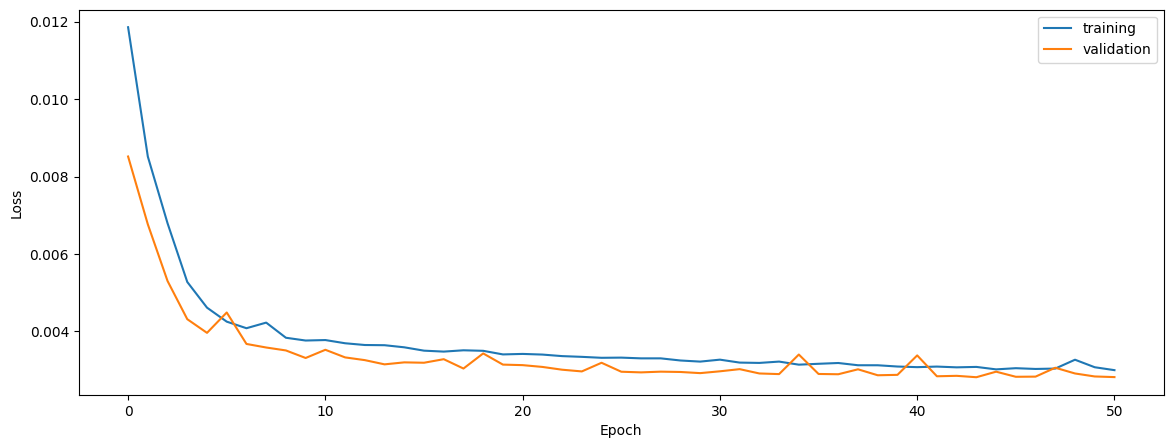

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

train
0.823262067400355
0.8207696428964206
0.8078380535148558


In [8]:
print('normalized')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

normalized
0.823262067400355
0.8207696428964206
0.8078380535148558


In [9]:
print('native')
print(getPearson(train[1][train[2]],train_pred[train[2]]))
print(getPearson(val[1][val[2]],val_pred[val[2]]))
print(getPearson(test[1][test[2]],test_pred[test[2]]))

native
0.8196226721574921
0.8263094575754045
0.8047738072681827


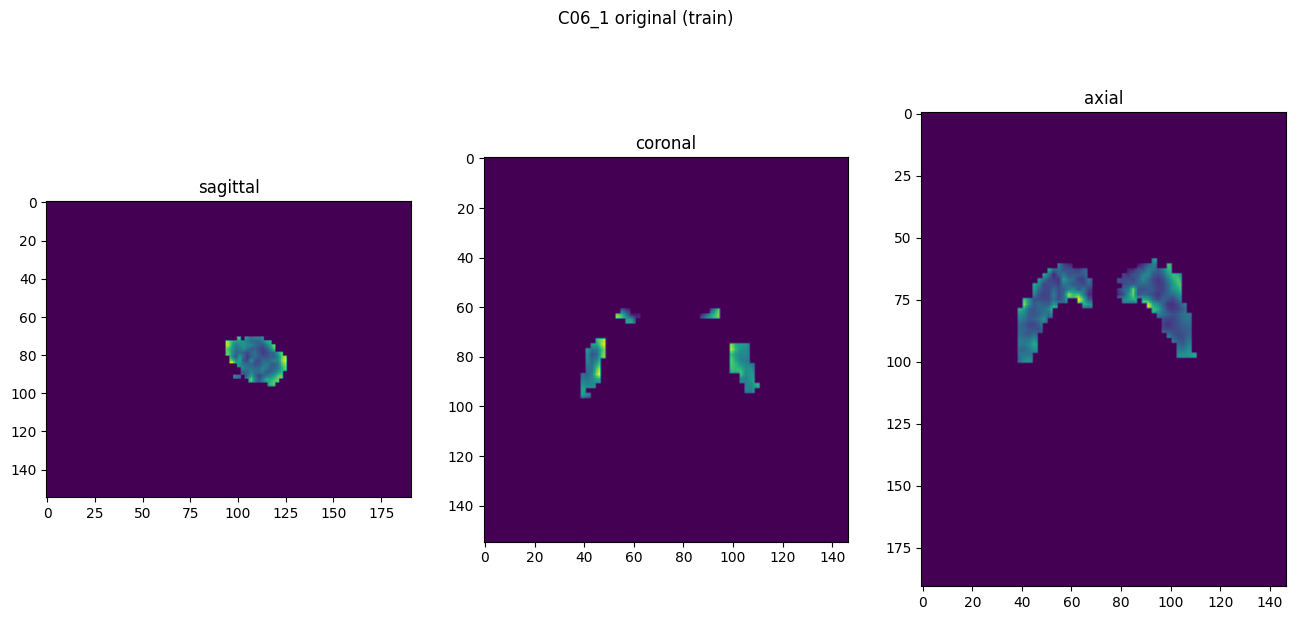

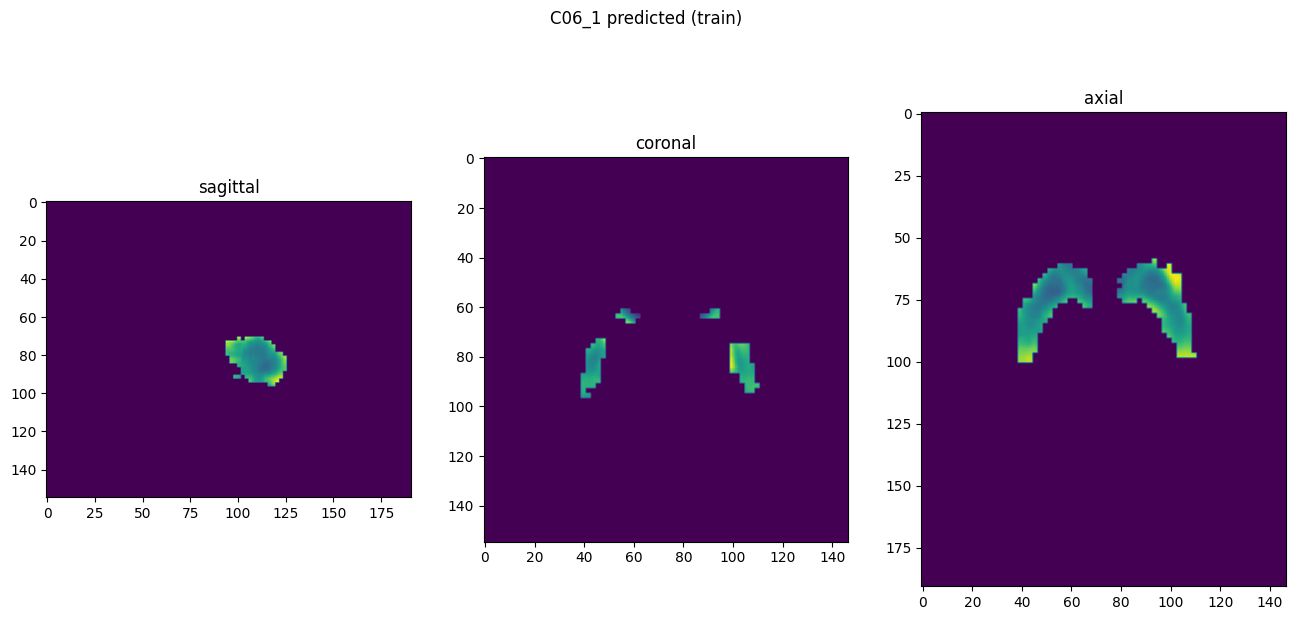

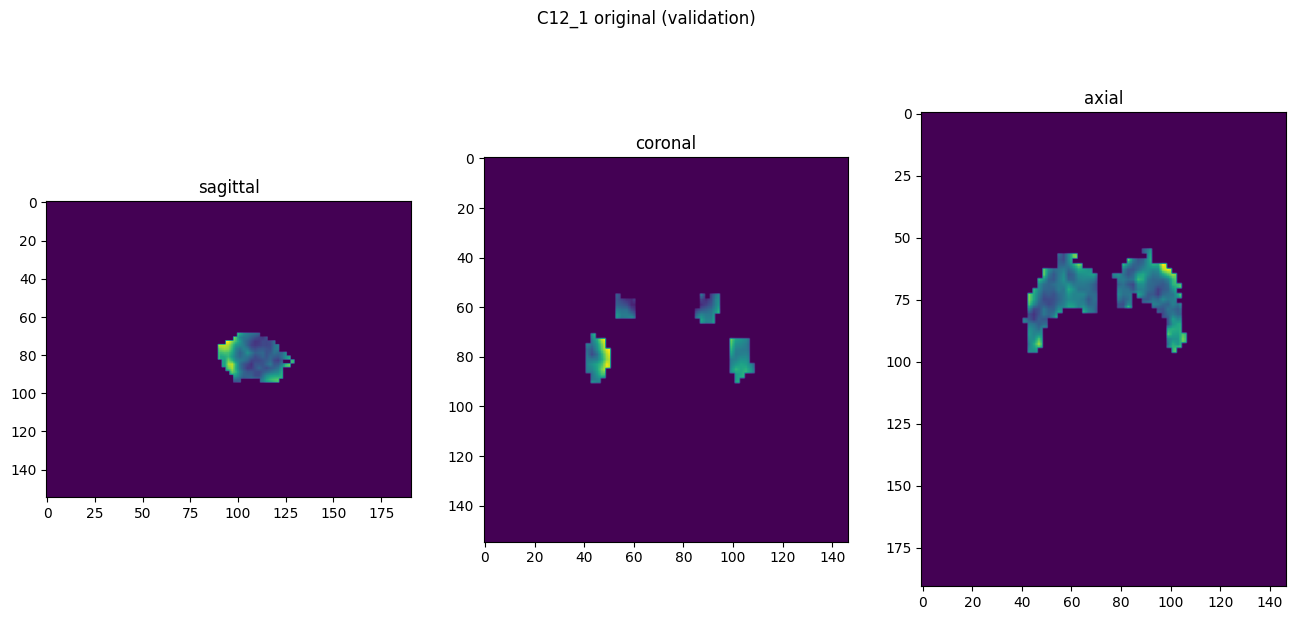

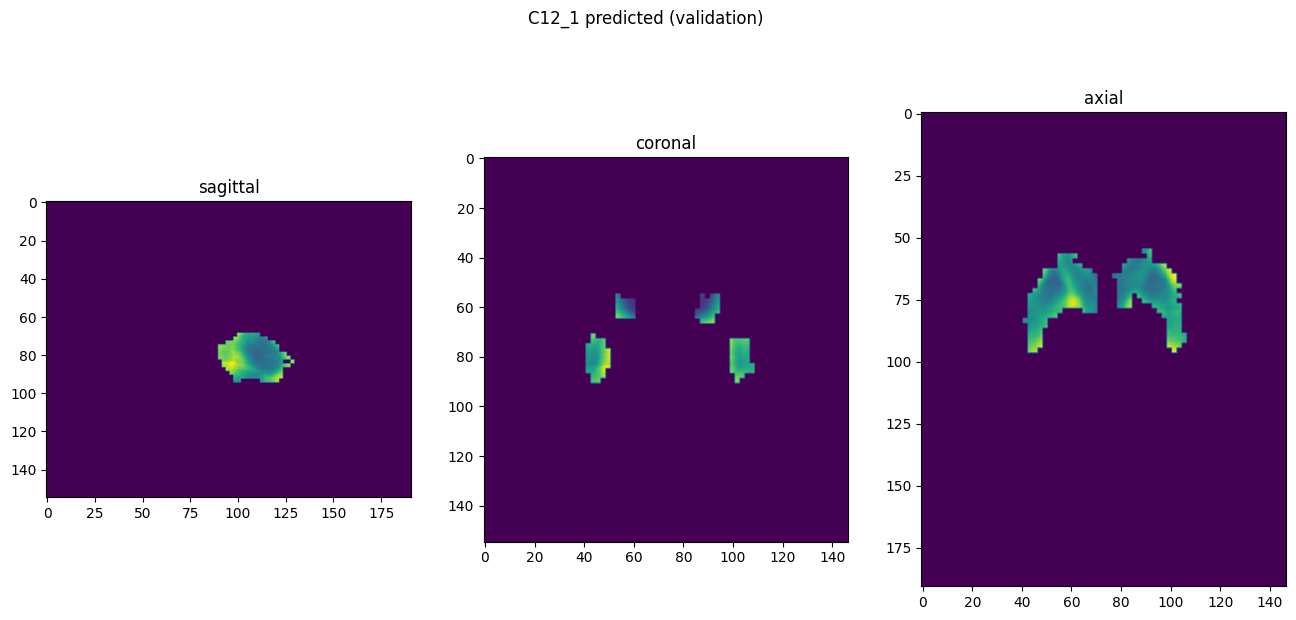

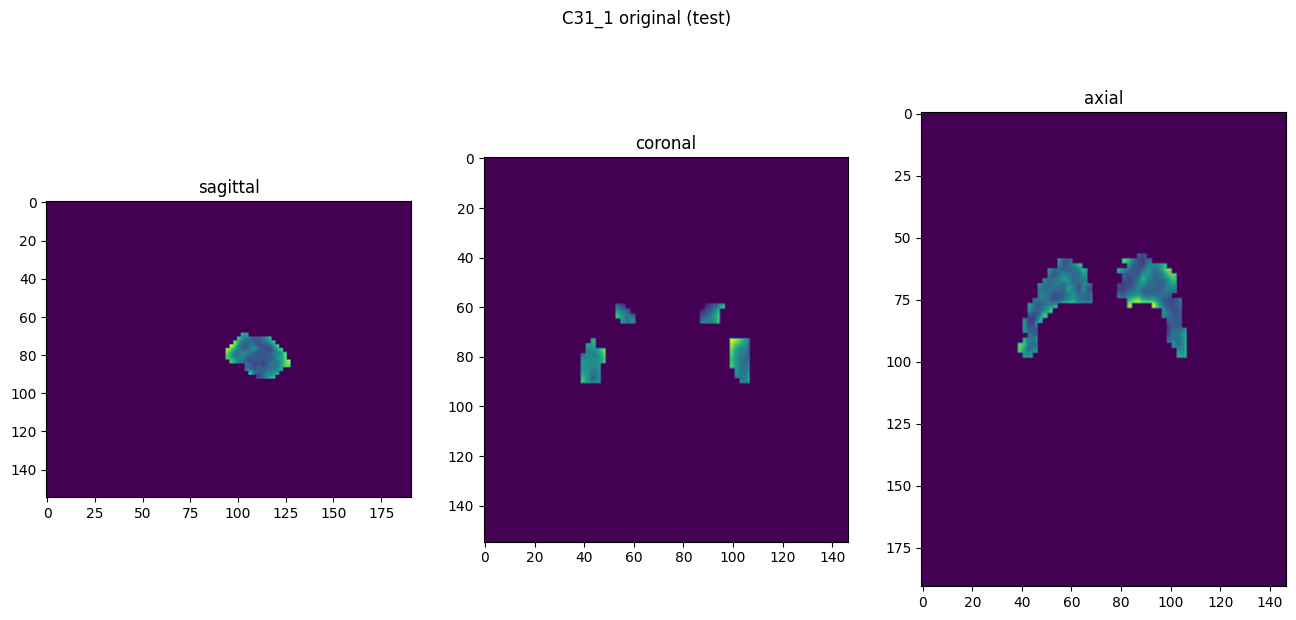

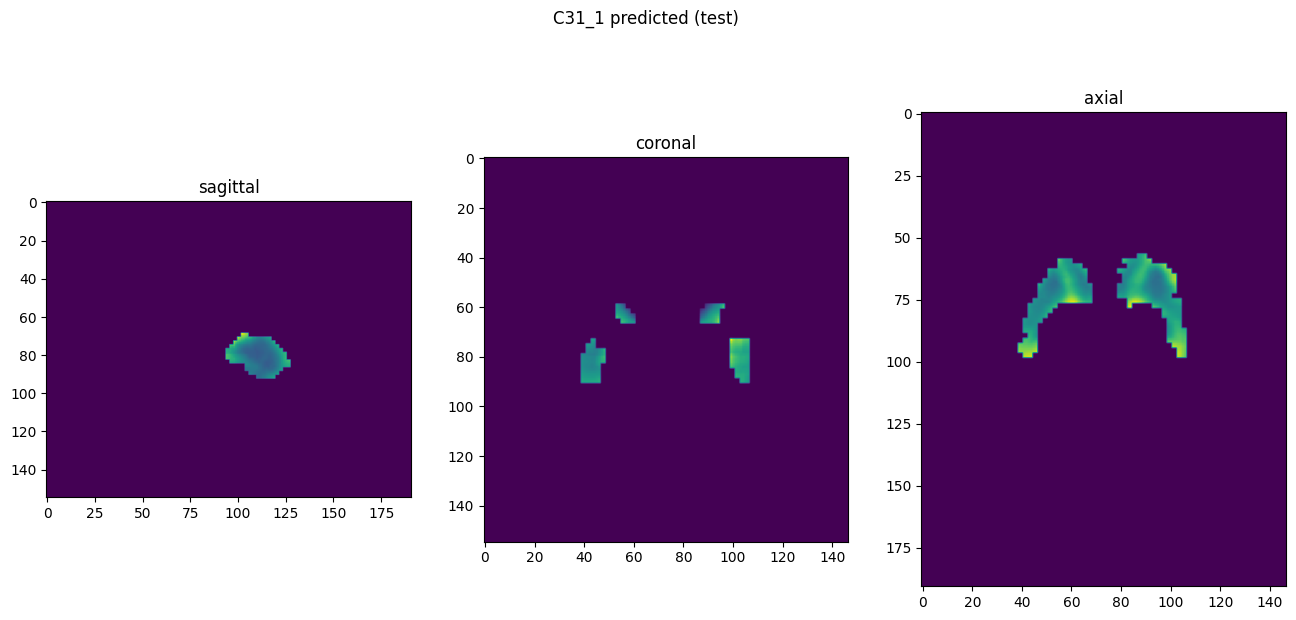

In [10]:
showResults(model, gen, threshold=None, background=False)